In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm 
import torch

from torch import nn, distributions
from torch.distributions import constraints
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import norm

rng = np.random.RandomState(1234)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MCMC

Taken from PyMC tutorial here: https://www.pymc.io/projects/examples/en/latest/case_studies/stochastic_volatility.html

$\sigma \sim Exponential(10)$

$\nu \sim Exponential(.1)$

$s_i \sim Normal(s_{i-1}, \sigma^2)$

$\log(r_i) \sim t(\nu, 0, \exp(-2 s_i))$

In [2]:
try:
    returns = pd.read_csv(os.path.join("..", "data", "SP500.csv"), index_col="Date")
except FileNotFoundError:
    returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")

returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()

returns.head()


Close    change
Date                             
2008-05-05  1407.489990 -0.004544
2008-05-06  1418.260010  0.007623
2008-05-07  1392.569946 -0.018280
2008-05-08  1397.680054  0.003663
2008-05-09  1388.280029 -0.006748

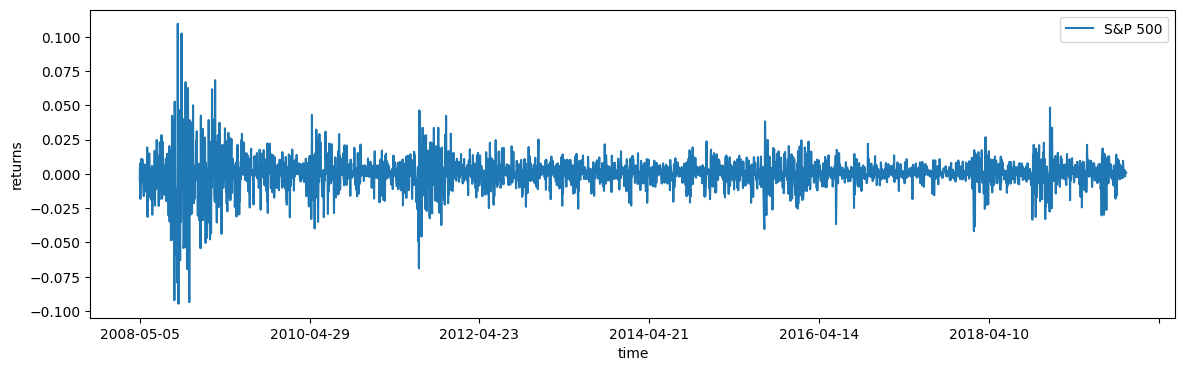

In [3]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label="S&P 500", ax=ax)
ax.set(xlabel="time", ylabel="returns")
ax.legend();

In [4]:
def make_stochastic_volatility_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, dims="time")
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT(
            "returns", nu=nu, lam=np.exp(-2 * volatility), observed=data["change"], dims="time"
        )
    return model


stochastic_vol_model = make_stochastic_volatility_model(returns)

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/pymc/distributions/timeseries.py:292: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


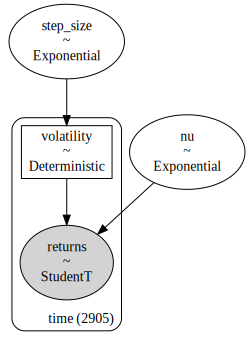

In [5]:
pm.model_to_graphviz(stochastic_vol_model)

In [6]:
with stochastic_vol_model:
    idata = pm.sample_prior_predictive(500, random_seed=rng)

prior_predictive = idata.prior_predictive.stack(pooled_chain=("chain", "draw"))


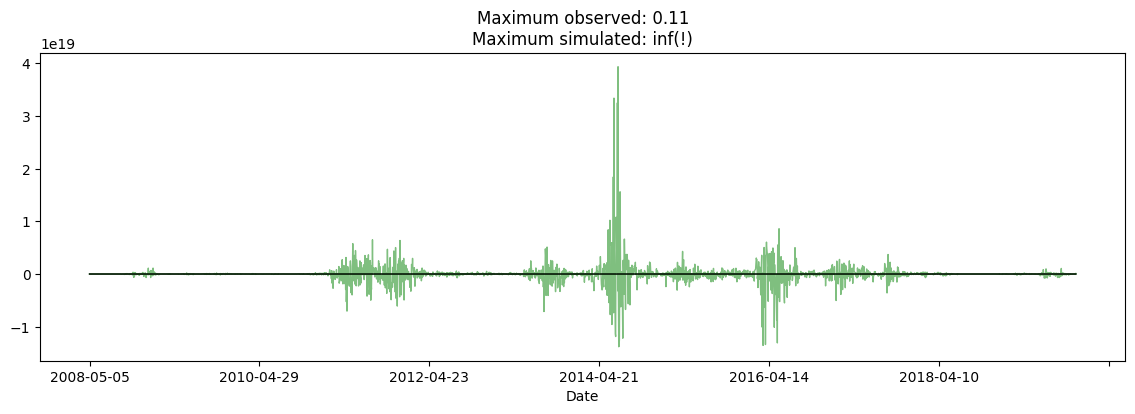

In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
returns["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

In [8]:
with stochastic_vol_model:
    idata.extend(pm.sample(2000, tune=2000, random_seed=rng))

posterior = idata.posterior.stack(pooled_chain=("chain", "draw"))
posterior["exp_volatility"] = np.exp(posterior["volatility"])

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 873 seconds.
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(


In [9]:
with stochastic_vol_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

posterior_predictive = idata.posterior_predictive.stack(pooled_chain=("chain", "draw"))


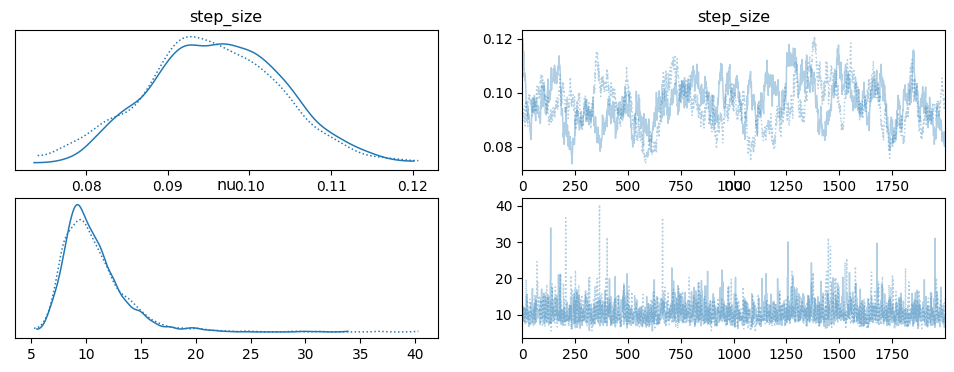

In [10]:
az.plot_trace(idata, var_names=["step_size", "nu"]);

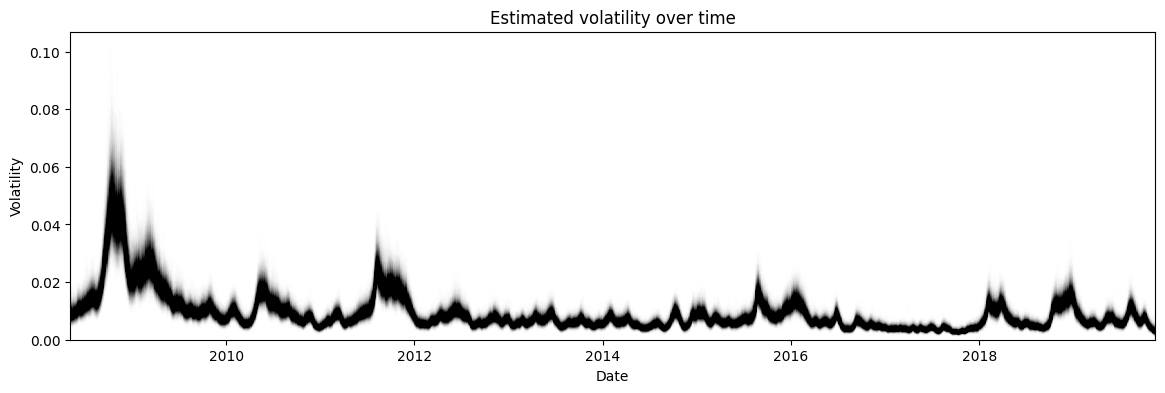

In [11]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

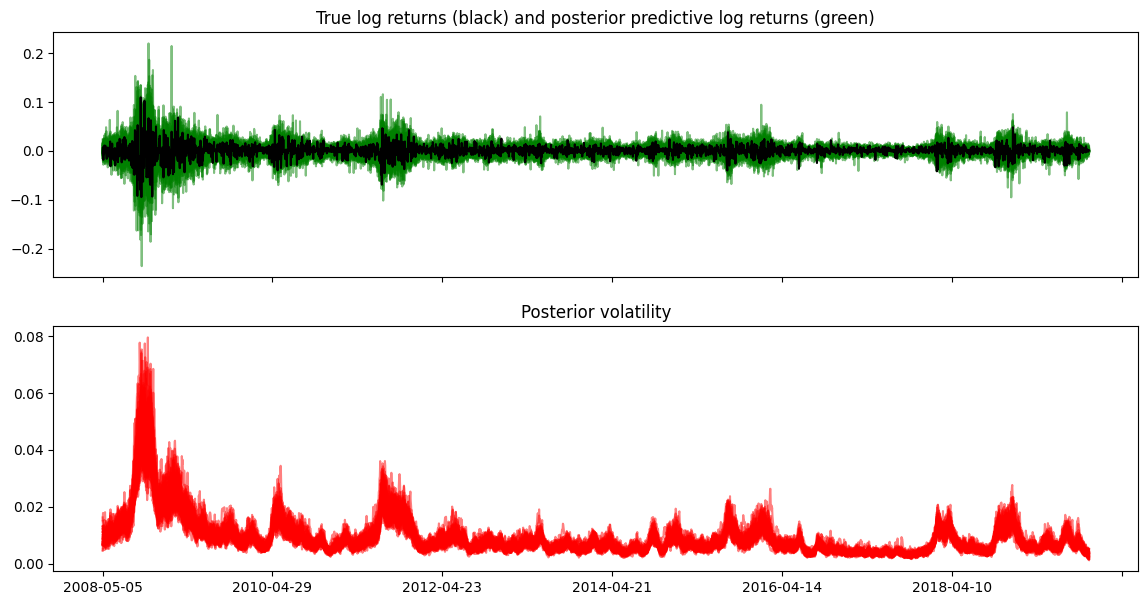

In [12]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns["change"].plot(ax=axes[0], color="black")

axes[1].plot(posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 100)), "r", alpha=0.5)
axes[0].plot(
    posterior_predictive["returns"].isel(pooled_chain=slice(None, None, 100)),
    "g",
    alpha=0.5,
    zorder=-10,
)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");

# SGLD Torch Models

$X_i = log(r_i)$

$
p(s_i, \nu, \sigma | {\bf x}) = [\Pi_ip(x_i | s_i, \nu, \sigma) p(s_i | s_{i-1}, \sigma)] p(\nu) p(\sigma)
$

In [470]:
class StochasticVolatility(nn.Module):
    EPSILON = 1e-6
    
    def __init__(self, shape, sigma_lambda=10., nu_lambda=0.1):
        '''
            Args:
                shape: shape of observed variables; first dim is batch_size
                sigma_lamda: rate parameter of Exponential prior RV of stepsize (aka sigma)
                nu_lamda: rate parameter of Exponential prior RV of degree freedom
        '''
        super(StochasticVolatility, self).__init__()
        self.shape = shape
        
        self.prior_sigma_rv = distributions.Exponential(sigma_lambda)
        self.sigma = nn.Parameter(torch.tensor(sigma_lambda))
        
        self.prior_nu_rv = distributions.Exponential(nu_lambda)
        self.nu = nn.Parameter(torch.tensor(nu_lambda))
        
        self.vol = nn.Parameter(torch.zeros(self.shape[1]))
        nn.init.normal_(self.vol, std=0.0001)
        
        self.init_vol = nn.Parameter(torch.tensor(-4.5))
      
    def returns_rv(self, vol_samples):
        # Uses \sigma parameterization, not \lambda as PyMC model above
        # See: https://en.wikipedia.org/wiki/Student%27s_t-distribution#In_terms_of_scaling_parameter_%CF%83%CC%82_or_%CF%83%CC%822
        rv = distributions.StudentT(df=(1 / (self.nu + self.EPSILON)) * torch.ones(vol_samples.shape), 
                                    loc=torch.zeros(vol_samples.shape), 
                                    scale=torch.exp(vol_samples) + self.EPSILON)
        return rv

    def forward(self):
        vol_rv = distributions.Normal(torch.stack([self.vol] * self.shape[0]),
                                      (1 / self.sigma) * torch.ones(self.shape))
        vol_diffs = vol_rv.rsample()
        vol_samples = self.init_vol + torch.cumsum(vol_diffs, dim=1)

        return self.returns_rv(vol_samples).mean, vol_samples

    def loss(self, r_obs, vol_samples):
        likelihood = self.returns_rv(vol_samples).log_prob(r_obs)
       
        # Prior for each timestep
        sigma_prior = self.prior_sigma_rv.log_prob(1 / self.sigma)
        nu_prior = self.prior_nu_rv.log_prob(1 / self.nu)
        
        print(f'll = {likelihood.sum():.3f}, sigma_prior = {sigma_prior.sum():.3f}, nu_prior = {nu_prior.sum():.3f}')
        return -(likelihood.sum() + sigma_prior.sum() + nu_prior.sum()) / self.shape[0]


# Stochastic Gradient Descent

In [471]:
batch_size = 100


torch_data = torch.tensor(returns['change'])
torch_data = torch.stack([torch_data] * batch_size, 0)

torch_data, torch_data.shape

(tensor([[-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         ...,
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008]],
        dtype=torch.float64),
 torch.Size([100, 2905]))

In [472]:
torch.manual_seed(0)
np.random.seed(0)

torch_model = StochasticVolatility(torch_data.shape, sigma_lambda=10., nu_lambda=0.1)
lr = 0.001
optimizer = optim.RMSprop(torch_model.parameters(), lr=lr)

epoch = 0
loss_seq = []
for epoch in range(603):
    print(f'========================================')
    torch_model.zero_grad()
    r_samples, vol_samples = torch_model()
    loss = torch_model.loss(torch_data, vol_samples)
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(torch_model.sigma, max_norm=50.)
    optimizer.step()

    print(f'[epoch={epoch+1}] loss: {loss.item():.5f}')
    loss_seq.append(loss.item())
        
for name, param in torch_model.named_parameters():
    print(f'{name} = {param}')
    if name in {'sigma', 'nu'}:
        print(f' * 1 / {name} = {1 / param}')

loss_seq = pd.Series(loss_seq)
loss_seq.rolling(50).mean().plot()

ll = -609491.835, sigma_prior = 1.303, nu_prior = -3.303
[epoch=1] loss: 6094.93835
ll = -3219394.969, sigma_prior = 1.403, nu_prior = -3.302
[epoch=2] loss: 32193.96868
ll = -630335.972, sigma_prior = 1.405, nu_prior = -3.302
[epoch=3] loss: 6303.37869
ll = -1911036.136, sigma_prior = 1.437, nu_prior = -3.302
[epoch=4] loss: 19110.38001
ll = -2510503.224, sigma_prior = 1.524, nu_prior = -3.301
[epoch=5] loss: 25105.05001
ll = -1433355.896, sigma_prior = 1.524, nu_prior = -3.301
[epoch=6] loss: 14333.57672
ll = -581349.198, sigma_prior = 1.526, nu_prior = -3.301
[epoch=7] loss: 5813.50973
ll = -10835.390, sigma_prior = 1.533, nu_prior = -3.301
[epoch=8] loss: 108.37157
ll = 76697.650, sigma_prior = 1.564, nu_prior = -3.301
[epoch=9] loss: -766.95914
ll = 174382.382, sigma_prior = 1.602, nu_prior = -3.300
[epoch=10] loss: -1743.80683
ll = 262886.838, sigma_prior = 1.625, nu_prior = -3.300
[epoch=11] loss: -2628.85163
ll = 170840.412, sigma_prior = 1.656, nu_prior = -3.300
[epoch=12] los

[epoch=73] loss: -7502.62921
ll = 883927.673, sigma_prior = 2.267, nu_prior = -3.298
[epoch=74] loss: -8839.26643
ll = 710489.048, sigma_prior = 2.270, nu_prior = -3.298
[epoch=75] loss: -7104.88020
ll = 916923.870, sigma_prior = 2.268, nu_prior = -3.298
[epoch=76] loss: -9169.22840
ll = 803727.627, sigma_prior = 2.272, nu_prior = -3.298
[epoch=77] loss: -8037.26601
ll = 824899.561, sigma_prior = 2.274, nu_prior = -3.298
[epoch=78] loss: -8248.98537
ll = 431176.272, sigma_prior = 2.278, nu_prior = -3.298
[epoch=79] loss: -4311.75252
ll = 867627.534, sigma_prior = 2.278, nu_prior = -3.298
[epoch=80] loss: -8676.26514
ll = 826990.164, sigma_prior = 2.280, nu_prior = -3.298
[epoch=81] loss: -8269.89145
ll = 468246.018, sigma_prior = 2.283, nu_prior = -3.298
[epoch=82] loss: -4682.45003
ll = 888998.572, sigma_prior = 2.283, nu_prior = -3.298
[epoch=83] loss: -8889.97557
ll = 836078.465, sigma_prior = 2.283, nu_prior = -3.298
[epoch=84] loss: -8360.77450
ll = 493961.336, sigma_prior = 2.288

[epoch=146] loss: -8695.75050
ll = 601141.810, sigma_prior = 2.297, nu_prior = -3.297
[epoch=147] loss: -6011.40810
ll = 942808.395, sigma_prior = 2.294, nu_prior = -3.297
[epoch=148] loss: -9428.07391
ll = 926503.508, sigma_prior = 2.294, nu_prior = -3.297
[epoch=149] loss: -9265.02505
ll = 821449.267, sigma_prior = 2.297, nu_prior = -3.297
[epoch=150] loss: -8214.48267
ll = 872874.400, sigma_prior = 2.295, nu_prior = -3.297
[epoch=151] loss: -8728.73398
ll = 610598.556, sigma_prior = 2.297, nu_prior = -3.297
[epoch=152] loss: -6105.97555
ll = 946137.877, sigma_prior = 2.299, nu_prior = -3.297
[epoch=153] loss: -9461.36878
ll = 936286.009, sigma_prior = 2.299, nu_prior = -3.297
[epoch=154] loss: -9362.85011
ll = 863331.380, sigma_prior = 2.299, nu_prior = -3.297
[epoch=155] loss: -8633.30382
ll = 842023.158, sigma_prior = 2.300, nu_prior = -3.297
[epoch=156] loss: -8420.22161
ll = 507281.675, sigma_prior = 2.301, nu_prior = -3.297
[epoch=157] loss: -5072.80680
ll = 900862.842, sigma_p

ValueError: Expected parameter scale (Tensor of shape (100, 2905)) of distribution Normal(loc: torch.Size([100, 2905]), scale: torch.Size([100, 2905])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[-3.4312e-06, -3.4312e-06, -3.4312e-06,  ..., -3.4312e-06,
         -3.4312e-06, -3.4312e-06],
        [-3.4312e-06, -3.4312e-06, -3.4312e-06,  ..., -3.4312e-06,
         -3.4312e-06, -3.4312e-06],
        [-3.4312e-06, -3.4312e-06, -3.4312e-06,  ..., -3.4312e-06,
         -3.4312e-06, -3.4312e-06],
        ...,
        [-3.4312e-06, -3.4312e-06, -3.4312e-06,  ..., -3.4312e-06,
         -3.4312e-06, -3.4312e-06],
        [-3.4312e-06, -3.4312e-06, -3.4312e-06,  ..., -3.4312e-06,
         -3.4312e-06, -3.4312e-06],
        [-3.4312e-06, -3.4312e-06, -3.4312e-06,  ..., -3.4312e-06,
         -3.4312e-06, -3.4312e-06]], grad_fn=<MulBackward0>)

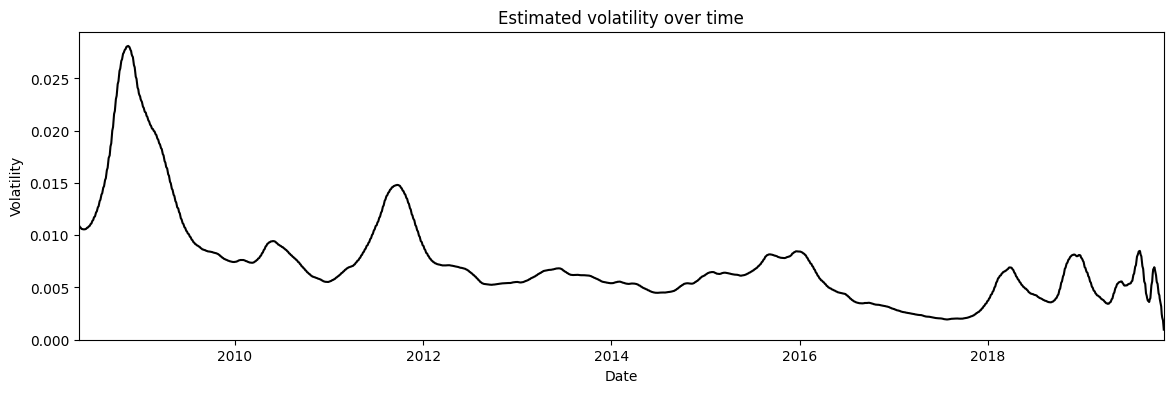

In [428]:
sigma_rv = distributions.Exponential(torch_model.sigma)
sigma_mean = sigma_rv.mean

vol_mean = torch_model.init_vol + torch.cumsum(torch_model.vol, dim=0) 

fig, ax = plt.subplots(figsize=(14, 4))
y_vals = np.exp(vol_mean.cpu().detach().numpy())
x_vals = returns.index.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k")#, alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

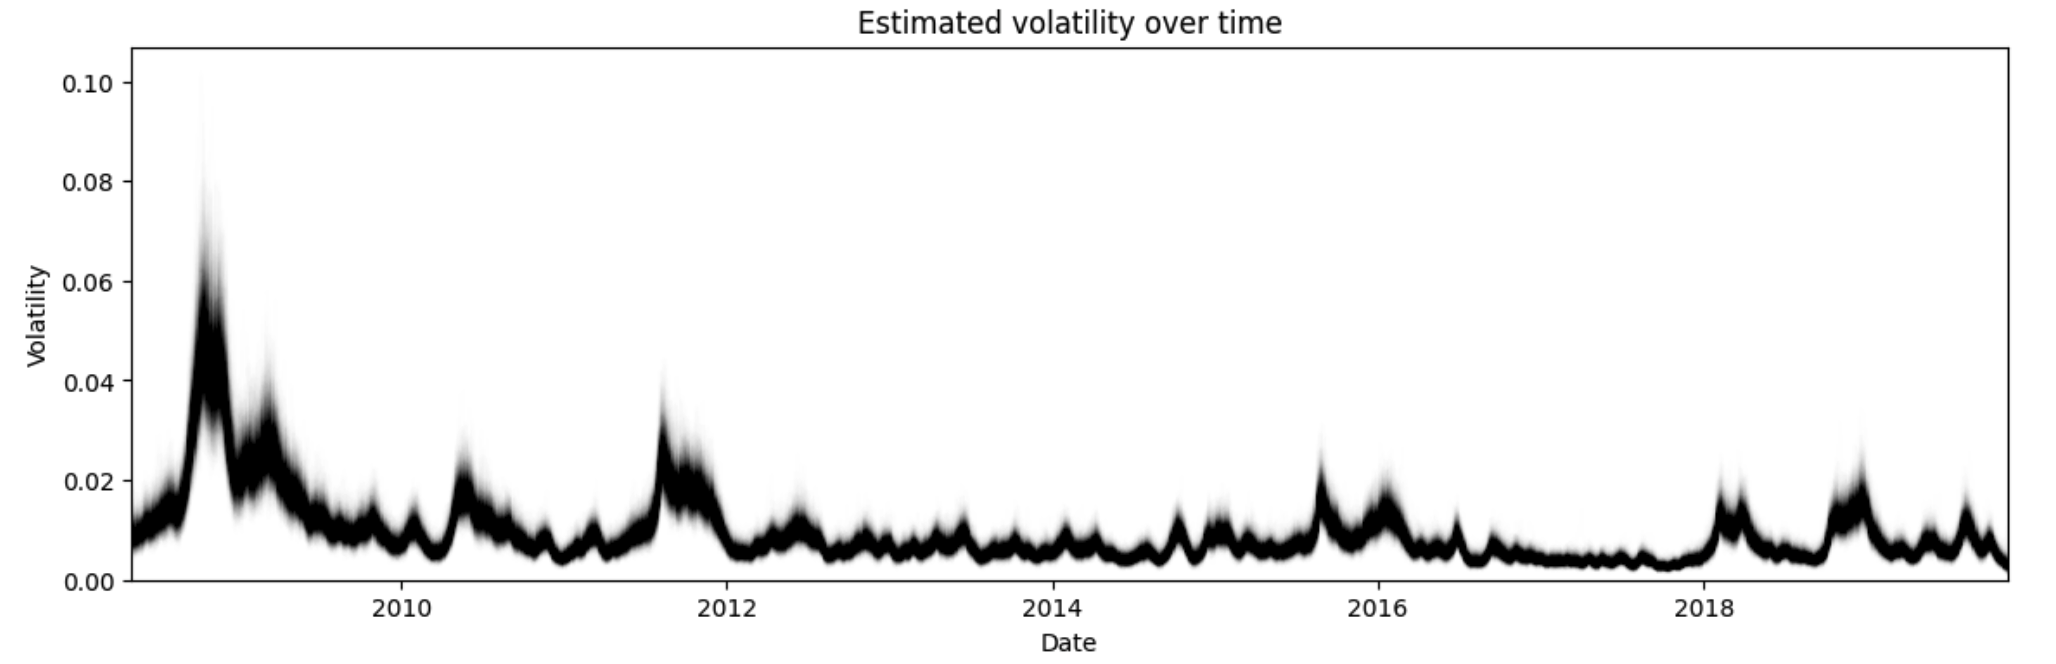

# Stochastic Gradient Langevin Dynamics

In [354]:
class SGLD(torch.optim.RMSprop):
    def __init__(self, *args, **kwargs):
        super(SGLD, self).__init__(*args, **kwargs)
        
    def step(self, *args, **kwargs):
        loss = super().step(*args, **kwargs)
       
        with torch.no_grad():
            for group in self.param_groups:
                assert group['momentum'] == 0, "momentum not supported"
                assert group['centered'] == 0, "centered not supported"
                assert group['weight_decay'] == 0, "weight_decay not supported"
                
                lr = group['lr']
                for p in group['params']:
                    assert not torch.is_complex(p), "complex not supported"
                    state = self.state[p]
                    square_avg = state['square_avg']
                
                    avg = square_avg.sqrt()
                    avg = avg.add_(group['eps'])
                
                    effective_lr = 2 * lr / avg
                    m = distributions.Normal(torch.zeros(p.shape), torch.ones(p.shape))
                    noise = m.sample() * effective_lr.sqrt()
                    p.sub_(noise)
        
        return loss

In [429]:
def compute_lr(epoch, burnin=1000, start=0.001, gamma=0.55):
    if epoch < burnin:
        return start
    
    epoch = epoch - burnin
    b = 1
    return start * ((b + epoch) ** (-gamma))

for i in [0, 2000, 5000, 10000]:
    print(f't={i:05d}: {compute_lr(i):8f}')

t=00000: 0.001000
t=02000: 0.000022
t=05000: 0.000010
t=10000: 0.000007


ll = -609481.744, sigma_prior = 1.303, nu_prior = -3.303
vol_delta = tensor([-0.0100, -0.0100, -0.0100,  ..., -0.0100, -0.0100, -0.0100])
vol noise = tensor([-0.0019,  0.0038, -0.0017,  0.0038,  0.0009])
[epoch=1] loss: 6094.83744, last_lr: [0.001]
ll = -3371866.976, sigma_prior = 1.304, nu_prior = -3.212
vol_delta = tensor([0.0062, 0.0062, 0.0062,  ..., 0.0081, 0.0086, 0.0084])
vol noise = tensor([-0.0016, -0.0018, -0.0005, -0.0032,  0.0006])
[epoch=2] loss: 33718.68885, last_lr: [0.001]
ll = -706138.419, sigma_prior = 1.304, nu_prior = -3.216
vol_delta = tensor([0.0024, 0.0024, 0.0024,  ..., 0.0060, 0.0063, 0.0063])
vol noise = tensor([-0.0024,  0.0002,  0.0004, -0.0010, -0.0024])
[epoch=3] loss: 7061.40332, last_lr: [0.001]
ll = -983513.482, sigma_prior = 1.304, nu_prior = -3.208
vol_delta = tensor([-0.0073, -0.0073, -0.0073,  ..., -0.0046, -0.0037, -0.0036])
vol noise = tensor([ 0.0012, -0.0020,  0.0022,  0.0009,  0.0022])
[epoch=4] loss: 9835.15386, last_lr: [0.001]
ll = -2090248.

vol_delta = tensor([-1.3924e-03, -1.3934e-03, -1.3940e-03,  ..., -3.0901e-04,
        -5.1950e-05, -4.6883e-05])
vol noise = tensor([ 0.0008, -0.0017, -0.0008, -0.0012, -0.0002])
[epoch=29] loss: 3019.89233, last_lr: [0.001]
ll = -317322.572, sigma_prior = 1.311, nu_prior = -2.955
vol_delta = tensor([0.0019, 0.0019, 0.0019,  ..., 0.0026, 0.0027, 0.0027])
vol noise = tensor([ 0.0028,  0.0029,  0.0001, -0.0022, -0.0007])
[epoch=30] loss: 3173.24215, last_lr: [0.001]
ll = -170048.933, sigma_prior = 1.311, nu_prior = -2.951
vol_delta = tensor([-0.0021, -0.0021, -0.0021,  ..., -0.0009, -0.0005, -0.0003])
vol noise = tensor([-0.0006, -0.0010, -0.0015,  0.0002, -0.0006])
[epoch=31] loss: 1700.50574, last_lr: [0.001]
ll = -363557.123, sigma_prior = 1.311, nu_prior = -2.944
vol_delta = tensor([0.0020, 0.0020, 0.0020,  ..., 0.0027, 0.0028, 0.0028])
vol noise = tensor([ 0.0008, -0.0001,  0.0021,  0.0022, -0.0034])
[epoch=32] loss: 3635.58756, last_lr: [0.001]
ll = -821501.820, sigma_prior = 1.312

vol_delta = tensor([0.0010, 0.0010, 0.0010,  ..., 0.0013, 0.0015, 0.0016])
vol noise = tensor([ 0.0016, -0.0003, -0.0032, -0.0037, -0.0018])
[epoch=69] loss: 1626.84161, last_lr: [0.001]
ll = -220098.529, sigma_prior = 1.315, nu_prior = -2.830
vol_delta = tensor([-0.0014, -0.0014, -0.0014,  ..., -0.0021, -0.0019, -0.0017])
vol noise = tensor([-0.0022,  0.0007, -0.0007, -0.0012, -0.0005])
[epoch=70] loss: 2201.00044, last_lr: [0.001]
ll = -109562.980, sigma_prior = 1.315, nu_prior = -2.825
vol_delta = tensor([0.0015, 0.0015, 0.0015,  ..., 0.0021, 0.0021, 0.0021])
vol noise = tensor([ 0.0016,  0.0014, -0.0015,  0.0003,  0.0009])
[epoch=71] loss: 1095.64489, last_lr: [0.001]
ll = 34805.797, sigma_prior = 1.315, nu_prior = -2.824
vol_delta = tensor([-0.0007, -0.0007, -0.0007,  ..., -0.0018, -0.0014, -0.0011])
vol noise = tensor([-0.0001,  0.0013, -0.0035, -0.0018,  0.0002])
[epoch=72] loss: -348.04289, last_lr: [0.001]
ll = 25.719, sigma_prior = 1.316, nu_prior = -2.821
vol_delta = tensor(

vol_delta = tensor([0.0002, 0.0002, 0.0002,  ..., 0.0003, 0.0004, 0.0003])
vol noise = tensor([ 0.0011, -0.0008, -0.0012,  0.0002,  0.0008])
[epoch=109] loss: 1337.92054, last_lr: [0.001]
ll = -53971.544, sigma_prior = 1.320, nu_prior = -2.743
vol_delta = tensor([0.0012, 0.0012, 0.0012,  ..., 0.0003, 0.0004, 0.0003])
vol noise = tensor([ 0.0003,  0.0009, -0.0006, -0.0006, -0.0016])
[epoch=110] loss: 539.72968, last_lr: [0.001]
ll = -151476.552, sigma_prior = 1.320, nu_prior = -2.742
vol_delta = tensor([-0.0008, -0.0008, -0.0008,  ..., -0.0007, -0.0006, -0.0007])
vol noise = tensor([-0.0019,  0.0017,  0.0016, -0.0014,  0.0011])
[epoch=111] loss: 1514.77975, last_lr: [0.001]
ll = 94082.911, sigma_prior = 1.320, nu_prior = -2.740
vol_delta = tensor([-4.0634e-05, -4.1587e-05, -4.2200e-05,  ..., -5.0556e-04,
        -4.4430e-04, -6.3150e-04])
vol noise = tensor([ 0.0011,  0.0029,  0.0016, -0.0021, -0.0003])
[epoch=112] loss: -940.81491, last_lr: [0.001]
ll = -90962.008, sigma_prior = 1.320,

ll = -104402.548, sigma_prior = 1.324, nu_prior = -2.690
vol_delta = tensor([-0.0008, -0.0008, -0.0008,  ...,  0.0003,  0.0003,  0.0001])
vol noise = tensor([-0.0007,  0.0008, -0.0003,  0.0022, -0.0022])
[epoch=150] loss: 1044.03914, last_lr: [0.001]
ll = -2130.247, sigma_prior = 1.324, nu_prior = -2.688
vol_delta = tensor([0.0012, 0.0012, 0.0012,  ..., 0.0019, 0.0019, 0.0017])
vol noise = tensor([ 0.0009,  0.0003, -0.0017,  0.0002, -0.0019])
[epoch=151] loss: 21.31611, last_lr: [0.001]
ll = -76524.698, sigma_prior = 1.324, nu_prior = -2.689
vol_delta = tensor([-0.0006, -0.0006, -0.0006,  ..., -0.0004, -0.0003, -0.0004])
vol noise = tensor([-0.0023,  0.0006,  0.0005, -0.0007,  0.0013])
[epoch=152] loss: 765.26063, last_lr: [0.001]
ll = -60781.023, sigma_prior = 1.324, nu_prior = -2.687
vol_delta = tensor([0.0003, 0.0003, 0.0003,  ..., 0.0009, 0.0010, 0.0008])
vol noise = tensor([-0.0002, -0.0003, -0.0028, -0.0014,  0.0015])
[epoch=153] loss: 607.82386, last_lr: [0.001]
ll = 51167.320, 

vol_delta = tensor([-0.0003, -0.0003, -0.0003,  ..., -0.0002, -0.0002, -0.0004])
vol noise = tensor([-0.0034,  0.0003,  0.0026,  0.0005,  0.0008])
[epoch=189] loss: 376.49508, last_lr: [0.001]
ll = -23402.976, sigma_prior = 1.326, nu_prior = -2.649
vol_delta = tensor([-0.0008, -0.0008, -0.0008,  ..., -0.0011, -0.0011, -0.0012])
vol noise = tensor([-0.0008,  0.0013, -0.0010,  0.0005,  0.0008])
[epoch=190] loss: 234.04299, last_lr: [0.001]
ll = -149030.343, sigma_prior = 1.326, nu_prior = -2.649
vol_delta = tensor([0.0019, 0.0019, 0.0019,  ..., 0.0014, 0.0014, 0.0013])
vol noise = tensor([ 1.3465e-03, -2.3898e-05,  2.2333e-03, -7.2419e-04,  1.7011e-03])
[epoch=191] loss: 1490.31665, last_lr: [0.001]
ll = -85742.425, sigma_prior = 1.326, nu_prior = -2.648
vol_delta = tensor([-0.0010, -0.0010, -0.0010,  ..., -0.0007, -0.0007, -0.0009])
vol noise = tensor([-0.0003, -0.0015,  0.0010, -0.0040, -0.0005])
[epoch=192] loss: 857.43747, last_lr: [0.001]
ll = -41913.269, sigma_prior = 1.326, nu_pri

vol_delta = tensor([0.0005, 0.0005, 0.0005,  ..., 0.0006, 0.0006, 0.0006])
vol noise = tensor([ 9.1349e-04,  9.6167e-04, -3.1441e-04, -5.1334e-04,  1.1146e-05])
[epoch=229] loss: -1534.15525, last_lr: [0.001]
ll = -98238.375, sigma_prior = 1.330, nu_prior = -2.618
vol_delta = tensor([-0.0017, -0.0017, -0.0017,  ..., -0.0013, -0.0013, -0.0013])
vol noise = tensor([-0.0012, -0.0009,  0.0014,  0.0007, -0.0011])
[epoch=230] loss: 982.39662, last_lr: [0.001]
ll = -186388.829, sigma_prior = 1.330, nu_prior = -2.616
vol_delta = tensor([0.0016, 0.0016, 0.0016,  ..., 0.0018, 0.0018, 0.0018])
vol noise = tensor([-6.2544e-04, -1.0897e-03, -9.5884e-04,  2.5595e-05, -2.6207e-03])
[epoch=231] loss: 1863.90115, last_lr: [0.001]
ll = 104222.745, sigma_prior = 1.330, nu_prior = -2.616
vol_delta = tensor([-0.0004, -0.0004, -0.0004,  ..., -0.0010, -0.0010, -0.0011])
vol noise = tensor([ 0.0023,  0.0013,  0.0012, -0.0024,  0.0024])
[epoch=232] loss: -1042.21459, last_lr: [0.001]
ll = 132903.554, sigma_pri

ll = 29550.537, sigma_prior = 1.334, nu_prior = -2.592
vol_delta = tensor([-0.0008, -0.0008, -0.0008,  ...,  0.0002,  0.0003,  0.0002])
vol noise = tensor([-0.0016, -0.0021,  0.0011, -0.0007, -0.0004])
[epoch=269] loss: -295.49279, last_lr: [0.001]
ll = 28637.948, sigma_prior = 1.334, nu_prior = -2.591
vol_delta = tensor([0.0004, 0.0004, 0.0004,  ..., 0.0008, 0.0008, 0.0007])
vol noise = tensor([ 1.6091e-03,  5.6111e-05, -3.0591e-04, -4.2855e-04, -1.5794e-03])
[epoch=270] loss: -286.36691, last_lr: [0.001]
ll = 33221.841, sigma_prior = 1.334, nu_prior = -2.591
vol_delta = tensor([0.0002, 0.0002, 0.0002,  ..., 0.0004, 0.0004, 0.0003])
vol noise = tensor([ 0.0012,  0.0022, -0.0038, -0.0004, -0.0003])
[epoch=271] loss: -332.20584, last_lr: [0.001]
ll = 74548.651, sigma_prior = 1.334, nu_prior = -2.591
vol_delta = tensor([0.0006, 0.0006, 0.0006,  ..., 0.0015, 0.0015, 0.0013])
vol noise = tensor([ 0.0008, -0.0032, -0.0022, -0.0006,  0.0020])
[epoch=272] loss: -745.47394, last_lr: [0.001]
ll

vol_delta = tensor([-0.0023, -0.0023, -0.0023,  ..., -0.0015, -0.0016, -0.0018])
vol noise = tensor([ 0.0006, -0.0004,  0.0004, -0.0019, -0.0013])
[epoch=308] loss: 185.13244, last_lr: [0.001]
ll = -32596.863, sigma_prior = 1.339, nu_prior = -2.570
vol_delta = tensor([0.0025, 0.0025, 0.0025,  ..., 0.0024, 0.0024, 0.0023])
vol noise = tensor([ 0.0005, -0.0014,  0.0029, -0.0024,  0.0020])
[epoch=309] loss: 325.98094, last_lr: [0.001]
ll = -147723.183, sigma_prior = 1.339, nu_prior = -2.570
vol_delta = tensor([-0.0017, -0.0017, -0.0017,  ..., -0.0002, -0.0002, -0.0003])
vol noise = tensor([-0.0010, -0.0007, -0.0017,  0.0016,  0.0028])
[epoch=310] loss: 1477.24414, last_lr: [0.001]
ll = 91255.317, sigma_prior = 1.339, nu_prior = -2.569
vol_delta = tensor([0.0014, 0.0014, 0.0014,  ..., 0.0021, 0.0021, 0.0020])
vol noise = tensor([ 0.0003, -0.0005,  0.0005,  0.0013,  0.0024])
[epoch=311] loss: -912.54088, last_lr: [0.001]
ll = 147515.636, sigma_prior = 1.339, nu_prior = -2.568
vol_delta = te

vol_delta = tensor([-0.0001, -0.0002, -0.0002,  ..., -0.0002, -0.0003, -0.0006])
vol noise = tensor([ 0.0009,  0.0015, -0.0021,  0.0005,  0.0003])
[epoch=349] loss: -1716.37444, last_lr: [0.001]
ll = 212708.922, sigma_prior = 1.343, nu_prior = -2.551
vol_delta = tensor([-8.7928e-05, -8.9138e-05, -8.9870e-05,  ...,  2.6129e-04,
         1.4598e-04, -1.8382e-04])
vol noise = tensor([-0.0011, -0.0013,  0.0003,  0.0037, -0.0004])
[epoch=350] loss: -2127.07714, last_lr: [0.001]
ll = 50456.027, sigma_prior = 1.343, nu_prior = -2.551
vol_delta = tensor([-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0004])
vol noise = tensor([ 1.1911e-03,  1.8397e-03, -2.2044e-03, -5.3035e-05, -1.2702e-03])
[epoch=351] loss: -504.54820, last_lr: [0.001]
ll = 184028.358, sigma_prior = 1.344, nu_prior = -2.550
vol_delta = tensor([ 7.7684e-04,  7.7567e-04,  7.7497e-04,  ...,  1.1667e-04,
        -4.1329e-05, -4.0888e-04])
vol noise = tensor([-0.0007,  0.0002, -0.0012, -0.0007,  0.0007])
[epoch=352] loss: 

ll = 170688.220, sigma_prior = 1.346, nu_prior = -2.535
vol_delta = tensor([0.0004, 0.0004, 0.0004,  ..., 0.0005, 0.0005, 0.0002])
vol noise = tensor([ 0.0002,  0.0012, -0.0033, -0.0004,  0.0043])
[epoch=390] loss: -1706.87030, last_lr: [0.001]
ll = 259672.802, sigma_prior = 1.346, nu_prior = -2.535
vol_delta = tensor([-4.0102e-05, -4.1315e-05, -4.2045e-05,  ...,  2.0942e-04,
         1.9190e-04, -1.3304e-04])
vol noise = tensor([ 0.0003, -0.0010, -0.0008,  0.0015,  0.0002])
[epoch=391] loss: -2596.71613, last_lr: [0.001]
ll = 102249.758, sigma_prior = 1.346, nu_prior = -2.534
vol_delta = tensor([-0.0016, -0.0016, -0.0016,  ..., -0.0009, -0.0010, -0.0014])
vol noise = tensor([ 0.0003,  0.0012,  0.0007, -0.0026,  0.0003])
[epoch=392] loss: -1022.48569, last_lr: [0.001]
ll = -14793.946, sigma_prior = 1.346, nu_prior = -2.534
vol_delta = tensor([0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0008])
vol noise = tensor([ 0.0017,  0.0009, -0.0027, -0.0018,  0.0021])
[epoch=393] loss: 147.95

vol_delta = tensor([0.0007, 0.0007, 0.0007,  ..., 0.0008, 0.0008, 0.0005])
vol noise = tensor([-5.0486e-05,  4.3861e-04, -1.2257e-03, -3.2826e-04, -4.0599e-03])
[epoch=430] loss: -1141.04969, last_lr: [0.001]
ll = 174706.794, sigma_prior = 1.348, nu_prior = -2.520
vol_delta = tensor([-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0002, -0.0006])
vol noise = tensor([-0.0001, -0.0022,  0.0011,  0.0003,  0.0015])
[epoch=431] loss: -1747.05622, last_lr: [0.001]
ll = 133013.692, sigma_prior = 1.348, nu_prior = -2.519
vol_delta = tensor([0.0002, 0.0002, 0.0002,  ..., 0.0008, 0.0008, 0.0005])
vol noise = tensor([-0.0002, -0.0012, -0.0035, -0.0008,  0.0018])
[epoch=432] loss: -1330.12521, last_lr: [0.001]
ll = 229978.441, sigma_prior = 1.348, nu_prior = -2.519
vol_delta = tensor([ 4.7773e-05,  4.6509e-05,  4.5735e-05,  ..., -6.5088e-05,
        -2.9244e-05, -2.7371e-04])
vol noise = tensor([ 0.0007, -0.0019, -0.0003,  0.0016,  0.0006])
[epoch=433] loss: -2299.77270, last_lr: [0.001]
ll = 181926.

vol_delta = tensor([0.0012, 0.0012, 0.0012,  ..., 0.0019, 0.0019, 0.0018])
vol noise = tensor([ 1.8678e-05, -1.1096e-03,  2.7989e-03,  4.8775e-03,  2.3034e-03])
[epoch=470] loss: -2135.45450, last_lr: [0.001]
ll = 148722.712, sigma_prior = 1.350, nu_prior = -2.507
vol_delta = tensor([-0.0006, -0.0006, -0.0006,  ...,  0.0006,  0.0006,  0.0003])
vol noise = tensor([ 0.0002,  0.0010,  0.0016,  0.0054, -0.0003])
[epoch=471] loss: -1487.21555, last_lr: [0.001]
ll = 245602.187, sigma_prior = 1.350, nu_prior = -2.506
vol_delta = tensor([7.6673e-05, 7.5294e-05, 7.4450e-05,  ..., 8.8655e-04, 8.9469e-04,
        5.2768e-04])
vol noise = tensor([-1.8333e-03,  1.1301e-03, -1.6989e-03, -4.8917e-05,  1.2526e-04])
[epoch=472] loss: -2456.01031, last_lr: [0.001]
ll = 183660.561, sigma_prior = 1.350, nu_prior = -2.506
vol_delta = tensor([-0.0001, -0.0001, -0.0001,  ...,  0.0008,  0.0008,  0.0005])
vol noise = tensor([-0.0018,  0.0037,  0.0011,  0.0018, -0.0004])
[epoch=473] loss: -1836.59406, last_lr: 

vol noise = tensor([-0.0008,  0.0034, -0.0008,  0.0017, -0.0012])
[epoch=509] loss: -2482.66637, last_lr: [0.001]
ll = 219339.713, sigma_prior = 1.354, nu_prior = -2.496
vol_delta = tensor([-6.8136e-04, -6.8283e-04, -6.8375e-04,  ...,  5.1410e-05,
        -1.6952e-05, -4.9646e-04])
vol noise = tensor([ 9.6214e-04,  5.6584e-05,  3.6082e-03, -6.1983e-04, -1.3757e-04])
[epoch=510] loss: -2193.38571, last_lr: [0.001]
ll = 97995.492, sigma_prior = 1.354, nu_prior = -2.496
vol_delta = tensor([0.0012, 0.0012, 0.0012,  ..., 0.0017, 0.0016, 0.0013])
vol noise = tensor([ 0.0012,  0.0015,  0.0004,  0.0009, -0.0008])
[epoch=511] loss: -979.94350, last_lr: [0.001]
ll = 204897.629, sigma_prior = 1.354, nu_prior = -2.496
vol_delta = tensor([-0.0004, -0.0004, -0.0004,  ...,  0.0002,  0.0002, -0.0003])
vol noise = tensor([ 0.0021, -0.0031,  0.0011, -0.0008,  0.0019])
[epoch=512] loss: -2048.96487, last_lr: [0.001]
ll = 263669.596, sigma_prior = 1.354, nu_prior = -2.496
vol_delta = tensor([3.7238e-04, 3

vol_delta = tensor([0.0016, 0.0016, 0.0016,  ..., 0.0016, 0.0016, 0.0017])
vol noise = tensor([ 1.4306e-04,  5.7910e-04, -4.5741e-04, -7.4947e-05, -5.7031e-05])
[epoch=550] loss: -1892.91159, last_lr: [0.001]
ll = 194948.137, sigma_prior = 1.357, nu_prior = -2.488
vol_delta = tensor([-0.0023, -0.0023, -0.0023,  ..., -0.0006, -0.0007, -0.0011])
vol noise = tensor([ 0.0038, -0.0048, -0.0006, -0.0013, -0.0002])
[epoch=551] loss: -1949.47006, last_lr: [0.001]
ll = 201183.231, sigma_prior = 1.357, nu_prior = -2.488
vol_delta = tensor([0.0013, 0.0013, 0.0013,  ..., 0.0019, 0.0019, 0.0019])
vol noise = tensor([-0.0014, -0.0011,  0.0018,  0.0005,  0.0003])
[epoch=552] loss: -2011.82101, last_lr: [0.001]
ll = 255316.397, sigma_prior = 1.357, nu_prior = -2.487
vol_delta = tensor([0.0004, 0.0004, 0.0004,  ..., 0.0011, 0.0010, 0.0009])
vol noise = tensor([-5.9552e-04, -7.6827e-05,  2.3176e-03,  2.8745e-03, -1.0392e-03])
[epoch=553] loss: -2553.15267, last_lr: [0.001]
ll = 276472.981, sigma_prior =

ll = 242451.819, sigma_prior = 1.359, nu_prior = -2.481
vol_delta = tensor([0.0007, 0.0007, 0.0007,  ..., 0.0014, 0.0014, 0.0014])
vol noise = tensor([-0.0020,  0.0002, -0.0015, -0.0007, -0.0006])
[epoch=583] loss: -2424.50697, last_lr: [0.001]
ll = 133840.032, sigma_prior = 1.360, nu_prior = -2.481
vol_delta = tensor([-0.0010, -0.0010, -0.0010,  ...,  0.0006,  0.0006,  0.0003])
vol noise = tensor([ 0.0050,  0.0020, -0.0024,  0.0011,  0.0002])
[epoch=584] loss: -1338.38910, last_lr: [0.001]
ll = 246835.341, sigma_prior = 1.360, nu_prior = -2.481
vol_delta = tensor([0.0007, 0.0007, 0.0007,  ..., 0.0011, 0.0011, 0.0010])
vol noise = tensor([-2.6279e-05, -5.4166e-04,  5.5290e-04, -1.6251e-03, -2.6241e-04])
[epoch=585] loss: -2468.34220, last_lr: [0.001]
ll = 200736.783, sigma_prior = 1.360, nu_prior = -2.481
vol_delta = tensor([-9.3910e-05, -9.5355e-05, -9.6204e-05,  ...,  6.6933e-04,
         7.0530e-04,  6.7269e-04])
vol noise = tensor([ 0.0014, -0.0025,  0.0006, -0.0014,  0.0036])
[epo

ll = 299996.612, sigma_prior = 1.362, nu_prior = -2.473
vol_delta = tensor([0.0004, 0.0004, 0.0004,  ..., 0.0006, 0.0005, 0.0002])
vol noise = tensor([ 7.9987e-04, -7.3548e-05, -5.0645e-04,  5.8591e-04,  4.2320e-04])
[epoch=624] loss: -2999.95501, last_lr: [0.001]
ll = 257799.592, sigma_prior = 1.362, nu_prior = -2.473
vol_delta = tensor([0.0008, 0.0008, 0.0008,  ..., 0.0006, 0.0005, 0.0003])
vol noise = tensor([ 0.0015, -0.0005, -0.0013,  0.0005,  0.0008])
[epoch=625] loss: -2577.98481, last_lr: [0.001]
ll = 275046.156, sigma_prior = 1.362, nu_prior = -2.473
vol_delta = tensor([-0.0012, -0.0012, -0.0012,  ..., -0.0007, -0.0008, -0.0014])
vol noise = tensor([ 0.0015, -0.0004,  0.0020,  0.0005, -0.0041])
[epoch=626] loss: -2750.45045, last_lr: [0.001]
ll = 319517.784, sigma_prior = 1.362, nu_prior = -2.472
vol_delta = tensor([0.0006, 0.0006, 0.0006,  ..., 0.0015, 0.0014, 0.0011])
vol noise = tensor([-1.2416e-04, -2.8843e-03, -2.7098e-03, -8.5881e-04,  2.0848e-05])
[epoch=627] loss: -319

ll = 321459.050, sigma_prior = 1.367, nu_prior = -2.465
vol_delta = tensor([-0.0014, -0.0014, -0.0014,  ..., -0.0004, -0.0004, -0.0010])
vol noise = tensor([-0.0025, -0.0030,  0.0032, -0.0027, -0.0005])
[epoch=664] loss: -3214.57952, last_lr: [0.001]
ll = 256585.349, sigma_prior = 1.367, nu_prior = -2.465
vol_delta = tensor([0.0019, 0.0019, 0.0019,  ..., 0.0013, 0.0013, 0.0010])
vol noise = tensor([ 0.0028,  0.0018,  0.0031,  0.0025, -0.0031])
[epoch=665] loss: -2565.84251, last_lr: [0.001]
ll = 261431.329, sigma_prior = 1.367, nu_prior = -2.465
vol_delta = tensor([-0.0013, -0.0013, -0.0013,  ..., -0.0005, -0.0005, -0.0010])
vol noise = tensor([ 0.0011, -0.0048,  0.0015, -0.0034,  0.0038])
[epoch=666] loss: -2614.30231, last_lr: [0.001]
ll = 261303.966, sigma_prior = 1.367, nu_prior = -2.464
vol_delta = tensor([0.0011, 0.0011, 0.0011,  ..., 0.0013, 0.0012, 0.0009])
vol noise = tensor([-0.0011,  0.0004,  0.0015,  0.0014,  0.0025])
[epoch=667] loss: -2613.02869, last_lr: [0.001]
ll = 313

vol_delta = tensor([ 9.6585e-05,  9.5157e-05,  9.4327e-05,  ...,  1.6083e-04,
         4.3697e-05, -4.3266e-04])
vol noise = tensor([0.0001, 0.0010, 0.0017, 0.0008, 0.0008])
[epoch=703] loss: -3280.68308, last_lr: [0.001]
ll = 374858.482, sigma_prior = 1.370, nu_prior = -2.458
vol_delta = tensor([-7.1609e-04, -7.1756e-04, -7.1834e-04,  ...,  2.7907e-05,
        -6.5020e-05, -5.1642e-04])
vol noise = tensor([-0.0009,  0.0009, -0.0020,  0.0021,  0.0019])
[epoch=704] loss: -3748.57394, last_lr: [0.001]
ll = 315570.802, sigma_prior = 1.370, nu_prior = -2.458
vol_delta = tensor([0.0007, 0.0007, 0.0007,  ..., 0.0010, 0.0009, 0.0006])
vol noise = tensor([-0.0017, -0.0010,  0.0028,  0.0005,  0.0019])
[epoch=705] loss: -3155.69714, last_lr: [0.001]
ll = 344190.825, sigma_prior = 1.370, nu_prior = -2.458
vol_delta = tensor([-0.0010, -0.0010, -0.0010,  ..., -0.0002, -0.0003, -0.0009])
vol noise = tensor([ 0.0022,  0.0010, -0.0024, -0.0001, -0.0009])
[epoch=706] loss: -3441.89737, last_lr: [0.001]

ll = 341113.130, sigma_prior = 1.374, nu_prior = -2.451
vol_delta = tensor([0.0019, 0.0019, 0.0019,  ..., 0.0020, 0.0020, 0.0016])
vol noise = tensor([-3.7060e-03,  2.1519e-04, -6.4375e-05, -2.6918e-03,  7.0027e-04])
[epoch=744] loss: -3411.12052, last_lr: [0.001]
ll = 274134.679, sigma_prior = 1.373, nu_prior = -2.451
vol_delta = tensor([-0.0018, -0.0018, -0.0018,  ..., -0.0004, -0.0006, -0.0012])
vol noise = tensor([ 0.0012,  0.0018, -0.0007,  0.0014, -0.0011])
[epoch=745] loss: -2741.33601, last_lr: [0.001]
ll = 263278.734, sigma_prior = 1.373, nu_prior = -2.451
vol_delta = tensor([0.0011, 0.0011, 0.0011,  ..., 0.0013, 0.0012, 0.0008])
vol noise = tensor([ 0.0016, -0.0018,  0.0024, -0.0036,  0.0002])
[epoch=746] loss: -2632.77657, last_lr: [0.001]
ll = 364836.760, sigma_prior = 1.373, nu_prior = -2.451
vol_delta = tensor([-0.0009, -0.0009, -0.0009,  ..., -0.0005, -0.0007, -0.0016])
vol noise = tensor([ 0.0040, -0.0038,  0.0024,  0.0013,  0.0022])
[epoch=747] loss: -3648.35683, last_

ll = 346754.176, sigma_prior = 1.378, nu_prior = -2.445
vol_delta = tensor([-9.8469e-05, -9.9939e-05, -1.0075e-04,  ...,  6.2262e-04,
         4.1499e-04, -4.4242e-04])
vol noise = tensor([ 0.0002,  0.0026,  0.0014, -0.0009, -0.0013])
[epoch=784] loss: -3467.53109, last_lr: [0.001]
ll = 362293.180, sigma_prior = 1.378, nu_prior = -2.444
vol_delta = tensor([-0.0003, -0.0003, -0.0003,  ...,  0.0002, -0.0001, -0.0011])
vol noise = tensor([-0.0014,  0.0008, -0.0025, -0.0010,  0.0016])
[epoch=785] loss: -3622.92113, last_lr: [0.001]
ll = 361724.604, sigma_prior = 1.378, nu_prior = -2.444
vol_delta = tensor([ 0.0003,  0.0003,  0.0003,  ...,  0.0009,  0.0007, -0.0003])
vol noise = tensor([ 1.3781e-03,  2.2441e-05, -1.9262e-04,  2.4115e-03,  5.6143e-04])
[epoch=786] loss: -3617.23538, last_lr: [0.001]
ll = 366097.540, sigma_prior = 1.378, nu_prior = -2.444
vol_delta = tensor([-0.0003, -0.0003, -0.0003,  ...,  0.0004,  0.0001, -0.0009])
vol noise = tensor([ 2.2856e-03, -1.0109e-03, -1.6087e-04,

vol_delta = tensor([-0.0007, -0.0007, -0.0007,  ..., -0.0010, -0.0011, -0.0014])
vol noise = tensor([ 0.0020,  0.0010,  0.0005, -0.0012,  0.0024])
[epoch=824] loss: -3166.98738, last_lr: [0.001]
ll = 372184.354, sigma_prior = 1.380, nu_prior = -2.438
vol_delta = tensor([ 5.4476e-04,  5.4326e-04,  5.4252e-04,  ...,  4.0423e-04,
         5.6475e-05, -1.0102e-03])
vol noise = tensor([-0.0012,  0.0036,  0.0022,  0.0006,  0.0021])
[epoch=825] loss: -3721.83296, last_lr: [0.001]
ll = 409950.335, sigma_prior = 1.380, nu_prior = -2.438
vol_delta = tensor([ 4.6099e-04,  4.5946e-04,  4.5862e-04,  ...,  3.2412e-04,
        -8.1347e-06, -1.0234e-03])
vol noise = tensor([ 0.0040, -0.0008, -0.0008, -0.0004, -0.0025])
[epoch=826] loss: -4099.49277, last_lr: [0.001]
ll = 352109.145, sigma_prior = 1.380, nu_prior = -2.438
vol_delta = tensor([-0.0007, -0.0007, -0.0007,  ..., -0.0006, -0.0009, -0.0015])
vol noise = tensor([-0.0015,  0.0018,  0.0002, -0.0019,  0.0026])
[epoch=827] loss: -3521.08087, last_

vol_delta = tensor([ 0.0013,  0.0013,  0.0013,  ...,  0.0009,  0.0008, -0.0001])
vol noise = tensor([-0.0017, -0.0007, -0.0009,  0.0004,  0.0034])
[epoch=864] loss: -3573.85601, last_lr: [0.001]
ll = 382803.035, sigma_prior = 1.382, nu_prior = -2.432
vol_delta = tensor([-0.0004, -0.0005, -0.0005,  ..., -0.0004, -0.0006, -0.0012])
vol noise = tensor([ 0.0033, -0.0026, -0.0005,  0.0023, -0.0033])
[epoch=865] loss: -3828.01985, last_lr: [0.001]
ll = 379064.694, sigma_prior = 1.382, nu_prior = -2.432
vol_delta = tensor([-0.0006, -0.0006, -0.0006,  ..., -0.0009, -0.0009, -0.0011])
vol noise = tensor([-2.2377e-04, -2.4951e-03, -1.4202e-05, -2.9725e-03,  3.6568e-04])
[epoch=866] loss: -3790.63644, last_lr: [0.001]
ll = 396510.206, sigma_prior = 1.382, nu_prior = -2.432
vol_delta = tensor([ 0.0012,  0.0012,  0.0012,  ...,  0.0002,  0.0001, -0.0009])
vol noise = tensor([ 0.0017, -0.0028,  0.0012, -0.0005,  0.0016])
[epoch=867] loss: -3965.09156, last_lr: [0.001]
ll = 298020.278, sigma_prior = 1

vol_delta = tensor([ 0.0012,  0.0012,  0.0012,  ...,  0.0007,  0.0005, -0.0005])
vol noise = tensor([-0.0004,  0.0021,  0.0014,  0.0020,  0.0015])
[epoch=905] loss: -3866.61528, last_lr: [0.001]
ll = 363227.313, sigma_prior = 1.386, nu_prior = -2.427
vol_delta = tensor([-0.0008, -0.0008, -0.0008,  ..., -0.0014, -0.0015, -0.0016])
vol noise = tensor([-0.0027, -0.0034, -0.0009, -0.0001, -0.0002])
[epoch=906] loss: -3632.26272, last_lr: [0.001]
ll = 421773.469, sigma_prior = 1.386, nu_prior = -2.427
vol_delta = tensor([-0.0003, -0.0003, -0.0003,  ..., -0.0011, -0.0012, -0.0013])
vol noise = tensor([-0.0013,  0.0007,  0.0010,  0.0019, -0.0014])
[epoch=907] loss: -4217.72429, last_lr: [0.001]
ll = 349366.736, sigma_prior = 1.386, nu_prior = -2.427
vol_delta = tensor([ 9.9586e-04,  9.9434e-04,  9.9351e-04,  ...,  8.4794e-05,
        -9.5146e-05, -7.0394e-04])
vol noise = tensor([ 0.0006,  0.0002, -0.0023,  0.0012,  0.0005])
[epoch=908] loss: -3493.65695, last_lr: [0.001]
ll = 315449.957, sig

vol_delta = tensor([ 0.0005,  0.0005,  0.0005,  ..., -0.0004, -0.0005, -0.0010])
vol noise = tensor([-0.0022, -0.0019, -0.0005,  0.0001,  0.0007])
[epoch=932] loss: -3675.83107, last_lr: [0.001]
ll = 439710.075, sigma_prior = 1.388, nu_prior = -2.423
vol_delta = tensor([ 0.0007,  0.0007,  0.0007,  ..., -0.0006, -0.0007, -0.0010])
vol noise = tensor([ 0.0041,  0.0016, -0.0018,  0.0051, -0.0002])
[epoch=933] loss: -4397.09040, last_lr: [0.001]
ll = 384380.156, sigma_prior = 1.388, nu_prior = -2.423
vol_delta = tensor([-0.0008, -0.0008, -0.0008,  ..., -0.0020, -0.0019, -0.0015])
vol noise = tensor([ 0.0016, -0.0001,  0.0022, -0.0026,  0.0006])
[epoch=934] loss: -3843.79121, last_lr: [0.001]
ll = 337324.861, sigma_prior = 1.388, nu_prior = -2.423
vol_delta = tensor([ 0.0012,  0.0012,  0.0012,  ..., -0.0004, -0.0005, -0.0010])
vol noise = tensor([-0.0020, -0.0029, -0.0002,  0.0025,  0.0012])
[epoch=935] loss: -3373.23826, last_lr: [0.001]
ll = 300466.213, sigma_prior = 1.388, nu_prior = -2.

vol_delta = tensor([-0.0015, -0.0015, -0.0015,  ..., -0.0014, -0.0015, -0.0014])
vol noise = tensor([-0.0019, -0.0023,  0.0005,  0.0012,  0.0001])
[epoch=972] loss: -3687.70313, last_lr: [0.001]
ll = 346543.291, sigma_prior = 1.391, nu_prior = -2.419
vol_delta = tensor([ 0.0011,  0.0011,  0.0011,  ..., -0.0004, -0.0007, -0.0011])
vol noise = tensor([ 0.0019, -0.0032, -0.0052, -0.0019, -0.0007])
[epoch=973] loss: -3465.42263, last_lr: [0.001]
ll = 337864.667, sigma_prior = 1.391, nu_prior = -2.419
vol_delta = tensor([-0.0017, -0.0017, -0.0017,  ..., -0.0013, -0.0012, -0.0009])
vol noise = tensor([-0.0009,  0.0005, -0.0013, -0.0009,  0.0010])
[epoch=974] loss: -3378.63638, last_lr: [0.001]
ll = 288797.912, sigma_prior = 1.391, nu_prior = -2.419
vol_delta = tensor([ 0.0029,  0.0029,  0.0029,  ...,  0.0009,  0.0005, -0.0004])
vol noise = tensor([-0.0020,  0.0008, -0.0010, -0.0013, -0.0028])
[epoch=975] loss: -2887.96884, last_lr: [0.001]
ll = 179707.896, sigma_prior = 1.391, nu_prior = -2.

ll = 377425.367, sigma_prior = 1.394, nu_prior = -2.416
vol_delta = tensor([-3.1133e-05, -3.1542e-05, -3.1768e-05,  ..., -1.2736e-04,
        -1.7158e-04, -2.5317e-04])
vol noise = tensor([-0.0002, -0.0013,  0.0004, -0.0009,  0.0007])
[epoch=1013] loss: -3774.24344, last_lr: [0.00023422302217883753]
ll = 449065.551, sigma_prior = 1.394, nu_prior = -2.416
vol_delta = tensor([ 2.3105e-05,  2.2711e-05,  2.2492e-05,  ..., -8.3583e-05,
        -1.6338e-04, -3.0725e-04])
vol noise = tensor([-1.1755e-05, -3.1942e-05, -7.1548e-05, -1.3389e-03, -1.1359e-03])
[epoch=1014] loss: -4490.64529, last_lr: [0.00022550169338354215]
ll = 470164.446, sigma_prior = 1.394, nu_prior = -2.416
vol_delta = tensor([ 5.4788e-05,  5.4408e-05,  5.4198e-05,  ..., -7.2774e-05,
        -1.4611e-04, -2.8996e-04])
vol noise = tensor([ 6.7648e-05,  6.2069e-04, -1.2772e-03,  9.4392e-04,  1.5900e-03])
[epoch=1015] loss: -4701.63424, last_lr: [0.000217637640824031]
ll = 415258.163, sigma_prior = 1.394, nu_prior = -2.416
vol

vol noise = tensor([-0.0008, -0.0010, -0.0011, -0.0006,  0.0001])
[epoch=1039] loss: -2768.02169, last_lr: [0.00013148221288269746]
ll = 434108.961, sigma_prior = 1.394, nu_prior = -2.416
vol_delta = tensor([-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0002])
vol noise = tensor([ 0.0003, -0.0005, -0.0006, -0.0013, -0.0005])
[epoch=1040] loss: -4341.07939, last_lr: [0.0001297086319483454]
ll = 332494.647, sigma_prior = 1.394, nu_prior = -2.416
vol_delta = tensor([ 8.3458e-05,  8.3218e-05,  8.3082e-05,  ...,  4.4941e-05,
         1.9629e-05, -5.6894e-05])
vol noise = tensor([-6.7966e-04, -1.0784e-03,  2.6481e-04,  2.3772e-05, -2.8131e-04])
[epoch=1041] loss: -3324.93625, last_lr: [0.00012800086080374786]
ll = 432718.454, sigma_prior = 1.395, nu_prior = -2.416
vol_delta = tensor([ 3.4203e-05,  3.3964e-05,  3.3828e-05,  ..., -1.0225e-04,
        -1.2862e-04, -1.6581e-04])
vol noise = tensor([ 0.0006,  0.0001, -0.0005, -0.0007, -0.0004])
[epoch=1042] loss: -4327.17432, last_lr: [0.

vol_delta = tensor([ 4.7380e-05,  4.7178e-05,  4.7059e-05,  ..., -2.2308e-05,
        -3.9249e-05, -8.0658e-05])
vol noise = tensor([-0.0012, -0.0009, -0.0004, -0.0003,  0.0003])
[epoch=1066] loss: -4337.59375, last_lr: [9.900539447703534e-05]
ll = 348004.160, sigma_prior = 1.395, nu_prior = -2.416
vol_delta = tensor([ 5.5189e-05,  5.4989e-05,  5.4874e-05,  ...,  1.1905e-05,
        -6.9667e-06, -6.9986e-05])
vol noise = tensor([-0.0009, -0.0005, -0.0013,  0.0004,  0.0008])
[epoch=1067] loss: -3480.03140, last_lr: [9.82019469103905e-05]
ll = 450988.591, sigma_prior = 1.395, nu_prior = -2.416
vol_delta = tensor([-6.1866e-06, -6.3899e-06, -6.5080e-06,  ..., -6.0588e-05,
        -7.5369e-05, -1.1136e-04])
vol noise = tensor([ 0.0013, -0.0003, -0.0009, -0.0008, -0.0018])
[epoch=1068] loss: -4509.87570, last_lr: [9.741660722007101e-05]
ll = 351066.304, sigma_prior = 1.395, nu_prior = -2.416
vol_delta = tensor([ 6.4188e-05,  6.3991e-05,  6.3880e-05,  ..., -1.0678e-05,
        -2.3321e-05, -6

ll = 465770.998, sigma_prior = 1.395, nu_prior = -2.416
vol_delta = tensor([-2.5103e-05, -2.5293e-05, -2.5401e-05,  ..., -5.3459e-05,
        -6.4227e-05, -8.8449e-05])
vol noise = tensor([-0.0009, -0.0009,  0.0010, -0.0004,  0.0009])
[epoch=1093] loss: -4657.69977, last_lr: [8.218256284613785e-05]
ll = 384662.831, sigma_prior = 1.395, nu_prior = -2.416
vol_delta = tensor([-1.0357e-05, -1.0544e-05, -1.0653e-05,  ..., -3.4914e-05,
        -4.2590e-05, -6.8325e-05])
vol noise = tensor([ 0.0006,  0.0002,  0.0006,  0.0003, -0.0006])
[epoch=1094] loss: -3846.61811, last_lr: [8.170563641073812e-05]
ll = 347083.095, sigma_prior = 1.395, nu_prior = -2.416
vol_delta = tensor([-1.7239e-05, -1.7425e-05, -1.7532e-05,  ..., -4.4663e-05,
        -4.3981e-05, -4.8779e-05])
vol noise = tensor([-0.0003,  0.0002, -0.0004, -0.0004, -0.0003])
[epoch=1095] loss: -3470.82075, last_lr: [8.123642852135221e-05]
ll = 411382.560, sigma_prior = 1.395, nu_prior = -2.416
vol_delta = tensor([ 8.4062e-06,  8.2205e-06

vol_delta = tensor([-4.1886e-05, -4.2066e-05, -4.2173e-05,  ..., -5.7824e-05,
        -7.1425e-05, -8.2903e-05])
vol noise = tensor([-5.8632e-05,  1.8367e-04,  1.7589e-05,  7.3367e-04,  9.5126e-05])
[epoch=1119] loss: -3888.19978, last_lr: [7.185389494512085e-05]
ll = 454056.253, sigma_prior = 1.395, nu_prior = -2.415
vol_delta = tensor([-5.7676e-05, -5.7854e-05, -5.7954e-05,  ..., -6.9695e-05,
        -8.0473e-05, -8.1364e-05])
vol noise = tensor([ 6.7057e-04,  9.3636e-04, -2.8394e-05,  1.1692e-04, -5.4109e-04])
[epoch=1120] loss: -4540.55233, last_lr: [7.152667656334291e-05]
ll = 471516.259, sigma_prior = 1.395, nu_prior = -2.415
vol_delta = tensor([ 2.3846e-05,  2.3671e-05,  2.3569e-05,  ...,  1.0347e-05,
        -2.2629e-05, -7.8478e-05])
vol noise = tensor([-4.6940e-06, -9.9232e-04,  7.5423e-04,  3.6000e-04,  5.4967e-05])
[epoch=1121] loss: -4715.15239, last_lr: [7.120362317260072e-05]
ll = 408829.966, sigma_prior = 1.395, nu_prior = -2.415
vol_delta = tensor([ 1.6380e-06,  1.4632

vol_delta = tensor([ 2.6210e-05,  2.6041e-05,  2.5943e-05,  ...,  2.5221e-05,
         4.5664e-06, -3.8576e-05])
vol noise = tensor([ 0.0021,  0.0008,  0.0005, -0.0006, -0.0002])
[epoch=1146] loss: -4281.20991, last_lr: [6.426514117054952e-05]
ll = 432706.791, sigma_prior = 1.395, nu_prior = -2.415
vol_delta = tensor([-9.4353e-07, -1.1139e-06, -1.2125e-06,  ..., -1.5433e-05,
        -3.8323e-05, -6.9780e-05])
vol noise = tensor([ 8.2657e-04, -1.5422e-03, -3.5047e-04, -1.4388e-05,  7.5562e-04])
[epoch=1147] loss: -4327.05771, last_lr: [6.4025953744394e-05]
ll = 433429.012, sigma_prior = 1.395, nu_prior = -2.415
vol_delta = tensor([ 2.5100e-05,  2.4930e-05,  2.4829e-05,  ...,  5.3318e-07,
        -1.7560e-05, -4.7921e-05])
vol noise = tensor([ 0.0005,  0.0001,  0.0001,  0.0002, -0.0002])
[epoch=1148] loss: -4334.27993, last_lr: [6.378925828342524e-05]
ll = 383718.206, sigma_prior = 1.395, nu_prior = -2.415
vol_delta = tensor([-1.8305e-05, -1.8476e-05, -1.8573e-05,  ..., -3.2764e-05,
    

vol_delta = tensor([-8.9745e-05, -8.9917e-05, -9.0012e-05,  ..., -9.3999e-05,
        -9.7081e-05, -7.4816e-05])
vol noise = tensor([-5.7017e-05, -2.0880e-04,  9.0215e-04, -2.6824e-04,  3.5203e-05])
[epoch=1172] loss: -4069.33892, last_lr: [5.8759033447239164e-05]
ll = 416156.390, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([ 6.8801e-05,  6.8638e-05,  6.8542e-05,  ...,  2.1616e-05,
         5.2756e-06, -2.9929e-05])
vol noise = tensor([-5.4593e-05,  3.8015e-04,  4.9754e-04,  1.9657e-04, -3.9798e-04])
[epoch=1173] loss: -4161.55370, last_lr: [5.8573060029314354e-05]
ll = 438930.159, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([-4.8498e-05, -4.8670e-05, -4.8771e-05,  ..., -2.9309e-05,
        -5.1713e-05, -7.5108e-05])
vol noise = tensor([-0.0003, -0.0011,  0.0003, -0.0007, -0.0003])
[epoch=1174] loss: -4389.29140, last_lr: [5.8388735930252126e-05]
ll = 436207.566, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([-1.1285e-05, -1.1454e-05, -1.1551e-05

vol_delta = tensor([-9.3043e-05, -9.3203e-05, -9.3295e-05,  ..., -9.4655e-05,
        -9.6882e-05, -7.1565e-05])
vol noise = tensor([2.2302e-04, 9.8420e-04, 2.0588e-04, 3.4481e-04, 8.6202e-05])
[epoch=1199] loss: -4612.85972, last_lr: [5.4254217285501155e-05]
ll = 377055.574, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([ 5.6591e-05,  5.6445e-05,  5.6361e-05,  ...,  3.9965e-05,
         1.7767e-05, -2.8752e-05])
vol noise = tensor([ 0.0015,  0.0005,  0.0003, -0.0005, -0.0008])
[epoch=1200] loss: -3770.54555, last_lr: [5.410559388820043e-05]
ll = 366228.602, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([-1.0859e-04, -1.0875e-04, -1.0884e-04,  ..., -1.0874e-04,
        -1.0077e-04, -5.8338e-05])
vol noise = tensor([ 0.0005, -0.0004, -0.0001, -0.0008,  0.0003])
[epoch=1201] loss: -3662.27583, last_lr: [5.3958112192344296e-05]
ll = 359742.027, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([ 1.3642e-05,  1.3492e-05,  1.3403e-05,  ..., -2.6663e-05,
     

ll = 430800.478, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([ 2.9555e-06,  2.8054e-06,  2.7176e-06,  ..., -1.6353e-05,
        -2.9756e-05, -4.2788e-05])
vol noise = tensor([ 0.0003, -0.0014, -0.0003, -0.0002,  0.0003])
[epoch=1226] loss: -4307.99459, last_lr: [5.060410853633173e-05]
ll = 423741.769, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([-3.7720e-05, -3.7871e-05, -3.7959e-05,  ..., -3.2774e-05,
        -4.9002e-05, -5.8081e-05])
vol noise = tensor([-0.0002, -0.0011,  0.0006,  0.0010,  0.0009])
[epoch=1227] loss: -4237.40750, last_lr: [5.048191650070704e-05]
ll = 414866.771, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([-8.6859e-05, -8.7007e-05, -8.7092e-05,  ..., -8.6076e-05,
        -7.8863e-05, -5.0225e-05])
vol noise = tensor([ 1.3642e-04,  3.7461e-04, -8.0838e-05,  8.9222e-04, -5.6772e-04])
[epoch=1228] loss: -4148.65752, last_lr: [5.0360552344013354e-05]
ll = 418990.750, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([-2.

vol_delta = tensor([ 3.4000e-07,  1.9322e-07,  1.0646e-07,  ..., -4.0571e-05,
        -4.6435e-05, -4.9605e-05])
vol noise = tensor([-2.8811e-04,  7.3542e-04, -3.6833e-04, -9.8251e-05,  4.2813e-04])
[epoch=1252] loss: -4140.91949, last_lr: [4.767423285323103e-05]
ll = 415270.664, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([-3.2038e-05, -3.2188e-05, -3.2280e-05,  ..., -3.0808e-05,
        -4.2977e-05, -4.9612e-05])
vol noise = tensor([ 7.2774e-05,  6.8434e-04, -7.9283e-04, -2.4857e-04,  3.1360e-04])
[epoch=1253] loss: -4152.69645, last_lr: [4.757090962690741e-05]
ll = 383963.225, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([-2.2982e-05, -2.3130e-05, -2.3215e-05,  ..., -2.8442e-05,
        -4.5002e-05, -5.7197e-05])
vol noise = tensor([ 0.0005, -0.0005,  0.0009,  0.0003, -0.0013])
[epoch=1254] loss: -3839.62206, last_lr: [4.746821499929817e-05]
ll = 433948.420, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([-4.5587e-06, -4.7062e-06, -4.7923e-06,  

vol_delta = tensor([-1.9875e-05, -2.0024e-05, -2.0110e-05,  ..., -3.8482e-05,
        -4.7900e-05, -4.8575e-05])
vol noise = tensor([-1.1301e-03,  7.2405e-04,  1.4046e-03,  8.9481e-05,  7.3627e-05])
[epoch=1279] loss: -4195.22960, last_lr: [4.5088219196871916e-05]
ll = 451161.626, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([ 2.6347e-06,  2.4863e-06,  2.3970e-06,  ..., -3.3606e-05,
        -4.8300e-05, -5.6195e-05])
vol noise = tensor([-5.0577e-04, -1.4875e-04, -2.2157e-05,  2.9045e-04,  4.5900e-04])
[epoch=1280] loss: -4511.60607, last_lr: [4.4999897448638415e-05]
ll = 351788.797, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([ 7.2188e-05,  7.2054e-05,  7.1974e-05,  ...,  3.1602e-05,
        -3.2867e-06, -4.7610e-05])
vol noise = tensor([-0.0006, -0.0012, -0.0001, -0.0007, -0.0006])
[epoch=1281] loss: -3517.87778, last_lr: [4.491206154505081e-05]
ll = 460986.514, sigma_prior = 1.395, nu_prior = -2.414
vol_delta = tensor([-1.6486e-06, -1.7976e-06, -1.8892e-06,

vol_delta = tensor([ 3.9818e-06,  3.8352e-06,  3.7472e-06,  ..., -6.1435e-05,
        -6.5439e-05, -5.2296e-05])
vol noise = tensor([-6.5378e-04, -9.0887e-04,  3.9585e-05,  6.3864e-04,  2.2338e-04])
[epoch=1306] loss: -4637.85885, last_lr: [4.2862144243589624e-05]
ll = 430573.276, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([-4.1112e-05, -4.1265e-05, -4.1359e-05,  ..., -3.9155e-05,
        -4.5468e-05, -4.2204e-05])
vol noise = tensor([ 1.0058e-03,  1.4012e-03, -4.5752e-04,  8.1503e-05, -4.4261e-04])
[epoch=1307] loss: -4305.72258, last_lr: [4.2785548698751966e-05]
ll = 342779.639, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([ 6.1837e-05,  6.1700e-05,  6.1619e-05,  ...,  1.9888e-05,
         6.8403e-07, -2.4429e-05])
vol noise = tensor([ 0.0006, -0.0013, -0.0004,  0.0002, -0.0001])
[epoch=1308] loss: -3427.78620, last_lr: [4.270933765140884e-05]
ll = 429372.265, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([ 2.2910e-05,  2.2767e-05,  2.2682e-05,

vol_delta = tensor([ 8.6028e-07,  7.1790e-07,  6.3181e-07,  ..., -1.2001e-05,
        -3.0666e-05, -4.3135e-05])
vol noise = tensor([-0.0002,  0.0007, -0.0006,  0.0012, -0.0007])
[epoch=1333] loss: -4418.14834, last_lr: [4.09203597604631e-05]
ll = 425147.559, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([-1.2711e-05, -1.2855e-05, -1.2944e-05,  ..., -5.7445e-05,
        -5.8247e-05, -4.4823e-05])
vol noise = tensor([-1.0842e-03,  7.6529e-04, -7.1889e-05,  4.4489e-04, -2.5609e-04])
[epoch=1334] loss: -4251.46541, last_lr: [4.085313189234202e-05]
ll = 411922.842, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([ 3.8443e-05,  3.8309e-05,  3.8228e-05,  ..., -2.0289e-05,
        -3.7389e-05, -4.7071e-05])
vol noise = tensor([-9.1790e-04,  7.1626e-04,  8.0056e-05,  1.3391e-03,  1.1242e-03])
[epoch=1335] loss: -4119.21824, last_lr: [4.07862143608576e-05]
ll = 454338.005, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([ 2.0215e-05,  2.0076e-05,  1.9991e-05,  ..

vol_delta = tensor([ 5.2023e-05,  5.1891e-05,  5.1810e-05,  ..., -3.3939e-05,
        -3.9898e-05, -4.0855e-05])
vol noise = tensor([ 0.0005, -0.0008,  0.0001,  0.0003, -0.0007])
[epoch=1360] loss: -3901.19959, last_lr: [3.920767043037826e-05]
ll = 411325.697, sigma_prior = 1.396, nu_prior = -2.413
vol_delta = tensor([ 4.4525e-05,  4.4393e-05,  4.4313e-05,  ..., -3.3964e-05,
        -4.1238e-05, -4.2224e-05])
vol noise = tensor([-7.6748e-04,  8.9525e-04,  4.2689e-05, -1.5730e-04, -6.9904e-05])
[epoch=1361] loss: -4113.24679, last_lr: [3.9148063690496337e-05]
ll = 390013.539, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([-2.7572e-05, -2.7714e-05, -2.7797e-05,  ..., -2.5811e-05,
        -3.3245e-05, -3.7077e-05])
vol noise = tensor([ 0.0006, -0.0015,  0.0003,  0.0006, -0.0005])
[epoch=1362] loss: -3900.12521, last_lr: [3.908871162779473e-05]
ll = 365201.712, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([-1.4618e-05, -1.4759e-05, -1.4843e-05,  ..., -4.1598e-05,
 

vol noise = tensor([-0.0004,  0.0003,  0.0004,  0.0009,  0.0007])
[epoch=1386] loss: -4062.54774, last_lr: [3.773626988256521e-05]
ll = 407217.810, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([ 4.1520e-05,  4.1387e-05,  4.1304e-05,  ..., -4.2926e-05,
        -4.3219e-05, -3.9420e-05])
vol noise = tensor([-7.4666e-05, -3.0705e-05, -5.2289e-05, -5.8394e-04,  9.1862e-04])
[epoch=1387] loss: -4072.16793, last_lr: [3.768274668879591e-05]
ll = 402781.164, sigma_prior = 1.396, nu_prior = -2.413
vol_delta = tensor([-1.1702e-05, -1.1841e-05, -1.1924e-05,  ..., -5.0774e-05,
        -4.6945e-05, -3.7389e-05])
vol noise = tensor([-7.7985e-04,  2.3188e-04,  6.1770e-05, -1.3149e-04,  4.0608e-04])
[epoch=1388] loss: -4027.80146, last_lr: [3.762943688581287e-05]
ll = 394433.000, sigma_prior = 1.396, nu_prior = -2.413
vol_delta = tensor([ 2.1442e-05,  2.1306e-05,  2.1224e-05,  ..., -1.7479e-05,
        -2.6983e-05, -3.7872e-05])
vol noise = tensor([0.0002, 0.0006, 0.0008, 0.0003, 0.0009])

ll = 412704.781, sigma_prior = 1.396, nu_prior = -2.413
vol_delta = tensor([-6.9971e-06, -7.1288e-06, -7.2073e-06,  ..., -2.1714e-05,
        -2.3487e-05, -2.7520e-05])
vol noise = tensor([-8.0631e-06, -5.2922e-04, -2.0095e-04, -2.9424e-04,  6.5385e-04])
[epoch=1413] loss: -4127.03764, last_lr: [3.636217163199521e-05]
ll = 426151.125, sigma_prior = 1.396, nu_prior = -2.413
vol_delta = tensor([ 3.2319e-05,  3.2188e-05,  3.2110e-05,  ..., -3.3164e-05,
        -3.6090e-05, -3.7070e-05])
vol noise = tensor([ 0.0006, -0.0004,  0.0006, -0.0003, -0.0001])
[epoch=1414] loss: -4261.50108, last_lr: [3.6313954644088446e-05]
ll = 477280.275, sigma_prior = 1.396, nu_prior = -2.413
vol_delta = tensor([-1.8347e-06, -1.9685e-06, -2.0508e-06,  ..., -5.6169e-05,
        -5.1283e-05, -4.2214e-05])
vol noise = tensor([ 3.1304e-05, -6.8903e-05,  2.0912e-05,  6.9565e-04,  5.6210e-04])
[epoch=1415] loss: -4772.79258, last_lr: [3.62659174081453e-05]
ll = 357712.227, sigma_prior = 1.396, nu_prior = -2.413
vol_

vol_delta = tensor([-2.0664e-05, -2.0800e-05, -2.0883e-05,  ..., -1.4131e-05,
        -2.2444e-05, -3.3450e-05])
vol noise = tensor([-1.4847e-04,  1.2213e-05,  1.9035e-05,  7.7864e-04, -5.3924e-04])
[epoch=1439] loss: -3959.24518, last_lr: [3.5164223193347977e-05]
ll = 414535.710, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([-9.1231e-06, -9.2586e-06, -9.3372e-06,  ..., -3.2896e-05,
        -3.8423e-05, -4.3806e-05])
vol noise = tensor([ 0.0004,  0.0007, -0.0006,  0.0003,  0.0003])
[epoch=1440] loss: -4145.34692, last_lr: [3.5120345186323646e-05]
ll = 460212.764, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([ 5.5107e-05,  5.4974e-05,  5.4894e-05,  ..., -1.2662e-06,
        -1.8739e-05, -4.0830e-05])
vol noise = tensor([-9.2530e-05,  5.4970e-04,  6.5636e-04, -3.4423e-04, -3.2788e-04])
[epoch=1441] loss: -4602.11747, last_lr: [3.50766211285818e-05]
ll = 371891.255, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([ 6.9597e-05,  6.9472e-05,  6.9397e-05, 

vol_delta = tensor([ 5.3122e-05,  5.2996e-05,  5.2920e-05,  ...,  3.4636e-06,
        -3.8432e-06, -1.5884e-05])
vol noise = tensor([-0.0005,  0.0007, -0.0004, -0.0001,  0.0009])
[epoch=1466] loss: -3298.51482, last_lr: [3.4031078725608165e-05]
ll = 452081.827, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([-5.9101e-08, -1.9028e-07, -2.6762e-07,  ..., -3.9046e-05,
        -4.0273e-05, -3.8332e-05])
vol noise = tensor([ 2.5124e-04, -1.2385e-03,  1.2803e-05, -7.2932e-04, -2.7036e-04])
[epoch=1467] loss: -4520.80810, last_lr: [3.399106568884056e-05]
ll = 448033.653, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([-1.0915e-05, -1.1047e-05, -1.1126e-05,  ..., -2.6462e-05,
        -3.0752e-05, -3.5059e-05])
vol noise = tensor([-8.0130e-05, -7.7877e-05, -4.1174e-04,  5.6462e-04, -9.2132e-04])
[epoch=1468] loss: -4480.32636, last_lr: [3.3951184954849376e-05]
ll = 443810.415, sigma_prior = 1.395, nu_prior = -2.413
vol_delta = tensor([ 1.5693e-07,  2.3305e-08, -5.7738e-08,

[epoch=1492] loss: -4821.86141, last_lr: [3.30319486245402e-05]
ll = 382778.644, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 1.9556e-05,  1.9424e-05,  1.9344e-05,  ..., -2.5027e-05,
        -2.9719e-05, -3.4015e-05])
vol noise = tensor([ 0.0002,  0.0005, -0.0006,  0.0005, -0.0002])
[epoch=1493] loss: -3827.77627, last_lr: [3.299515539669949e-05]
ll = 385013.937, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 4.3200e-05,  4.3078e-05,  4.3004e-05,  ..., -1.1216e-05,
        -1.9671e-05, -3.1098e-05])
vol noise = tensor([-2.7199e-04, -3.7013e-04,  2.9559e-05, -8.7099e-04, -5.5884e-04])
[epoch=1494] loss: -3850.12920, last_lr: [3.2958477432413853e-05]
ll = 375440.087, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 2.5158e-05,  2.5032e-05,  2.4955e-05,  ..., -1.0186e-05,
        -1.9371e-05, -2.9978e-05])
vol noise = tensor([-0.0004,  0.0001,  0.0005,  0.0004,  0.0001])
[epoch=1495] loss: -3754.39070, last_lr: [3.2921914138829234e-05]
ll = 417464.19

vol noise = tensor([ 8.0758e-04, -3.9164e-04, -1.8574e-04,  1.1936e-04,  6.2337e-05])
[epoch=1518] loss: -4544.28448, last_lr: [3.211130482083917e-05]
ll = 447607.881, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-3.7342e-05, -3.7472e-05, -3.7551e-05,  ..., -4.7387e-05,
        -4.2265e-05, -3.3976e-05])
vol noise = tensor([-0.0006, -0.0002, -0.0018, -0.0002,  0.0003])
[epoch=1519] loss: -4476.06864, last_lr: [3.207732623115477e-05]
ll = 425992.371, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 1.6484e-05,  1.6358e-05,  1.6280e-05,  ..., -2.6850e-05,
        -3.1092e-05, -3.3755e-05])
vol noise = tensor([ 0.0007,  0.0006, -0.0001, -0.0009,  0.0005])
[epoch=1520] loss: -4259.91354, last_lr: [3.204344877311573e-05]
ll = 429100.729, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 1.4489e-06,  1.3223e-06,  1.2468e-06,  ..., -2.1564e-05,
        -2.4110e-05, -2.6517e-05])
vol noise = tensor([ 3.2463e-04,  1.3850e-05, -2.0339e-04, -1.1639e-04,  3.1490e

ll = 458254.617, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 1.8267e-05,  1.8145e-05,  1.8071e-05,  ..., -3.1373e-05,
        -3.6181e-05, -3.7656e-05])
vol noise = tensor([ 0.0002, -0.0008,  0.0002, -0.0005,  0.0003])
[epoch=1545] loss: -4582.53600, last_lr: [3.122799107080419e-05]
ll = 486692.127, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-4.8208e-06, -4.9461e-06, -5.0220e-06,  ..., -4.3651e-05,
        -4.1337e-05, -3.5072e-05])
vol noise = tensor([-0.0004,  0.0008, -0.0003, -0.0002, -0.0010])
[epoch=1546] loss: -4866.91110, last_lr: [3.119657888401822e-05]
ll = 400011.620, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-2.6389e-05, -2.6515e-05, -2.6589e-05,  ..., -2.2184e-05,
        -2.6328e-05, -2.9360e-05])
vol noise = tensor([ 1.9510e-04,  2.1340e-04, -7.0881e-05, -6.8049e-05, -1.1841e-03])
[epoch=1547] loss: -4000.10603, last_lr: [3.116525558209383e-05]
ll = 405966.299, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-2.2

ll = 420089.852, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 6.2930e-06,  6.1707e-06,  6.0937e-06,  ..., -4.3387e-05,
        -3.7834e-05, -2.7337e-05])
vol noise = tensor([-3.6514e-04,  4.1810e-04, -8.3842e-05,  2.8129e-05,  4.0648e-05])
[epoch=1572] loss: -4200.88835, last_lr: [3.0409897612735967e-05]
ll = 439415.010, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-3.9768e-05, -3.9887e-05, -3.9959e-05,  ..., -2.9868e-05,
        -3.4129e-05, -3.6067e-05])
vol noise = tensor([-0.0005,  0.0005, -0.0005,  0.0003,  0.0003])
[epoch=1573] loss: -4394.13993, last_lr: [3.0380747777623978e-05]
ll = 427345.367, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 2.0328e-05,  2.0206e-05,  2.0132e-05,  ..., -2.4940e-05,
        -2.8824e-05, -3.2572e-05])
vol noise = tensor([ 2.6805e-05,  1.2472e-03,  7.7107e-04, -2.8394e-04, -5.9682e-04])
[epoch=1574] loss: -4273.44351, last_lr: [3.0351676551111044e-05]
ll = 409685.645, sigma_prior = 1.395, nu_prior = -2.412
v

vol_delta = tensor([-8.1369e-06, -8.2571e-06, -8.3308e-06,  ..., -3.4710e-05,
        -3.4621e-05, -3.1907e-05])
vol noise = tensor([-0.0010,  0.0006,  0.0008, -0.0017,  0.0002])
[epoch=1599] loss: -4203.48337, last_lr: [2.964946165486366e-05]
ll = 406343.093, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 6.1873e-06,  6.0657e-06,  5.9914e-06,  ..., -3.1835e-05,
        -3.1872e-05, -2.9609e-05])
vol noise = tensor([ 0.0003,  0.0009,  0.0005,  0.0003, -0.0008])
[epoch=1600] loss: -4063.42076, last_lr: [2.9622318037806484e-05]
ll = 478991.711, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 1.1099e-05,  1.0977e-05,  1.0902e-05,  ..., -4.1268e-05,
        -4.2092e-05, -3.8322e-05])
vol noise = tensor([ 0.0006, -0.0006, -0.0003, -0.0003,  0.0004])
[epoch=1601] loss: -4789.90694, last_lr: [2.9595244334949073e-05]
ll = 412888.161, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-2.2857e-05, -2.2981e-05, -2.3058e-05,  ..., -4.5495e-05,
        -4.1436e-05,

vol_delta = tensor([-3.7721e-05, -3.7838e-05, -3.7909e-05,  ..., -3.2771e-05,
        -3.2309e-05, -2.7633e-05])
vol noise = tensor([ 4.8860e-04, -1.0364e-04,  1.4783e-04, -4.6070e-04, -7.6434e-05])
[epoch=1626] loss: -4252.85335, last_lr: [2.894028825629982e-05]
ll = 404580.705, sigma_prior = 1.396, nu_prior = -2.412
vol_delta = tensor([ 4.2183e-05,  4.2057e-05,  4.1978e-05,  ...,  1.9113e-05,
         4.9380e-06, -1.3890e-05])
vol noise = tensor([ 0.0002, -0.0004, -0.0002,  0.0005, -0.0002])
[epoch=1627] loss: -4045.79688, last_lr: [2.8914933374551464e-05]
ll = 427188.853, sigma_prior = 1.396, nu_prior = -2.412
vol_delta = tensor([ 5.7415e-05,  5.7294e-05,  5.7219e-05,  ...,  5.3423e-06,
        -9.0135e-06, -2.4921e-05])
vol noise = tensor([ 6.0893e-04, -4.6197e-05, -3.1588e-04,  2.2280e-04, -3.2561e-04])
[epoch=1628] loss: -4271.87836, last_lr: [2.8889640995409326e-05]
ll = 327222.266, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 3.7823e-05,  3.7704e-05,  3.7631e-05,

[epoch=1653] loss: -3683.68630, last_lr: [2.827692880754418e-05]
ll = 423776.812, sigma_prior = 1.396, nu_prior = -2.412
vol_delta = tensor([ 4.5413e-06,  4.4256e-06,  4.3561e-06,  ..., -1.5897e-05,
        -2.5694e-05, -3.3413e-05])
vol noise = tensor([ 3.7420e-04,  3.9649e-04, -3.7746e-04, -7.7260e-04,  8.1489e-06])
[epoch=1654] loss: -4237.75796, last_lr: [2.8253176659167203e-05]
ll = 451504.442, sigma_prior = 1.396, nu_prior = -2.412
vol_delta = tensor([-2.4371e-06, -2.5544e-06, -2.6258e-06,  ..., -1.6355e-05,
        -2.0252e-05, -2.3383e-05])
vol noise = tensor([ 7.4995e-04,  2.8228e-04, -7.5315e-05, -1.1460e-04,  5.8191e-04])
[epoch=1655] loss: -4515.03426, last_lr: [2.822948065175043e-05]
ll = 361365.097, sigma_prior = 1.396, nu_prior = -2.412
vol_delta = tensor([ 1.3760e-05,  1.3645e-05,  1.3574e-05,  ..., -2.1512e-05,
        -2.6599e-05, -3.0568e-05])
vol noise = tensor([-0.0006, -0.0004,  0.0003,  0.0002, -0.0006])
[epoch=1656] loss: -3613.64081, last_lr: [2.820584056732045

ll = 408145.270, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 7.0460e-05,  7.0356e-05,  7.0290e-05,  ...,  1.8781e-05,
         1.3202e-06, -1.9933e-05])
vol noise = tensor([-0.0011,  0.0006,  0.0007,  0.0003, -0.0001])
[epoch=1680] loss: -4081.44254, last_lr: [2.7654708715657534e-05]
ll = 426483.880, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 2.4667e-05,  2.4556e-05,  2.4487e-05,  ..., -1.6207e-05,
        -1.8488e-05, -1.9921e-05])
vol noise = tensor([ 0.0003, -0.0003, -0.0004, -0.0002, -0.0003])
[epoch=1681] loss: -4264.82863, last_lr: [2.7632399168231494e-05]
ll = 345602.328, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-2.8678e-05, -2.8797e-05, -2.8871e-05,  ..., -2.6009e-05,
        -2.2307e-05, -1.7855e-05])
vol noise = tensor([-0.0004,  0.0011, -0.0002,  0.0009, -0.0009])
[epoch=1682] loss: -3456.01312, last_lr: [2.76101402667805e-05]
ll = 432957.578, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-1.7581e-05, -1.7698e-0

vol_delta = tensor([-5.6090e-05, -5.6201e-05, -5.6269e-05,  ..., -4.6478e-05,
        -4.0993e-05, -3.1553e-05])
vol noise = tensor([ 2.3750e-04, -1.2493e-04,  1.1310e-03,  4.9476e-04,  9.3363e-06])
[epoch=1706] loss: -4406.18705, last_lr: [2.7090643575076826e-05]
ll = 368587.039, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 4.0462e-05,  4.0350e-05,  4.0283e-05,  ..., -1.0330e-05,
        -1.6478e-05, -2.4031e-05])
vol noise = tensor([ 7.9745e-05,  1.7941e-04, -6.6195e-04,  1.1717e-03,  1.7366e-04])
[epoch=1707] loss: -3685.86023, last_lr: [2.7069591891002368e-05]
ll = 471519.435, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 1.0235e-05,  1.0121e-05,  1.0050e-05,  ..., -5.5059e-05,
        -4.6448e-05, -3.1824e-05])
vol noise = tensor([-1.3861e-04, -4.8460e-04, -7.7995e-04,  4.1228e-05,  3.1467e-04])
[epoch=1708] loss: -4715.18419, last_lr: [2.7048586244269136e-05]
ll = 443246.536, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-1.8782e-05, -1.8

vol_delta = tensor([-2.9739e-05, -2.9853e-05, -2.9922e-05,  ..., -2.6839e-05,
        -2.6258e-05, -2.5005e-05])
vol noise = tensor([-0.0005, -0.0005,  0.0003,  0.0005,  0.0009])
[epoch=1733] loss: -3498.10657, last_lr: [2.6537937506531093e-05]
ll = 434770.932, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([ 2.3387e-05,  2.3281e-05,  2.3214e-05,  ..., -3.4756e-05,
        -3.5864e-05, -3.4518e-05])
vol noise = tensor([-0.0004, -0.0007, -0.0001, -0.0010, -0.0012])
[epoch=1734] loss: -4347.69916, last_lr: [2.651807310286933e-05]
ll = 474505.233, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-3.6667e-05, -3.6781e-05, -3.6848e-05,  ..., -5.9590e-05,
        -5.2879e-05, -3.9234e-05])
vol noise = tensor([ 0.0005,  0.0013,  0.0007, -0.0007,  0.0007])
[epoch=1735] loss: -4745.04216, last_lr: [2.6498250546010086e-05]
ll = 449408.556, sigma_prior = 1.395, nu_prior = -2.412
vol_delta = tensor([-4.1749e-06, -4.2835e-06, -4.3507e-06,  ..., -3.8774e-05,
        -3.5563e-05,

ll = 397620.771, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-2.1413e-05, -2.1531e-05, -2.1603e-05,  ..., -2.8336e-05,
        -2.7725e-05, -2.5202e-05])
vol noise = tensor([ 0.0007,  0.0014, -0.0005, -0.0005,  0.0001])
[epoch=1760] loss: -3976.19755, last_lr: [2.6015875092093587e-05]
ll = 307296.146, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 3.4128e-05,  3.4041e-05,  3.3988e-05,  ...,  9.2634e-07,
        -8.5054e-06, -2.1159e-05])
vol noise = tensor([-0.0003,  0.0006,  0.0003,  0.0002, -0.0009])
[epoch=1761] loss: -3072.95130, last_lr: [2.599709168133006e-05]
ll = 328025.604, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-9.5750e-06, -9.6872e-06, -9.7543e-06,  ..., -1.9139e-05,
        -1.5371e-05, -1.2237e-05])
vol noise = tensor([-3.9170e-04, -7.1043e-05,  4.8418e-04, -8.0471e-06, -3.6868e-04])
[epoch=1762] loss: -3280.24587, last_lr: [2.5978346439478048e-05]
ll = 382481.516, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 4

ll = 365782.547, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-5.3429e-05, -5.3550e-05, -5.3621e-05,  ..., -1.3017e-05,
        -1.5702e-05, -2.0018e-05])
vol noise = tensor([ 2.8307e-04,  1.0583e-04, -2.3886e-04,  5.6726e-04,  3.5111e-05])
[epoch=1787] loss: -3657.81532, last_lr: [2.5521757650581337e-05]
ll = 429945.063, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-2.8021e-05, -2.8134e-05, -2.8202e-05,  ..., -1.7812e-05,
        -2.0084e-05, -2.2973e-05])
vol noise = tensor([ 1.9822e-05,  2.5717e-04, -1.1250e-04, -8.6914e-05,  2.5814e-04])
[epoch=1788] loss: -4299.44047, last_lr: [2.550396174171042e-05]
ll = 370344.081, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-2.3007e-05, -2.3117e-05, -2.3181e-05,  ..., -2.1955e-05,
        -2.0743e-05, -1.9695e-05])
vol noise = tensor([-6.4830e-05, -6.2753e-04, -2.5612e-04, -1.7368e-04, -2.6672e-04])
[epoch=1789] loss: -3703.43065, last_lr: [2.548620075881586e-05]
ll = 420271.452, sigma_prior = 1.395, n

vol_delta = tensor([ 1.3441e-05,  1.3344e-05,  1.3289e-05,  ..., -1.4682e-05,
        -1.7941e-05, -2.1942e-05])
vol noise = tensor([ 0.0004, -0.0016,  0.0004, -0.0005,  0.0006])
[epoch=1813] loss: -4004.16228, last_lr: [2.5070129499683643e-05]
ll = 409707.075, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-1.8983e-05, -1.9098e-05, -1.9164e-05,  ..., -1.4505e-05,
        -1.9744e-05, -2.6671e-05])
vol noise = tensor([ 0.0001, -0.0005, -0.0005, -0.0007, -0.0003])
[epoch=1814] loss: -4097.06060, last_lr: [2.5053206333861776e-05]
ll = 458877.438, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 2.1947e-05,  2.1856e-05,  2.1799e-05,  ..., -2.4077e-05,
        -2.5558e-05, -2.6350e-05])
vol noise = tensor([-3.1812e-05,  1.0762e-04, -2.6356e-05, -2.2875e-04, -4.3219e-04])
[epoch=1815] loss: -4588.76422, last_lr: [2.5036315322630083e-05]
ll = 378229.009, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 4.4993e-06,  4.3968e-06,  4.3360e-06,  ..., -3.5814e-05,

vol noise = tensor([-6.0589e-04,  2.2232e-05, -6.4446e-05, -2.7857e-04,  3.9173e-04])
[epoch=1839] loss: -4453.35193, last_lr: [2.464032278134068e-05]
ll = 448835.435, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-6.2654e-06, -6.3725e-06, -6.4358e-06,  ..., -2.7541e-05,
        -2.7065e-05, -2.5322e-05])
vol noise = tensor([ 0.0005,  0.0006,  0.0007, -0.0002, -0.0003])
[epoch=1840] loss: -4488.34419, last_lr: [2.462420410673162e-05]
ll = 364505.303, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 1.1376e-05,  1.1275e-05,  1.1216e-05,  ..., -4.9104e-07,
        -6.6122e-06, -1.6403e-05])
vol noise = tensor([ 1.2569e-05,  3.5683e-04, -7.5944e-04, -2.9849e-04, -2.4033e-04])
[epoch=1841] loss: -3645.04288, last_lr: [2.4608115112202182e-05]
ll = 446442.205, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-4.6851e-05, -4.6965e-05, -4.7033e-05,  ..., -4.7577e-05,
        -3.8521e-05, -2.4795e-05])
vol noise = tensor([ 7.3063e-05,  7.5867e-04, -3.5690e-04, 

vol_delta = tensor([ 4.4743e-06,  4.3707e-06,  4.3103e-06,  ..., -1.4904e-05,
        -1.7054e-05, -1.9669e-05])
vol noise = tensor([ 0.0001, -0.0002,  0.0002, -0.0003, -0.0003])
[epoch=1866] loss: -3937.58870, last_lr: [2.4215280069831135e-05]
ll = 451269.911, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 4.4162e-06,  4.3135e-06,  4.2528e-06,  ..., -2.3517e-05,
        -2.3646e-05, -2.3270e-05])
vol noise = tensor([-1.2345e-03,  2.3119e-04, -2.2674e-04,  7.6406e-06,  3.2422e-06])
[epoch=1867] loss: -4512.68895, last_lr: [2.419993230679722e-05]
ll = 465069.760, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 3.7205e-05,  3.7109e-05,  3.7052e-05,  ..., -1.6268e-05,
        -2.0556e-05, -2.5247e-05])
vol noise = tensor([ 0.0006,  0.0014, -0.0008, -0.0003,  0.0008])
[epoch=1868] loss: -4650.68744, last_lr: [2.418461192603803e-05]
ll = 394979.645, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-4.8898e-05, -4.9003e-05, -4.9066e-05,  ..., -3.0322e-05,
 

ll = 464833.435, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 3.8178e-05,  3.8080e-05,  3.8022e-05,  ..., -6.4826e-07,
        -1.0207e-05, -2.3575e-05])
vol noise = tensor([ 4.8525e-04, -1.6281e-05, -1.4646e-04,  8.0069e-05,  1.1412e-03])
[epoch=1893] loss: -4648.32419, last_lr: [2.3810272438862815e-05]
ll = 431066.871, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 2.3626e-05,  2.3527e-05,  2.3469e-05,  ..., -2.8091e-05,
        -2.6202e-05, -2.2969e-05])
vol noise = tensor([-0.0005,  0.0008, -0.0007,  0.0002,  0.0004])
[epoch=1894] loss: -4310.65856, last_lr: [2.3795636747440492e-05]
ll = 424678.557, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-1.8852e-06, -1.9904e-06, -2.0527e-06,  ..., -2.6036e-05,
        -2.5775e-05, -2.4929e-05])
vol noise = tensor([ 9.5086e-04,  3.9918e-05, -2.2623e-04,  1.1772e-03,  4.2418e-04])
[epoch=1895] loss: -4246.77541, last_lr: [2.3781026380820056e-05]
ll = 462972.193, sigma_prior = 1.395, nu_prior = -2.411
v

vol_delta = tensor([-4.0486e-05, -4.0584e-05, -4.0639e-05,  ..., -2.6267e-05,
        -2.2868e-05, -1.7590e-05])
vol noise = tensor([-9.8073e-05, -1.2760e-04,  9.4301e-04,  2.2882e-05,  5.7393e-04])
[epoch=1919] loss: -4057.19475, last_lr: [2.343779195637645e-05]
ll = 454000.415, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-3.1445e-05, -3.1539e-05, -3.1594e-05,  ..., -4.1015e-05,
        -3.5577e-05, -2.5134e-05])
vol noise = tensor([-0.0002,  0.0006, -0.0005, -0.0005, -0.0006])
[epoch=1920] loss: -4539.99399, last_lr: [2.34237920253835e-05]
ll = 384247.700, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 8.4351e-07,  7.4973e-07,  6.9627e-07,  ..., -1.3424e-05,
        -1.8357e-05, -2.4887e-05])
vol noise = tensor([-3.0544e-04,  6.8647e-04, -1.8345e-04,  9.2572e-05,  1.0637e-04])
[epoch=1921] loss: -3842.46684, last_lr: [2.3409815635813876e-05]
ll = 374102.800, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 1.1088e-05,  1.0994e-05,  1.0939e-05,  

vol_delta = tensor([ 1.9730e-05,  1.9643e-05,  1.9592e-05,  ..., -1.2163e-05,
        -1.5924e-05, -1.9995e-05])
vol noise = tensor([ 7.0253e-04,  7.8869e-04, -5.9099e-04,  1.1397e-03,  5.1280e-05])
[epoch=1945] loss: -4215.58236, last_lr: [2.3081279229764227e-05]
ll = 343138.115, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 1.3536e-06,  1.2635e-06,  1.2094e-06,  ...,  6.9130e-06,
        -5.6898e-07, -1.1903e-05])
vol noise = tensor([-3.0016e-04,  1.0435e-03, -9.7495e-05, -1.2702e-04,  3.8368e-04])
[epoch=1946] loss: -3431.37099, last_lr: [2.3067870865158295e-05]
ll = 397921.085, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 3.0888e-05,  3.0805e-05,  3.0757e-05,  ...,  4.9752e-06,
        -3.2618e-06, -1.4716e-05])
vol noise = tensor([ 0.0007, -0.0003,  0.0006, -0.0003,  0.0002])
[epoch=1947] loss: -3979.20069, last_lr: [2.305448442871817e-05]
ll = 418323.327, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 1.9122e-05,  1.9038e-05,  1.8990e-05,

ll = 436216.817, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-1.9878e-05, -1.9974e-05, -2.0030e-05,  ..., -3.2977e-05,
        -2.9131e-05, -2.2650e-05])
vol noise = tensor([-0.0011, -0.0005,  0.0006, -0.0013,  0.0002])
[epoch=1972] loss: -4362.15801, last_lr: [2.2726781567033642e-05]
ll = 443610.414, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 8.7495e-06,  8.6621e-06,  8.6126e-06,  ..., -9.4802e-06,
        -1.3868e-05, -1.9077e-05])
vol noise = tensor([ 0.0005,  0.0003,  0.0001,  0.0002, -0.0006])
[epoch=1973] loss: -4436.09398, last_lr: [2.2713945202752063e-05]
ll = 436903.976, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 2.0803e-05,  2.0720e-05,  2.0674e-05,  ..., -2.6567e-05,
        -2.8130e-05, -2.7193e-05])
vol noise = tensor([-0.0014, -0.0006,  0.0002,  0.0006, -0.0001])
[epoch=1974] loss: -4369.02961, last_lr: [2.2701129249710664e-05]
ll = 464427.794, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-1.5364e-05, -1.5458e

vol_delta = tensor([-4.2203e-05, -4.2294e-05, -4.2346e-05,  ..., -3.3804e-05,
        -3.2285e-05, -2.6963e-05])
vol noise = tensor([-6.2133e-04, -1.6211e-04, -5.5293e-04, -3.9786e-04, -4.2352e-05])
[epoch=1997] loss: -4202.93145, last_lr: [2.2411875553407776e-05]
ll = 406808.091, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 1.7044e-05,  1.6959e-05,  1.6910e-05,  ..., -1.4049e-05,
        -2.0250e-05, -2.6306e-05])
vol noise = tensor([ 0.0002, -0.0003,  0.0008,  0.0005, -0.0003])
[epoch=1998] loss: -4068.07076, last_lr: [2.239953390261274e-05]
ll = 479562.921, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 2.1515e-05,  2.1431e-05,  2.1383e-05,  ..., -8.3775e-06,
        -1.5836e-05, -2.4645e-05])
vol noise = tensor([-0.0005,  0.0006, -0.0001, -0.0002,  0.0003])
[epoch=1999] loss: -4795.61905, last_lr: [2.238721138568339e-05]
ll = 447188.119, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-1.7403e-05, -1.7493e-05, -1.7546e-05,  ..., -3.3933e-05,
 

vol_delta = tensor([-2.9546e-06, -3.0450e-06, -3.0975e-06,  ..., -2.0495e-05,
        -2.0538e-05, -1.9387e-05])
vol noise = tensor([ 0.0003, -0.0007, -0.0012, -0.0001, -0.0002])
[epoch=2024] loss: -4530.70661, last_lr: [2.2085227334636267e-05]
ll = 403259.733, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-1.4346e-05, -1.4439e-05, -1.4492e-05,  ..., -3.0548e-05,
        -2.9599e-05, -2.5727e-05])
vol noise = tensor([ 0.0002, -0.0005, -0.0004, -0.0001,  0.0006])
[epoch=2025] loss: -4032.58718, last_lr: [2.2073385677640114e-05]
ll = 397464.638, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 9.4493e-06,  9.3606e-06,  9.3087e-06,  ..., -7.9810e-06,
        -1.0978e-05, -1.5265e-05])
vol noise = tensor([-4.2336e-04,  1.2529e-04,  1.1652e-04, -3.5316e-05,  7.4451e-05])
[epoch=2026] loss: -3974.63622, last_lr: [2.2061561896585627e-05]
ll = 393519.090, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 1.5180e-05,  1.5092e-05,  1.5042e-05,  ..., -2.1322e-05,

vol noise = tensor([ 4.7284e-04, -1.8812e-07, -6.4171e-04, -1.5434e-04,  2.4916e-04])
[epoch=2050] loss: -4520.60266, last_lr: [2.1783040863499814e-05]
ll = 389926.789, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 2.8775e-06,  2.7858e-06,  2.7324e-06,  ..., -2.1932e-05,
        -1.9531e-05, -1.6488e-05])
vol noise = tensor([-0.0003,  0.0003,  0.0001,  0.0008, -0.0006])
[epoch=2051] loss: -3899.25773, last_lr: [2.177164995469841e-05]
ll = 471707.813, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([ 1.7138e-05,  1.7047e-05,  1.6993e-05,  ..., -3.3828e-05,
        -3.1224e-05, -2.8004e-05])
vol noise = tensor([ 4.1325e-04, -4.8239e-04, -8.8190e-05, -2.7864e-04,  1.6264e-04])
[epoch=2052] loss: -4717.06798, last_lr: [2.1760275816726644e-05]
ll = 472342.861, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-8.0123e-06, -8.1063e-06, -8.1604e-06,  ..., -2.5665e-05,
        -2.4950e-05, -2.3401e-05])
vol noise = tensor([-4.8053e-04, -3.3620e-04, -6.9214e-05,

[epoch=2076] loss: -3264.34897, last_lr: [2.1492224241810677e-05]
ll = 445469.490, sigma_prior = 1.395, nu_prior = -2.411
vol_delta = tensor([-2.6775e-05, -2.6868e-05, -2.6923e-05,  ..., -3.5977e-05,
        -3.2369e-05, -2.5517e-05])
vol noise = tensor([-0.0002,  0.0003, -0.0002, -0.0003, -0.0004])
[epoch=2077] loss: -4454.68475, last_lr: [2.1481256531551447e-05]
ll = 443966.091, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([ 1.2058e-05,  1.1966e-05,  1.1909e-05,  ..., -2.0887e-05,
        -2.3003e-05, -2.4608e-05])
vol noise = tensor([ 1.6834e-04, -2.9398e-04,  4.1729e-04, -6.7714e-05,  9.6947e-04])
[epoch=2078] loss: -4439.65076, last_lr: [2.1470304579863097e-05]
ll = 385101.219, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([ 3.5056e-05,  3.4968e-05,  3.4915e-05,  ..., -1.3721e-06,
        -6.9504e-06, -1.6473e-05])
vol noise = tensor([ 0.0004,  0.0002, -0.0001, -0.0006, -0.0013])
[epoch=2079] loss: -3851.00204, last_lr: [2.145936834953013e-05]
ll = 390328.

vol_delta = tensor([-1.8202e-05, -1.8287e-05, -1.8337e-05,  ..., -2.3573e-05,
        -2.3626e-05, -2.3671e-05])
vol noise = tensor([ 1.6960e-04,  8.8823e-04,  2.0179e-04, -1.6827e-04,  5.2615e-05])
[epoch=2103] loss: -4299.12479, last_lr: [2.1201520572457522e-05]
ll = 426734.589, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([-1.5686e-06, -1.6524e-06, -1.6999e-06,  ..., -1.9568e-05,
        -2.1462e-05, -2.2912e-05])
vol noise = tensor([ 2.3002e-04, -5.0427e-05,  9.5668e-04, -2.3492e-05,  1.3939e-05])
[epoch=2104] loss: -4267.33574, last_lr: [2.119096562971324e-05]
ll = 381207.565, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([ 3.3683e-05,  3.3605e-05,  3.3561e-05,  ..., -3.6268e-06,
        -6.8177e-06, -1.3765e-05])
vol noise = tensor([-6.2252e-04, -7.6985e-05,  3.0426e-04,  5.4484e-05,  1.5222e-04])
[epoch=2105] loss: -3812.06551, last_lr: [2.118042548216919e-05]
ll = 416049.820, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([-1.6226e-05, -1.631

vol_delta = tensor([ 5.3295e-06,  5.2477e-06,  5.1971e-06,  ..., -1.1850e-05,
        -1.6116e-05, -2.1337e-05])
vol noise = tensor([ 8.2979e-04,  9.0245e-04,  5.6254e-04, -7.2706e-04, -8.7342e-05])
[epoch=2130] loss: -4100.70325, last_lr: [2.0921632407804657e-05]
ll = 381649.838, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([ 2.4511e-05,  2.4436e-05,  2.4393e-05,  ..., -9.8273e-06,
        -1.0774e-05, -1.4225e-05])
vol noise = tensor([-5.0707e-05, -1.7537e-04, -1.2210e-04, -1.4172e-04, -5.9119e-04])
[epoch=2131] loss: -3816.48823, last_lr: [2.0911465282407316e-05]
ll = 399267.281, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([ 1.5250e-05,  1.5173e-05,  1.5127e-05,  ..., -2.4929e-06,
        -6.4687e-06, -1.3082e-05])
vol noise = tensor([ 0.0003, -0.0001, -0.0003, -0.0002,  0.0002])
[epoch=2132] loss: -3992.66267, last_lr: [2.090131206890381e-05]
ll = 383799.610, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([ 1.7269e-05,  1.7193e-05,  1.7149e-05,

vol_delta = tensor([-2.1069e-05, -2.1155e-05, -2.1205e-05,  ..., -2.6486e-05,
        -2.4944e-05, -2.1223e-05])
vol noise = tensor([-0.0012, -0.0003, -0.0007,  0.0001,  0.0003])
[epoch=2157] loss: -4127.50474, last_lr: [2.065191326160902e-05]
ll = 434414.720, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([ 1.6570e-05,  1.6489e-05,  1.6442e-05,  ..., -2.3869e-05,
        -2.3833e-05, -2.4059e-05])
vol noise = tensor([ 0.0007, -0.0002, -0.0004, -0.0004, -0.0002])
[epoch=2158] loss: -4344.13706, last_lr: [2.0642111054290357e-05]
ll = 359314.665, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([ 2.4790e-05,  2.4710e-05,  2.4663e-05,  ..., -8.4919e-06,
        -1.2858e-05, -1.9068e-05])
vol noise = tensor([ 6.0147e-04,  5.2777e-04,  2.3902e-04, -3.9245e-05, -3.1948e-04])
[epoch=2159] loss: -3593.13650, last_lr: [2.063232194729065e-05]
ll = 374433.973, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([ 3.2212e-05,  3.2136e-05,  3.2093e-05,  ...,  4.3601e-06,
 

ll = 418009.305, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([-8.1349e-06, -8.2183e-06, -8.2687e-06,  ..., -3.1884e-05,
        -2.8690e-05, -2.2291e-05])
vol noise = tensor([-0.0005, -0.0001, -0.0002,  0.0007, -0.0002])
[epoch=2184] loss: -4180.08291, last_lr: [2.0391769213729407e-05]
ll = 443771.602, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([-1.8105e-05, -1.8188e-05, -1.8237e-05,  ..., -3.3247e-05,
        -3.0141e-05, -2.3085e-05])
vol noise = tensor([ 3.2634e-04, -1.1280e-05,  7.8720e-04, -2.2451e-04,  9.7970e-05])
[epoch=2185] loss: -4437.70588, last_lr: [2.0382310864943768e-05]
ll = 462794.718, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([-1.8049e-06, -1.8867e-06, -1.9340e-06,  ..., -1.5200e-05,
        -1.7253e-05, -2.0507e-05])
vol noise = tensor([ 1.2430e-05, -1.1243e-04,  4.8374e-05,  1.9427e-06, -9.6777e-04])
[epoch=2186] loss: -4627.93703, last_lr: [2.037286486933511e-05]
ll = 429114.429, sigma_prior = 1.396, nu_prior = -2.410
vo

vol_delta = tensor([ 3.1490e-05,  3.1421e-05,  3.1381e-05,  ..., -3.2273e-06,
        -8.0253e-06, -1.6800e-05])
vol noise = tensor([ 0.0008, -0.0004, -0.0002, -0.0001,  0.0005])
[epoch=2210] loss: -4066.20453, last_lr: [2.0149799138451298e-05]
ll = 381122.528, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([-3.2604e-05, -3.2696e-05, -3.2749e-05,  ..., -2.8932e-05,
        -2.3726e-05, -1.5433e-05])
vol noise = tensor([ 0.0010,  0.0003, -0.0002, -0.0003,  0.0003])
[epoch=2211] loss: -3811.21513, last_lr: [2.014065355452282e-05]
ll = 428050.415, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([-1.4066e-05, -1.4152e-05, -1.4204e-05,  ..., -3.0233e-05,
        -2.7355e-05, -2.1065e-05])
vol noise = tensor([ 0.0001,  0.0011, -0.0002, -0.0004,  0.0001])
[epoch=2212] loss: -4280.49401, last_lr: [2.0131519659206007e-05]
ll = 425171.781, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([ 1.5840e-05,  1.5764e-05,  1.5719e-05,  ..., -9.3478e-06,
        -1.5453e-05,

vol_delta = tensor([ 2.8632e-06,  2.7842e-06,  2.7388e-06,  ..., -1.6509e-05,
        -1.8761e-05, -2.1330e-05])
vol noise = tensor([-9.5977e-04, -2.2774e-04, -4.9137e-05,  6.8493e-04,  1.1002e-06])
[epoch=2237] loss: -4473.86720, last_lr: [1.9906900485670183e-05]
ll = 408458.305, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([ 3.7723e-06,  3.6927e-06,  3.6451e-06,  ..., -1.6886e-05,
        -1.8075e-05, -2.0038e-05])
vol noise = tensor([-4.1638e-04,  8.8556e-05, -5.6057e-04, -4.0202e-05, -2.8240e-04])
[epoch=2238] loss: -4084.57291, last_lr: [1.989806208024392e-05]
ll = 385391.045, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([-1.9571e-05, -1.9661e-05, -1.9715e-05,  ..., -1.5795e-05,
        -1.5972e-05, -1.6680e-05])
vol noise = tensor([-2.3355e-04, -9.2994e-05,  1.9010e-04, -1.4927e-04,  1.4781e-04])
[epoch=2239] loss: -3853.90030, last_lr: [1.9889234724830168e-05]
ll = 442158.740, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([ 2.2781e-05,  2.27

vol_delta = tensor([-8.3145e-06, -8.3996e-06, -8.4514e-06,  ..., -2.7376e-05,
        -2.6436e-05, -2.2096e-05])
vol noise = tensor([ 2.2723e-04,  8.6582e-05,  3.1620e-04,  4.7813e-04, -7.6502e-05])
[epoch=2264] loss: -3999.17403, last_lr: [1.967207678841212e-05]
ll = 463267.530, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([-1.1526e-05, -1.1612e-05, -1.1659e-05,  ..., -2.3937e-05,
        -2.6766e-05, -2.8566e-05])
vol noise = tensor([ 0.0003, -0.0011,  0.0003, -0.0006, -0.0006])
[epoch=2265] loss: -4632.66516, last_lr: [1.966352894805642e-05]
ll = 407744.127, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([ 2.4330e-05,  2.4256e-05,  2.4212e-05,  ...,  2.4036e-06,
        -2.8016e-06, -1.2204e-05])
vol noise = tensor([ 0.0006,  0.0001, -0.0006,  0.0004,  0.0006])
[epoch=2266] loss: -4077.43113, last_lr: [1.965499156666411e-05]
ll = 467541.048, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([ 1.7193e-05,  1.7116e-05,  1.7070e-05,  ..., -9.8503e-06,
  

[epoch=2291] loss: -4148.77452, last_lr: [1.9444895677583105e-05]
ll = 389410.508, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([ 2.3206e-05,  2.3142e-05,  2.3103e-05,  ..., -4.9244e-06,
        -6.4104e-06, -1.0385e-05])
vol noise = tensor([-6.7071e-05,  3.4070e-04, -6.7722e-04, -3.1387e-04, -2.7155e-04])
[epoch=2292] loss: -3894.09494, last_lr: [1.9436623013743922e-05]
ll = 410913.394, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([-6.1389e-05, -6.1487e-05, -6.1543e-05,  ..., -3.3061e-05,
        -2.9226e-05, -2.1127e-05])
vol noise = tensor([ 0.0006, -0.0002, -0.0006, -0.0005, -0.0003])
[epoch=2293] loss: -4109.12379, last_lr: [1.942836026092457e-05]
ll = 390259.110, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([ 5.8859e-06,  5.8150e-06,  5.7734e-06,  ..., -1.0703e-05,
        -1.2407e-05, -1.6362e-05])
vol noise = tensor([ 1.9438e-05,  5.9356e-04, -3.5921e-05,  4.0834e-04,  4.1992e-04])
[epoch=2294] loss: -3902.58096, last_lr: [1.94201073996057

ll = 415001.766, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([-2.4070e-06, -2.4829e-06, -2.5282e-06,  ..., -1.2257e-05,
        -1.4667e-05, -1.7472e-05])
vol noise = tensor([-2.9205e-04,  7.8234e-05,  9.2102e-04, -2.1970e-04, -3.9654e-04])
[epoch=2318] loss: -4150.00751, last_lr: [1.9224956351530846e-05]
ll = 397943.032, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([-9.8279e-06, -9.9061e-06, -9.9516e-06,  ..., -1.3720e-05,
        -1.4411e-05, -1.4711e-05])
vol noise = tensor([ 0.0009, -0.0002, -0.0002,  0.0001, -0.0003])
[epoch=2319] loss: -3979.42018, last_lr: [1.9216944587142015e-05]
ll = 384680.730, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([-6.9602e-06, -7.0378e-06, -7.0837e-06,  ..., -1.5573e-05,
        -1.5462e-05, -1.5268e-05])
vol noise = tensor([ 1.4518e-04,  2.2040e-04, -3.3128e-04, -4.3788e-04,  3.2514e-05])
[epoch=2320] loss: -3846.79716, last_lr: [1.920894222498709e-05]
ll = 494579.487, sigma_prior = 1.395, nu_prior = -2.410
vo

ll = 531848.136, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([-6.3593e-07, -7.1271e-07, -7.5732e-07,  ..., -3.5493e-05,
        -3.2334e-05, -2.3388e-05])
vol noise = tensor([ 7.4017e-04,  1.8097e-04,  8.6514e-05,  3.3450e-04, -1.8835e-04])
[epoch=2345] loss: -5318.47122, last_lr: [1.901188668155139e-05]
ll = 405703.628, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([-1.4850e-06, -1.5629e-06, -1.6087e-06,  ..., -6.8114e-06,
        -1.1651e-05, -1.8536e-05])
vol noise = tensor([ 1.9187e-04, -3.4712e-04, -1.7613e-04,  6.7251e-05, -2.9013e-05])
[epoch=2346] loss: -4057.02614, last_lr: [1.900412255019314e-05]
ll = 401490.359, sigma_prior = 1.395, nu_prior = -2.410
vol_delta = tensor([ 2.1004e-05,  2.0931e-05,  2.0889e-05,  ..., -1.7339e-05,
        -1.7147e-05, -1.6344e-05])
vol noise = tensor([ 4.6784e-04, -1.1424e-04,  1.3840e-04,  1.8049e-05,  3.0055e-04])
[epoch=2347] loss: -4014.89345, last_lr: [1.899636734792486e-05]
ll = 446467.602, sigma_prior = 1.395, nu

vol_delta = tensor([-3.7863e-06, -3.8647e-06, -3.9112e-06,  ..., -9.8356e-06,
        -1.2113e-05, -1.5452e-05])
vol noise = tensor([-1.0450e-05, -7.7487e-04, -3.5053e-04, -2.0192e-04,  4.3837e-04])
[epoch=2371] loss: -4440.67235, last_lr: [1.881287798296384e-05]
ll = 447790.894, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-2.5809e-05, -2.5889e-05, -2.5936e-05,  ..., -2.6813e-05,
        -2.7064e-05, -2.4045e-05])
vol noise = tensor([ 7.1170e-04,  9.0960e-04,  6.2810e-05, -8.2949e-05, -4.4500e-04])
[epoch=2372] loss: -4477.89880, last_lr: [1.8805340634738654e-05]
ll = 429537.575, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 1.5066e-05,  1.4991e-05,  1.4947e-05,  ..., -1.2261e-05,
        -1.5151e-05, -1.8334e-05])
vol noise = tensor([ 4.2048e-04,  2.8794e-04, -4.5331e-04,  2.9357e-05,  5.9043e-04])
[epoch=2373] loss: -4295.36561, last_lr: [1.8797811790737472e-05]
ll = 404670.822, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.1069e-05,  2.09

vol_delta = tensor([-2.9942e-05, -3.0020e-05, -3.0066e-05,  ..., -2.5127e-05,
        -2.4056e-05, -2.0284e-05])
vol noise = tensor([ 3.2541e-04, -7.5382e-05,  6.6718e-04,  3.4933e-04, -5.8027e-05])
[epoch=2397] loss: -3873.28395, last_lr: [1.86196303891581e-05]
ll = 459113.689, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([ 1.4292e-05,  1.4224e-05,  1.4183e-05,  ..., -1.8598e-05,
        -1.9365e-05, -1.8840e-05])
vol noise = tensor([-0.0004, -0.0005, -0.0003, -0.0003, -0.0013])
[epoch=2398] loss: -4591.12675, last_lr: [1.861230912804153e-05]
ll = 341694.349, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([ 6.6428e-06,  6.5731e-06,  6.5318e-06,  ..., -1.0998e-05,
        -1.1791e-05, -1.3260e-05])
vol noise = tensor([-3.9512e-04,  2.3526e-05, -8.3657e-04, -1.3336e-05, -4.4372e-04])
[epoch=2399] loss: -3416.93335, last_lr: [1.8604995973910224e-05]
ll = 433969.315, sigma_prior = 1.396, nu_prior = -2.410
vol_delta = tensor([ 1.3672e-05,  1.3606e-05,  1.3566e-05,  

vol_delta = tensor([-1.8759e-05, -1.8840e-05, -1.8886e-05,  ..., -2.5707e-05,
        -2.3098e-05, -1.7524e-05])
vol noise = tensor([-6.2133e-05, -1.9467e-04,  4.4174e-05, -1.1140e-04,  9.5127e-05])
[epoch=2424] loss: -4299.35711, last_lr: [1.8424759369601446e-05]
ll = 433730.518, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-1.1883e-05, -1.1961e-05, -1.2007e-05,  ..., -3.3424e-05,
        -2.9396e-05, -2.0385e-05])
vol noise = tensor([-1.1316e-05, -5.2523e-04,  7.2480e-05,  7.8018e-04, -3.8646e-04])
[epoch=2425] loss: -4337.29504, last_lr: [1.8417651924216945e-05]
ll = 493625.377, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-2.6551e-05, -2.6632e-05, -2.6680e-05,  ..., -2.2989e-05,
        -2.1055e-05, -1.7525e-05])
vol noise = tensor([-3.6490e-04,  8.7809e-05,  4.6191e-04, -6.7878e-04, -4.5485e-04])
[epoch=2426] loss: -4936.24364, last_lr: [1.8410552200120568e-05]
ll = 419046.563, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.7142e-06,  2.6

vol_delta = tensor([ 3.7345e-05,  3.7297e-05,  3.7266e-05,  ..., -8.0425e-06,
        -1.2544e-05, -1.9585e-05])
vol noise = tensor([-0.0002,  0.0008,  0.0003,  0.0004, -0.0002])
[epoch=2451] loss: -4134.46127, last_lr: [1.8235528772700455e-05]
ll = 469776.537, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-6.4254e-06, -6.4948e-06, -6.5346e-06,  ..., -2.7658e-05,
        -2.5185e-05, -1.9648e-05])
vol noise = tensor([-4.5768e-04, -9.1925e-04,  8.8295e-05,  4.5503e-04,  3.1168e-04])
[epoch=2452] loss: -4697.75523, last_lr: [1.822862506008064e-05]
ll = 460977.689, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-7.7267e-06, -7.7977e-06, -7.8399e-06,  ..., -2.5582e-05,
        -2.4760e-05, -2.2056e-05])
vol noise = tensor([ 2.3183e-04,  6.3255e-05, -7.3986e-04, -1.3796e-06, -1.7703e-04])
[epoch=2453] loss: -4609.76675, last_lr: [1.8221728708128772e-05]
ll = 459046.919, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-6.9763e-06, -7.0472e-06, -7.0900e-06,

ll = 435193.471, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-1.2376e-05, -1.2446e-05, -1.2486e-05,  ..., -3.0212e-05,
        -2.7953e-05, -2.2339e-05])
vol noise = tensor([2.4247e-04, 1.5920e-05, 4.4942e-04, 1.4697e-04, 5.3193e-04])
[epoch=2478] loss: -4351.92458, last_lr: [1.8051674932014168e-05]
ll = 359986.085, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.6924e-05,  2.6862e-05,  2.6825e-05,  ..., -6.5138e-06,
        -9.4535e-06, -1.4528e-05])
vol noise = tensor([1.2202e-04, 7.3959e-06, 6.4529e-04, 6.5199e-04, 2.1070e-04])
[epoch=2479] loss: -3599.85072, last_lr: [1.8044965519112746e-05]
ll = 407077.923, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 8.0153e-06,  7.9496e-06,  7.9117e-06,  ..., -1.6529e-05,
        -1.6771e-05, -1.7245e-05])
vol noise = tensor([-1.8253e-05, -1.5030e-04,  5.2402e-04,  8.2760e-04, -8.1914e-04])
[epoch=2480] loss: -4070.76910, last_lr: [1.803826312928401e-05]
ll = 374420.837, sigma_prior = 1.396, nu_prior =

[epoch=2503] loss: -4592.31842, last_lr: [1.7886019094706107e-05]
ll = 407760.946, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.6488e-06,  2.5807e-06,  2.5407e-06,  ..., -1.0693e-05,
        -1.5419e-05, -2.1986e-05])
vol noise = tensor([-0.0003, -0.0011,  0.0008,  0.0003, -0.0011])
[epoch=2504] loss: -4077.59933, last_lr: [1.7879481698248393e-05]
ll = 433573.898, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-8.2315e-06, -8.3027e-06, -8.3448e-06,  ..., -2.1665e-05,
        -1.9230e-05, -1.4612e-05])
vol noise = tensor([-0.0013, -0.0003,  0.0004,  0.0005,  0.0004])
[epoch=2505] loss: -4335.72885, last_lr: [1.787295103119244e-05]
ll = 396997.886, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.2665e-05,  2.2603e-05,  2.2566e-05,  ...,  1.0662e-06,
        -3.6443e-06, -1.1759e-05])
vol noise = tensor([-0.0010,  0.0004,  0.0005, -0.0002, -0.0004])
[epoch=2506] loss: -3969.96872, last_lr: [1.7866427082149707e-05]
ll = 412052.867, sigma_prior = 1

vol_delta = tensor([ 7.4544e-06,  7.3918e-06,  7.3556e-06,  ..., -8.1904e-06,
        -1.1849e-05, -1.7163e-05])
vol noise = tensor([ 1.3493e-04, -4.0186e-05,  5.9344e-04, -3.7426e-05,  4.8864e-04])
[epoch=2531] loss: -4042.82396, last_lr: [1.770547894005923e-05]
ll = 429150.124, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 6.4274e-06,  6.3644e-06,  6.3275e-06,  ..., -1.3757e-05,
        -1.5410e-05, -1.7607e-05])
vol noise = tensor([ 0.0004, -0.0004,  0.0002,  0.0007, -0.0006])
[epoch=2532] loss: -4291.49111, last_lr: [1.7699125748196105e-05]
ll = 406268.520, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 1.2643e-05,  1.2582e-05,  1.2546e-05,  ..., -1.5678e-05,
        -1.6914e-05, -1.7560e-05])
vol noise = tensor([ 4.6382e-04,  1.2268e-04,  2.7349e-04, -7.9692e-05,  3.3999e-04])
[epoch=2533] loss: -4062.67507, last_lr: [1.7692778976732188e-05]
ll = 457246.633, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-6.9703e-06, -7.0386e-06, -7.0774e-06,

vol_delta = tensor([ 1.4749e-05,  1.4688e-05,  1.4652e-05,  ..., -1.2606e-05,
        -1.3247e-05, -1.4054e-05])
vol noise = tensor([-7.0760e-05, -7.7576e-04,  5.7879e-04, -5.1069e-05, -7.7012e-05])
[epoch=2559] loss: -3833.34560, last_lr: [1.7529982030269563e-05]
ll = 440264.429, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-1.4526e-05, -1.4602e-05, -1.4647e-05,  ..., -2.5486e-05,
        -2.3354e-05, -1.8121e-05])
vol noise = tensor([-6.4667e-05,  8.2398e-04,  2.8334e-04, -3.8386e-04,  1.6541e-04])
[epoch=2560] loss: -4402.63416, last_lr: [1.7523804656627148e-05]
ll = 485494.272, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 1.5218e-05,  1.5156e-05,  1.5120e-05,  ..., -1.0071e-05,
        -1.3878e-05, -1.8383e-05])
vol noise = tensor([ 0.0002, -0.0003,  0.0004,  0.0009,  0.0003])
[epoch=2561] loss: -4854.93259, last_lr: [1.7517633413784316e-05]
ll = 385182.924, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 1.8483e-06,  1.7809e-06,  1.7416e-06

vol noise = tensor([ 8.9884e-05, -3.4409e-04, -5.2447e-04,  1.2504e-04, -6.8706e-04])
[epoch=2586] loss: -3644.85967, last_lr: [1.7365315985037917e-05]
ll = 432248.197, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 1.1360e-05,  1.1295e-05,  1.1257e-05,  ..., -1.7454e-05,
        -1.7147e-05, -1.5624e-05])
vol noise = tensor([ 1.6442e-04,  1.7726e-04,  5.1483e-04, -2.4951e-05,  1.7236e-04])
[epoch=2587] loss: -4322.47183, last_lr: [1.735930069697001e-05]
ll = 386350.242, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-3.1818e-06, -3.2556e-06, -3.2995e-06,  ..., -7.9419e-06,
        -9.2878e-06, -1.2150e-05])
vol noise = tensor([ 0.0002, -0.0002, -0.0007,  0.0006, -0.0002])
[epoch=2588] loss: -3863.49229, last_lr: [1.7353291277383714e-05]
ll = 440202.195, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.4247e-05,  2.4189e-05,  2.4154e-05,  ..., -6.7844e-06,
        -1.0719e-05, -1.6071e-05])
vol noise = tensor([-0.0013, -0.0003,  0.0004, -0.0002,  0

vol_delta = tensor([-1.6139e-06, -1.6870e-06, -1.7310e-06,  ..., -2.0982e-05,
        -2.1316e-05, -2.0127e-05])
vol noise = tensor([ 5.0967e-04,  2.5690e-04, -2.0161e-04, -7.8452e-05,  5.8233e-04])
[epoch=2612] loss: -4619.00102, last_lr: [1.7210801588010022e-05]
ll = 459274.426, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-2.4531e-05, -2.4616e-05, -2.4664e-05,  ..., -2.3645e-05,
        -2.0625e-05, -1.5282e-05])
vol noise = tensor([-0.0002, -0.0010, -0.0005,  0.0007,  0.0005])
[epoch=2613] loss: -4592.73412, last_lr: [1.7204935874955406e-05]
ll = 427397.637, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-2.5632e-05, -2.5716e-05, -2.5764e-05,  ..., -2.6852e-05,
        -2.4485e-05, -1.9658e-05])
vol noise = tensor([-0.0007, -0.0002, -0.0003,  0.0005, -0.0004])
[epoch=2614] loss: -4273.96623, last_lr: [1.7199075792317144e-05]
ll = 392637.312, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-2.8875e-05, -2.8957e-05, -2.9005e-05,  ..., -2.4861e-05,

vol noise = tensor([ 0.0002, -0.0002, -0.0002, -0.0003, -0.0005])
[epoch=2638] loss: -4705.17225, last_lr: [1.7060100118771803e-05]
ll = 467074.705, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-1.5823e-05, -1.5901e-05, -1.5947e-05,  ..., -1.8426e-05,
        -1.9286e-05, -1.9900e-05])
vol noise = tensor([ 9.8773e-04, -1.7703e-04, -1.2437e-04, -8.4291e-05,  2.2782e-04])
[epoch=2639] loss: -4670.73692, last_lr: [1.7054377958555803e-05]
ll = 450911.695, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 1.7357e-05,  1.7295e-05,  1.7257e-05,  ..., -1.1737e-05,
        -1.3604e-05, -1.5908e-05])
vol noise = tensor([ 0.0003,  0.0008, -0.0005,  0.0006, -0.0001])
[epoch=2640] loss: -4509.10682, last_lr: [1.7048661203924756e-05]
ll = 467313.286, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-1.5665e-05, -1.5743e-05, -1.5788e-05,  ..., -2.1805e-05,
        -2.2403e-05, -2.1835e-05])
vol noise = tensor([2.2478e-05, 5.2377e-05, 2.7412e-04, 4.8140e-04, 1.1446e-0

vol_delta = tensor([ 2.2024e-06,  2.1331e-06,  2.0914e-06,  ..., -1.1369e-05,
        -1.2766e-05, -1.5211e-05])
vol noise = tensor([ 0.0003,  0.0002, -0.0003,  0.0003,  0.0001])
[epoch=2665] loss: -4014.32449, last_lr: [1.690747490954976e-05]
ll = 490483.187, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 6.8477e-06,  6.7805e-06,  6.7398e-06,  ..., -2.4650e-05,
        -2.2571e-05, -1.8794e-05])
vol noise = tensor([ 6.9422e-05, -4.2199e-06, -2.3053e-04, -4.7780e-05,  7.3822e-05])
[epoch=2666] loss: -4904.82174, last_lr: [1.6901895805354628e-05]
ll = 417857.643, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.2667e-05,  2.2609e-05,  2.2574e-05,  ..., -4.5121e-06,
        -8.3382e-06, -1.4693e-05])
vol noise = tensor([-7.5569e-06,  5.5485e-04,  3.1094e-05, -4.3374e-04, -2.4184e-04])
[epoch=2667] loss: -4178.56630, last_lr: [1.689632188627847e-05]
ll = 370190.625, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 6.4898e-06,  6.4226e-06,  6.3823e-06, 

vol_delta = tensor([-9.9884e-06, -1.0058e-05, -1.0100e-05,  ..., -1.3039e-05,
        -1.4460e-05, -1.6944e-05])
vol noise = tensor([ 4.5367e-04,  1.0151e-05,  9.0731e-05, -2.0077e-04, -4.5003e-04])
[epoch=2692] loss: -4565.87840, last_lr: [1.6758636189625023e-05]
ll = 386686.240, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.7468e-05,  2.7409e-05,  2.7374e-05,  ..., -1.6186e-06,
        -7.3994e-06, -1.6974e-05])
vol noise = tensor([ 0.0002, -0.0003,  0.0001,  0.0002, -0.0002])
[epoch=2693] loss: -3866.85227, last_lr: [1.6753194351074405e-05]
ll = 409396.436, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 1.4533e-05,  1.4470e-05,  1.4432e-05,  ..., -8.3428e-06,
        -1.0982e-05, -1.6064e-05])
vol noise = tensor([ 2.8155e-05, -5.9327e-04, -1.2628e-04, -2.8799e-04, -6.7983e-04])
[epoch=2694] loss: -4093.95423, last_lr: [1.6747757489497154e-05]
ll = 438709.631, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-1.4451e-06, -1.5142e-06, -1.5557e-06

vol_delta = tensor([-4.9567e-06, -5.0257e-06, -5.0673e-06,  ..., -1.2987e-05,
        -1.3787e-05, -1.5077e-05])
vol noise = tensor([-0.0001, -0.0004, -0.0007,  0.0003,  0.0005])
[epoch=2719] loss: -4166.86378, last_lr: [1.6613431846986053e-05]
ll = 376575.310, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 5.1608e-06,  5.0948e-06,  5.0540e-06,  ..., -9.6111e-06,
        -1.0509e-05, -1.2462e-05])
vol noise = tensor([-8.6535e-04, -5.7917e-04, -2.8977e-04, -4.5352e-04,  8.6534e-06])
[epoch=2720] loss: -3765.74298, last_lr: [1.66081218048857e-05]
ll = 425260.178, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-2.1228e-05, -2.1300e-05, -2.1345e-05,  ..., -2.9683e-05,
        -2.4897e-05, -1.6344e-05])
vol noise = tensor([ 2.2638e-04, -5.3618e-05, -2.2228e-04,  7.3369e-04,  1.0459e-04])
[epoch=2721] loss: -4252.59165, last_lr: [1.6602816543064722e-05]
ll = 488055.560, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.1554e-06,  2.0889e-06,  2.0495e-06, 

vol noise = tensor([ 2.5052e-04, -1.1910e-04,  3.6447e-04, -8.2193e-05, -5.4250e-04])
[epoch=2745] loss: -4107.34888, last_lr: [1.6476906161891813e-05]
ll = 505828.531, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 5.6972e-06,  5.6328e-06,  5.5957e-06,  ..., -2.2747e-05,
        -2.3631e-05, -2.3672e-05])
vol noise = tensor([0.0010, 0.0005, 0.0003, 0.0002, 0.0002])
[epoch=2746] loss: -5058.27518, last_lr: [1.6471718144796477e-05]
ll = 467529.927, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 9.7090e-06,  9.6454e-06,  9.6087e-06,  ..., -1.5666e-05,
        -1.8082e-05, -2.0885e-05])
vol noise = tensor([ 3.7988e-04, -1.9529e-04,  3.4871e-04, -2.4105e-04, -9.2086e-05])
[epoch=2747] loss: -4675.28914, last_lr: [1.6466534728651926e-05]
ll = 427690.466, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 1.7169e-05,  1.7109e-05,  1.7072e-05,  ..., -9.5350e-06,
        -1.2165e-05, -1.6057e-05])
vol noise = tensor([ 1.9792e-05, -5.3528e-04, -4.2444e-04, -1.

ll = 446901.976, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 7.6693e-07,  7.0059e-07,  6.6098e-07,  ..., -1.7755e-05,
        -1.8966e-05, -1.9729e-05])
vol noise = tensor([-0.0005,  0.0004,  0.0007, -0.0006,  0.0002])
[epoch=2772] loss: -4469.00964, last_lr: [1.633842524645031e-05]
ll = 462380.742, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-1.5742e-05, -1.5810e-05, -1.5851e-05,  ..., -2.6959e-05,
        -2.4839e-05, -1.9388e-05])
vol noise = tensor([-2.6570e-05, -1.1072e-03, -8.7056e-04, -3.3930e-04,  1.0396e-04])
[epoch=2773] loss: -4623.79729, last_lr: [1.6333359139389615e-05]
ll = 401841.983, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 1.9400e-06,  1.8741e-06,  1.8347e-06,  ..., -1.5389e-05,
        -1.5422e-05, -1.4540e-05])
vol noise = tensor([ 0.0005, -0.0009, -0.0002,  0.0004, -0.0007])
[epoch=2774] loss: -4018.40971, last_lr: [1.6328297456814378e-05]
ll = 366721.640, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2

vol_delta = tensor([ 1.3346e-05,  1.3283e-05,  1.3246e-05,  ..., -1.8305e-05,
        -1.8760e-05, -1.7920e-05])
vol noise = tensor([-6.3232e-04,  5.7609e-05,  1.0280e-04, -4.1394e-04, -2.6719e-04])
[epoch=2798] loss: -4977.91633, last_lr: [1.6208128089137415e-05]
ll = 368044.628, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.1471e-05,  2.1413e-05,  2.1378e-05,  ..., -5.4862e-06,
        -8.9332e-06, -1.4227e-05])
vol noise = tensor([ 0.0005,  0.0002, -0.0008,  0.0004,  0.0005])
[epoch=2799] loss: -3680.43616, last_lr: [1.6203174986327888e-05]
ll = 350582.124, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.7968e-06,  2.7309e-06,  2.6924e-06,  ..., -8.0655e-06,
        -9.6080e-06, -1.2225e-05])
vol noise = tensor([ 3.7822e-04, -5.1500e-04,  7.8980e-05, -6.1159e-04, -4.0798e-05])
[epoch=2800] loss: -3505.81112, last_lr: [1.6198226146854752e-05]
ll = 412207.539, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-5.8264e-06, -5.8965e-06, -5.9397e-06

vol_delta = tensor([ 1.0257e-05,  1.0189e-05,  1.0147e-05,  ..., -1.1630e-05,
        -1.2859e-05, -1.4279e-05])
vol noise = tensor([ 8.8550e-05, -2.3703e-04,  1.8475e-04, -9.5767e-05,  3.4395e-04])
[epoch=2825] loss: -4047.00954, last_lr: [1.60758733016847e-05]
ll = 457572.777, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 2.2254e-05,  2.2193e-05,  2.2156e-05,  ..., -7.5006e-06,
        -1.2176e-05, -1.7807e-05])
vol noise = tensor([-1.6479e-04,  5.3645e-04,  3.4697e-05, -3.7338e-04, -5.2196e-04])
[epoch=2826] loss: -4575.71765, last_lr: [1.6071033225337065e-05]
ll = 486128.314, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 5.2099e-07,  4.5037e-07,  4.0732e-07,  ..., -2.0799e-05,
        -1.8196e-05, -1.2787e-05])
vol noise = tensor([ 0.0006,  0.0006, -0.0004, -0.0001,  0.0006])
[epoch=2827] loss: -4861.27302, last_lr: [1.606619725349822e-05]
ll = 427055.192, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([-8.1827e-06, -8.2568e-06, -8.3012e-06,  

ll = 393657.212, sigma_prior = 1.396, nu_prior = -2.409
vol_delta = tensor([ 8.7156e-06,  8.6506e-06,  8.6118e-06,  ..., -1.4872e-06,
        -5.8234e-06, -1.2922e-05])
vol noise = tensor([ 3.9882e-06, -7.8048e-05, -1.2033e-05, -2.0672e-05,  1.8151e-04])
[epoch=2852] loss: -3936.56200, last_lr: [1.594661537510786e-05]
ll = 417430.914, sigma_prior = 1.397, nu_prior = -2.409
vol_delta = tensor([ 1.8866e-05,  1.8805e-05,  1.8768e-05,  ..., -1.5922e-05,
        -1.6253e-05, -1.5963e-05])
vol noise = tensor([ 6.6958e-05,  1.4914e-04, -5.9175e-04, -2.5867e-04,  4.5528e-04])
[epoch=2853] loss: -4174.29902, last_lr: [1.594188414364521e-05]
ll = 399666.738, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.0435e-05,  1.0370e-05,  1.0329e-05,  ..., -1.1270e-05,
        -1.1906e-05, -1.3022e-05])
vol noise = tensor([-0.0002, -0.0005,  0.0005, -0.0002,  0.0003])
[epoch=2854] loss: -3996.65726, last_lr: [1.5937156865982328e-05]
ll = 416040.848, sigma_prior = 1.397, nu_prior = -2.408
vol

vol_delta = tensor([-1.3295e-05, -1.3366e-05, -1.3408e-05,  ..., -2.5257e-05,
        -2.3096e-05, -1.8160e-05])
vol noise = tensor([-1.7982e-04,  3.7356e-05, -1.1067e-04,  2.3727e-04, -2.8425e-04])
[epoch=2879] loss: -4420.78287, last_lr: [1.582024419844652e-05]
ll = 414136.151, sigma_prior = 1.396, nu_prior = -2.408
vol_delta = tensor([ 5.4241e-06,  5.3620e-06,  5.3242e-06,  ..., -1.2448e-05,
        -1.3942e-05, -1.5840e-05])
vol noise = tensor([-4.2976e-04, -2.2281e-04, -8.0043e-05,  1.5437e-04, -2.4884e-04])
[epoch=2880] loss: -4141.35139, last_lr: [1.581561784258144e-05]
ll = 427620.184, sigma_prior = 1.396, nu_prior = -2.408
vol_delta = tensor([-6.4133e-06, -6.4817e-06, -6.5226e-06,  ..., -2.1486e-05,
        -2.0403e-05, -1.7362e-05])
vol noise = tensor([-9.2863e-04,  8.9130e-05, -3.9539e-04,  4.3328e-04,  4.6424e-05])
[epoch=2881] loss: -4276.19172, last_lr: [1.5810995297401373e-05]
ll = 439738.801, sigma_prior = 1.396, nu_prior = -2.408
vol_delta = tensor([-1.4262e-06, -1.492

vol noise = tensor([-6.6113e-05, -1.0834e-04, -1.0794e-04, -1.3984e-04, -1.0442e-04])
[epoch=2905] loss: -4037.39176, last_lr: [1.5701184143522138e-05]
ll = 449767.581, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-1.2112e-05, -1.2179e-05, -1.2219e-05,  ..., -2.0697e-05,
        -2.0042e-05, -1.7545e-05])
vol noise = tensor([-2.0882e-04,  9.5357e-05,  1.5370e-04, -9.9520e-05, -1.0835e-05])
[epoch=2906] loss: -4497.66569, last_lr: [1.569665521304161e-05]
ll = 414071.158, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-5.7442e-06, -5.8077e-06, -5.8434e-06,  ..., -1.2859e-05,
        -1.4163e-05, -1.5818e-05])
vol noise = tensor([ 2.2315e-05, -3.1841e-04,  8.3881e-05, -2.7946e-04,  4.1596e-05])
[epoch=2907] loss: -4140.70146, last_lr: [1.569212996215769e-05]
ll = 436203.282, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 6.5436e-06,  6.4822e-06,  6.4448e-06,  ..., -1.7128e-05,
        -1.8180e-05, -1.8698e-05])
vol noise = tensor([-5.5931e-04,  1.151

ll = 429536.222, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.4479e-05,  1.4421e-05,  1.4385e-05,  ..., -1.1569e-05,
        -1.2647e-05, -1.3773e-05])
vol noise = tensor([-7.2310e-05, -4.9329e-05, -7.8842e-04, -1.6246e-04, -1.1526e-04])
[epoch=2932] loss: -4295.35210, last_lr: [1.5580180339153468e-05]
ll = 400764.553, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 7.1324e-06,  7.0713e-06,  7.0338e-06,  ..., -9.7085e-06,
        -1.2199e-05, -1.5481e-05])
vol noise = tensor([ 5.9790e-04,  6.0614e-05, -2.2142e-04, -1.0239e-03,  7.0792e-06])
[epoch=2933] loss: -4007.63541, last_lr: [1.5575749058720252e-05]
ll = 453851.731, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 8.7273e-06,  8.6675e-06,  8.6314e-06,  ..., -1.2518e-05,
        -1.2424e-05, -1.1382e-05])
vol noise = tensor([ 1.6709e-04,  1.6888e-04,  3.2094e-04, -1.3561e-05,  3.7516e-04])
[epoch=2934] loss: -4538.50720, last_lr: [1.5571321328304395e-05]
ll = 417199.373, sigma_prior = 1.397,

vol noise = tensor([ 1.6299e-04,  8.9051e-05,  5.5282e-04,  8.8065e-06, -2.8316e-04])
[epoch=2958] loss: -4223.65478, last_lr: [1.5466108771612845e-05]
ll = 438187.488, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 3.1540e-06,  3.0884e-06,  3.0506e-06,  ..., -2.1482e-05,
        -2.0012e-05, -1.6096e-05])
vol noise = tensor([-1.8165e-04,  3.7460e-05,  2.3615e-04, -5.8176e-04,  4.8934e-04])
[epoch=2959] loss: -4381.86476, last_lr: [1.5461768293775777e-05]
ll = 402851.537, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-2.0426e-05, -2.0496e-05, -2.0535e-05,  ..., -2.4446e-05,
        -2.2492e-05, -1.8114e-05])
vol noise = tensor([ 0.0007,  0.0002, -0.0004, -0.0002, -0.0002])
[epoch=2960] loss: -4028.50526, last_lr: [1.5457431247102825e-05]
ll = 441741.600, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.7535e-05,  1.7472e-05,  1.7434e-05,  ..., -1.0233e-05,
        -1.1707e-05, -1.3967e-05])
vol noise = tensor([ 0.0003, -0.0005, -0.0001, -0.0007,  

ll = 387051.888, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-7.9638e-06, -8.0313e-06, -8.0719e-06,  ..., -1.8276e-05,
        -1.5202e-05, -9.9130e-06])
vol noise = tensor([-5.5224e-05, -7.4694e-05, -2.5389e-04,  3.0698e-04, -3.5936e-05])
[epoch=2986] loss: -3870.50876, last_lr: [1.5345857924675955e-05]
ll = 423586.310, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 2.4285e-05,  2.4232e-05,  2.4200e-05,  ..., -9.1654e-06,
        -1.2199e-05, -1.5567e-05])
vol noise = tensor([ 5.8870e-05,  6.2943e-04,  1.4083e-04, -4.8048e-05, -9.3673e-05])
[epoch=2987] loss: -4235.85298, last_lr: [1.5341611859611877e-05]
ll = 449708.311, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-2.1104e-05, -2.1175e-05, -2.1216e-05,  ..., -2.3724e-05,
        -2.2184e-05, -1.7773e-05])
vol noise = tensor([-2.0185e-04,  5.3173e-04, -1.8222e-04,  5.6434e-05, -1.3310e-04])
[epoch=2988] loss: -4497.07299, last_lr: [1.5337369103821603e-05]
ll = 446296.431, sigma_prior = 1.397,

vol noise = tensor([-0.0001,  0.0001,  0.0007, -0.0003, -0.0002])
[epoch=3012] loss: -4758.10650, last_lr: [1.523652483231589e-05]
ll = 417411.948, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.4984e-05,  1.4928e-05,  1.4894e-05,  ..., -9.3557e-06,
        -1.0405e-05, -1.1486e-05])
vol noise = tensor([ 0.0006, -0.0005,  0.0002,  0.0003, -0.0003])
[epoch=3013] loss: -4174.10937, last_lr: [1.5232363449451419e-05]
ll = 446692.315, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.0996e-05,  1.0939e-05,  1.0905e-05,  ..., -1.6415e-05,
        -1.6010e-05, -1.4575e-05])
vol noise = tensor([-1.2766e-04, -3.2053e-04,  4.8499e-05,  1.9085e-04, -1.0450e-04])
[epoch=3014] loss: -4466.91304, last_lr: [1.5228205268008241e-05]
ll = 383407.677, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 2.2241e-05,  2.2188e-05,  2.2155e-05,  ..., -2.3161e-06,
        -5.3824e-06, -1.0384e-05])
vol noise = tensor([1.3688e-04, 1.5133e-04, 9.6190e-07, 5.3973e-04, 2.6645e-04

vol_delta = tensor([ 1.3804e-05,  1.3749e-05,  1.3716e-05,  ..., -1.3281e-05,
        -1.5117e-05, -1.6963e-05])
vol noise = tensor([-9.2171e-04, -2.0129e-04, -1.8203e-04, -2.7613e-05, -3.0675e-04])
[epoch=3038] loss: -4310.88916, last_lr: [1.5129358915628709e-05]
ll = 435042.186, sigma_prior = 1.396, nu_prior = -2.408
vol_delta = tensor([-2.0200e-05, -2.0267e-05, -2.0306e-05,  ..., -1.9068e-05,
        -1.8746e-05, -1.7104e-05])
vol noise = tensor([-2.7755e-04,  3.2319e-04,  1.5423e-04,  1.9821e-05, -1.3783e-04])
[epoch=3039] loss: -4350.41174, last_lr: [1.512527947180777e-05]
ll = 379698.650, sigma_prior = 1.396, nu_prior = -2.408
vol_delta = tensor([ 2.5315e-06,  2.4714e-06,  2.4354e-06,  ..., -8.6602e-06,
        -8.0257e-06, -7.6842e-06])
vol noise = tensor([-4.6330e-04,  1.6365e-04,  5.5144e-04,  1.7372e-04, -9.2541e-05])
[epoch=3040] loss: -3796.97638, last_lr: [1.5121203126387226e-05]
ll = 442031.014, sigma_prior = 1.396, nu_prior = -2.408
vol_delta = tensor([-6.5916e-06, -6.65

vol_delta = tensor([ 1.3752e-05,  1.3695e-05,  1.3661e-05,  ..., -2.9175e-06,
        -4.3366e-06, -7.1893e-06])
vol noise = tensor([ 6.8441e-05, -5.5435e-04,  3.5644e-04,  3.2298e-04,  1.4359e-04])
[epoch=3064] loss: -3583.68096, last_lr: [1.5024290394925217e-05]
ll = 419400.959, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 4.9804e-06,  4.9206e-06,  4.8842e-06,  ..., -1.0850e-05,
        -1.2204e-05, -1.4444e-05])
vol noise = tensor([-4.2861e-04, -4.3582e-04,  4.2848e-04,  1.5640e-04, -6.2588e-05])
[epoch=3065] loss: -4193.99948, last_lr: [1.5020290269146866e-05]
ll = 400061.692, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-1.6905e-05, -1.6970e-05, -1.7009e-05,  ..., -1.7497e-05,
        -1.6824e-05, -1.5440e-05])
vol noise = tensor([ 2.7045e-05, -3.2006e-04, -8.4470e-04,  3.0354e-04,  7.1563e-04])
[epoch=3066] loss: -4000.60681, last_lr: [1.5016293143305659e-05]
ll = 464017.393, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-1.1025e-05, -1.1

ll = 386412.878, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.6982e-05,  1.6922e-05,  1.6888e-05,  ..., -1.3479e-05,
        -1.4368e-05, -1.5444e-05])
vol noise = tensor([-5.5780e-04,  6.8931e-04,  6.9063e-04, -1.7530e-05,  3.9528e-04])
[epoch=3091] loss: -3864.11867, last_lr: [1.491732926595879e-05]
ll = 391055.746, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-5.5811e-06, -5.6442e-06, -5.6827e-06,  ..., -8.4229e-06,
        -9.2813e-06, -1.1088e-05])
vol noise = tensor([-1.7715e-04, -5.1069e-04, -6.9839e-04, -9.8356e-05, -3.6076e-05])
[epoch=3092] loss: -3910.54735, last_lr: [1.491340885826796e-05]
ll = 437139.401, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.2548e-05,  1.2488e-05,  1.2453e-05,  ..., -1.0843e-05,
        -1.1213e-05, -1.2170e-05])
vol noise = tensor([-1.7787e-05,  6.1071e-06, -2.9228e-04,  4.5726e-05,  6.4292e-05])
[epoch=3093] loss: -4371.38390, last_lr: [1.4909491352814502e-05]
ll = 411362.223, sigma_prior = 1.397, n

[epoch=3117] loss: -4200.12039, last_lr: [1.4816332796130233e-05]
ll = 395898.507, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 9.5995e-06,  9.5440e-06,  9.5115e-06,  ..., -5.3283e-06,
        -6.3074e-06, -8.5107e-06])
vol noise = tensor([ 8.5106e-04, -3.1312e-04,  2.4791e-04, -1.7751e-04,  2.7973e-05])
[epoch=3118] loss: -3958.97496, last_lr: [1.4812486713774438e-05]
ll = 408695.648, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.0924e-05,  1.0870e-05,  1.0838e-05,  ..., -9.9531e-06,
        -1.0683e-05, -1.2340e-05])
vol noise = tensor([-0.0007, -0.0003,  0.0005, -0.0007,  0.0007])
[epoch=3119] loss: -4086.94637, last_lr: [1.4808643443711354e-05]
ll = 418454.203, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 3.9212e-06,  3.8626e-06,  3.8264e-06,  ..., -1.1694e-05,
        -1.2375e-05, -1.3303e-05])
vol noise = tensor([-6.0169e-04, -5.6343e-04,  2.6435e-04, -9.2998e-05, -1.6575e-04])
[epoch=3120] loss: -4184.53192, last_lr: [1.4804802982559

ll = 409491.839, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 9.5225e-06,  9.4631e-06,  9.4259e-06,  ..., -1.2396e-05,
        -1.3346e-05, -1.4523e-05])
vol noise = tensor([-1.3306e-04, -1.3722e-04,  9.0317e-04, -2.5342e-04, -2.8547e-06])
[epoch=3144] loss: -4094.90828, last_lr: [1.4713465894773752e-05]
ll = 428657.248, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 5.2298e-07,  4.5985e-07,  4.2139e-07,  ..., -1.6424e-05,
        -1.5935e-05, -1.4226e-05])
vol noise = tensor([-4.7761e-04,  4.7219e-04, -1.0370e-04,  4.7013e-04, -8.6850e-06])
[epoch=3145] loss: -4286.56237, last_lr: [1.470969457376186e-05]
ll = 424323.776, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 6.4779e-06,  6.4174e-06,  6.3806e-06,  ..., -3.3030e-06,
        -7.3643e-06, -1.3737e-05])
vol noise = tensor([2.6813e-04, 5.1874e-05, 4.5397e-04, 3.4778e-04, 3.2460e-06])
[epoch=3146] loss: -4243.22765, last_lr: [1.470592597569377e-05]
ll = 435147.250, sigma_prior = 1.397, nu_pri

vol_delta = tensor([ 9.9437e-06,  9.8891e-06,  9.8551e-06,  ..., -9.8989e-06,
        -9.5959e-06, -9.6818e-06])
vol noise = tensor([ 3.2846e-04, -3.2034e-04, -3.0874e-05, -4.4385e-05,  2.5525e-04])
[epoch=3170] loss: -4564.46790, last_lr: [1.461628817881571e-05]
ll = 422893.725, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-2.0608e-05, -2.0672e-05, -2.0711e-05,  ..., -1.4527e-05,
        -1.4714e-05, -1.5371e-05])
vol noise = tensor([ 1.5139e-04, -1.2835e-04,  5.1943e-04, -2.7821e-05, -4.9805e-04])
[epoch=3171] loss: -4228.92714, last_lr: [1.4612586617375215e-05]
ll = 455279.594, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-5.0492e-06, -5.1089e-06, -5.1449e-06,  ..., -2.3075e-05,
        -2.1191e-05, -1.6934e-05])
vol noise = tensor([-0.0002,  0.0001,  0.0003,  0.0004,  0.0004])
[epoch=3172] loss: -4552.78583, last_lr: [1.4608887696530435e-05]
ll = 420935.463, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-1.4656e-06, -1.5239e-06, -1.5585e-06,

vol_delta = tensor([ 4.0001e-06,  3.9405e-06,  3.9044e-06,  ..., -1.5065e-05,
        -1.6297e-05, -1.8092e-05])
vol noise = tensor([-2.5043e-04,  2.4894e-05, -5.1602e-04, -2.7463e-04,  4.4070e-04])
[epoch=3196] loss: -4629.47435, last_lr: [1.4520897796072747e-05]
ll = 454467.212, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-2.2611e-06, -2.3238e-06, -2.3626e-06,  ..., -9.8681e-06,
        -1.1067e-05, -1.2809e-05])
vol noise = tensor([ 2.3092e-04, -4.8760e-05,  3.7711e-04, -1.6215e-04, -4.6737e-04])
[epoch=3197] loss: -4544.66202, last_lr: [1.4517263896386038e-05]
ll = 470647.617, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 2.6221e-06,  2.5614e-06,  2.5255e-06,  ..., -7.8026e-06,
        -1.0125e-05, -1.4115e-05])
vol noise = tensor([-0.0005, -0.0005, -0.0002, -0.0008,  0.0004])
[epoch=3198] loss: -4706.46606, last_lr: [1.4513632558373272e-05]
ll = 410817.076, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-1.4705e-05, -1.4771e-05, -1.4811e-05

ll = 487440.194, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.0740e-05,  1.0681e-05,  1.0646e-05,  ..., -1.4650e-05,
        -1.6061e-05, -1.8159e-05])
vol noise = tensor([-3.5306e-04,  5.1285e-05,  4.7978e-05,  4.2990e-04,  3.9494e-04])
[epoch=3223] loss: -4874.39183, last_lr: [1.4423673049522615e-05]
ll = 410188.942, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-4.4979e-06, -4.5603e-06, -4.5969e-06,  ..., -9.1775e-06,
        -1.0086e-05, -1.2006e-05])
vol noise = tensor([ 0.0002, -0.0006,  0.0007, -0.0006,  0.0005])
[epoch=3224] loss: -4101.87932, last_lr: [1.4420107286571121e-05]
ll = 408719.076, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 2.4522e-05,  2.4468e-05,  2.4434e-05,  ..., -1.1193e-05,
        -1.1631e-05, -1.2742e-05])
vol noise = tensor([-0.0003,  0.0004,  0.0004,  0.0003,  0.0002])
[epoch=3225] loss: -4087.18065, last_lr: [1.44165440067694e-05]
ll = 448133.826, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.

ll = 384066.875, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-1.6717e-05, -1.6776e-05, -1.6812e-05,  ..., -9.2099e-06,
        -9.6720e-06, -1.1452e-05])
vol noise = tensor([ 6.3784e-05,  3.3517e-04,  4.5024e-04, -3.8370e-05, -1.0914e-04])
[epoch=3249] loss: -3840.65864, last_lr: [1.4331762910268746e-05]
ll = 471037.897, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-1.0224e-05, -1.0283e-05, -1.0319e-05,  ..., -1.5983e-05,
        -1.6196e-05, -1.6358e-05])
vol noise = tensor([ 0.0002,  0.0005, -0.0001, -0.0003,  0.0004])
[epoch=3250] loss: -4710.36886, last_lr: [1.4328260796689602e-05]
ll = 415229.292, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.4018e-05,  1.3962e-05,  1.3928e-05,  ..., -1.0747e-05,
        -1.1408e-05, -1.2743e-05])
vol noise = tensor([ 4.3794e-04, -2.5946e-06, -1.4734e-04, -3.2889e-04,  4.3695e-04])
[epoch=3251] loss: -4152.28281, last_lr: [1.4324761093775889e-05]
ll = 414363.535, sigma_prior = 1.397, nu_prior = -2.408
v

ll = 419321.773, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-5.5860e-06, -5.6455e-06, -5.6808e-06,  ..., -5.6605e-06,
        -5.8800e-06, -7.1464e-06])
vol noise = tensor([-0.0003, -0.0005,  0.0002, -0.0002, -0.0002])
[epoch=3275] loss: -4193.20763, last_lr: [1.4241484392489422e-05]
ll = 433664.500, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([-3.3389e-05, -3.3452e-05, -3.3491e-05,  ..., -2.3567e-05,
        -2.1093e-05, -1.6607e-05])
vol noise = tensor([-0.0002, -0.0002,  0.0002,  0.0004,  0.0005])
[epoch=3276] loss: -4336.63490, last_lr: [1.4238044080423578e-05]
ll = 473519.168, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.3093e-05,  1.3039e-05,  1.3007e-05,  ..., -8.5414e-06,
        -1.2859e-05, -1.8618e-05])
vol noise = tensor([ 3.2282e-05, -9.3248e-05, -2.0012e-04, -7.2832e-04, -3.6615e-04])
[epoch=3277] loss: -4735.18158, last_lr: [1.4234606109451038e-05]
ll = 438497.874, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 

vol_delta = tensor([ 1.0709e-05,  1.0657e-05,  1.0625e-05,  ..., -9.2148e-06,
        -1.2265e-05, -1.6339e-05])
vol noise = tensor([-0.0006,  0.0001,  0.0003, -0.0004, -0.0011])
[epoch=3301] loss: -4929.71451, last_lr: [1.4152790383244511e-05]
ll = 376691.927, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-8.0715e-06, -8.1312e-06, -8.1661e-06,  ..., -1.1749e-05,
        -1.2323e-05, -1.3087e-05])
vol noise = tensor([ 1.2580e-04,  1.6483e-05, -1.8871e-04,  6.6041e-07, -1.2222e-04])
[epoch=3302] loss: -3766.90917, last_lr: [1.4149410098676493e-05]
ll = 446142.671, sigma_prior = 1.397, nu_prior = -2.408
vol_delta = tensor([ 1.4969e-05,  1.4919e-05,  1.4887e-05,  ..., -7.5226e-06,
        -1.0277e-05, -1.4144e-05])
vol noise = tensor([-5.0243e-06,  4.1674e-04,  2.5380e-04,  2.1326e-04,  1.0703e-04])
[epoch=3303] loss: -4461.41660, last_lr: [1.4146032088393584e-05]
ll = 445707.233, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.8502e-05, -1.8566e-05, -1.8605e-05

vol_delta = tensor([-1.6030e-05, -1.6094e-05, -1.6134e-05,  ..., -1.4055e-05,
        -1.4387e-05, -1.4858e-05])
vol noise = tensor([ 4.6100e-05, -8.2997e-04, -1.7395e-04, -1.7242e-04,  1.0994e-05])
[epoch=3328] loss: -3987.62934, last_lr: [1.4062313681281174e-05]
ll = 415261.429, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.8805e-05, -1.8870e-05, -1.8908e-05,  ..., -1.4900e-05,
        -1.5799e-05, -1.6967e-05])
vol noise = tensor([ 1.0212e-05, -2.8810e-04,  4.1257e-04,  3.6015e-05, -9.6102e-05])
[epoch=3329] loss: -4152.60419, last_lr: [1.4058993930400708e-05]
ll = 428567.894, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-8.0483e-06, -8.1081e-06, -8.1439e-06,  ..., -1.6294e-05,
        -1.5876e-05, -1.4689e-05])
vol noise = tensor([ 0.0006,  0.0004, -0.0003, -0.0001, -0.0002])
[epoch=3330] loss: -4285.66884, last_lr: [1.4055676387203932e-05]
ll = 378534.228, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-5.8889e-06, -5.9479e-06, -5.9839e-06

vol_delta = tensor([-1.4091e-06, -1.4660e-06, -1.5011e-06,  ..., -1.8294e-05,
        -1.8168e-05, -1.6895e-05])
vol noise = tensor([ 0.0002,  0.0005,  0.0002, -0.0002, -0.0001])
[epoch=3355] loss: -4735.66252, last_lr: [1.397344830657671e-05]
ll = 452032.617, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.3054e-05,  1.3006e-05,  1.2978e-05,  ..., -8.9378e-06,
        -1.1984e-05, -1.6469e-05])
vol noise = tensor([-4.2355e-04, -6.2270e-04, -2.2290e-05,  6.7736e-04, -2.6580e-04])
[epoch=3356] loss: -4520.31607, last_lr: [1.3970187326360502e-05]
ll = 468351.137, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-4.1031e-06, -4.1614e-06, -4.1954e-06,  ..., -2.1580e-05,
        -1.9569e-05, -1.5261e-05])
vol noise = tensor([ 2.7621e-04,  7.1378e-04, -9.8793e-05,  2.2918e-04,  3.9854e-04])
[epoch=3357] loss: -4683.50127, last_lr: [1.396692848991095e-05]
ll = 477317.834, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-4.8982e-06, -4.9575e-06, -4.9948e-06, 

vol_delta = tensor([ 1.0798e-06,  1.0223e-06,  9.8914e-07,  ..., -1.0368e-05,
        -1.1764e-05, -1.3657e-05])
vol noise = tensor([ 4.3071e-04,  2.1130e-04,  4.3862e-05, -2.2627e-04,  2.4114e-04])
[epoch=3381] loss: -4136.78077, last_lr: [1.3889353571143709e-05]
ll = 411686.594, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.4980e-05, -1.5047e-05, -1.5090e-05,  ..., -1.8596e-05,
        -1.6860e-05, -1.3405e-05])
vol noise = tensor([ 5.0098e-04, -4.8859e-04, -8.7244e-05,  2.0115e-04, -6.0181e-04])
[epoch=3382] loss: -4116.85584, last_lr: [1.3886147584618609e-05]
ll = 440780.727, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 3.3872e-06,  3.3306e-06,  3.2963e-06,  ..., -1.2545e-05,
        -1.2110e-05, -1.1422e-05])
vol noise = tensor([-0.0005, -0.0006,  0.0006,  0.0002, -0.0005])
[epoch=3383] loss: -4407.79716, last_lr: [1.388294368271945e-05]
ll = 443239.617, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 6.7608e-06,  6.7056e-06,  6.6719e-06,

vol_delta = tensor([-8.2522e-06, -8.3142e-06, -8.3505e-06,  ..., -1.8758e-05,
        -1.8548e-05, -1.7381e-05])
vol noise = tensor([-4.0675e-04,  4.8916e-04, -8.2477e-06,  4.9405e-04, -1.9352e-05])
[epoch=3408] loss: -4684.06096, last_lr: [1.3803517176386477e-05]
ll = 443095.267, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 7.3509e-06,  7.2962e-06,  7.2623e-06,  ..., -1.1195e-05,
        -1.1765e-05, -1.2500e-05])
vol noise = tensor([-2.0455e-04,  1.4921e-04,  3.0934e-04, -7.7107e-05,  6.1106e-05])
[epoch=3409] loss: -4430.94256, last_lr: [1.3800366701955041e-05]
ll = 461916.322, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.2742e-05, -1.2806e-05, -1.2845e-05,  ..., -1.5380e-05,
        -1.6581e-05, -1.7901e-05])
vol noise = tensor([-0.0001,  0.0006, -0.0003, -0.0005, -0.0002])
[epoch=3410] loss: -4619.15312, last_lr: [1.3797218253111e-05]
ll = 414645.180, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-6.2300e-06, -6.2913e-06, -6.3285e-06,  

vol_delta = tensor([ 7.8061e-06,  7.7534e-06,  7.7215e-06,  ..., -1.6912e-05,
        -1.5339e-05, -1.2415e-05])
vol noise = tensor([ 4.2666e-04,  6.3136e-05, -4.1064e-04,  1.3831e-04, -1.8574e-04])
[epoch=3435] loss: -4295.86887, last_lr: [1.3719159138328476e-05]
ll = 449369.432, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.7268e-06, -2.7870e-06, -2.8231e-06,  ..., -2.2959e-05,
        -1.9756e-05, -1.4086e-05])
vol noise = tensor([ 0.0001,  0.0005,  0.0007,  0.0003, -0.0001])
[epoch=3436] loss: -4493.68421, last_lr: [1.3716062612141221e-05]
ll = 405554.423, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.9664e-05,  1.9619e-05,  1.9591e-05,  ..., -9.7114e-06,
        -1.0109e-05, -1.1445e-05])
vol noise = tensor([-3.2186e-05, -6.1303e-04,  9.3595e-04, -1.4305e-04, -1.5098e-04])
[epoch=3437] loss: -4055.53413, last_lr: [1.3712968054804932e-05]
ll = 432653.833, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.1142e-06, -2.1737e-06, -2.2106e-06

ll = 473659.172, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-4.1097e-06, -4.1709e-06, -4.2079e-06,  ..., -1.0430e-05,
        -1.1004e-05, -1.2631e-05])
vol noise = tensor([-4.9125e-04, -4.5602e-05, -4.5392e-04, -2.6631e-04,  7.8534e-04])
[epoch=3462] loss: -4736.58162, last_lr: [1.3636238028550627e-05]
ll = 412804.158, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-3.2015e-05, -3.2093e-05, -3.2140e-05,  ..., -2.4386e-05,
        -2.0857e-05, -1.4320e-05])
vol noise = tensor([ 1.2261e-05,  4.0346e-04,  3.1217e-04,  5.8010e-04, -2.8366e-04])
[epoch=3463] loss: -4128.03147, last_lr: [1.3633193947420036e-05]
ll = 454644.018, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 6.9181e-06,  6.8666e-06,  6.8369e-06,  ..., -1.4410e-05,
        -1.4092e-05, -1.3503e-05])
vol noise = tensor([-0.0002, -0.0002,  0.0001,  0.0006, -0.0005])
[epoch=3464] loss: -4546.43008, last_lr: [1.3630151780592301e-05]
ll = 427691.436, sigma_prior = 1.397, nu_prior = -2.407
v

ll = 448909.811, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-7.9724e-06, -8.0353e-06, -8.0736e-06,  ..., -1.9492e-05,
        -1.7774e-05, -1.4195e-05])
vol noise = tensor([-0.0004, -0.0004,  0.0002, -0.0007,  0.0003])
[epoch=3488] loss: -4489.08800, last_lr: [1.355770896263772e-05]
ll = 445169.059, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.0949e-05, -2.1024e-05, -2.1069e-05,  ..., -2.0383e-05,
        -1.9076e-05, -1.6471e-05])
vol noise = tensor([-0.0003, -0.0003,  0.0003,  0.0001,  0.0003])
[epoch=3489] loss: -4451.68049, last_lr: [1.3554714017311586e-05]
ll = 441095.234, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 6.2872e-06,  6.2386e-06,  6.2094e-06,  ..., -1.4198e-05,
        -1.3858e-05, -1.3480e-05])
vol noise = tensor([ 0.0001, -0.0003,  0.0003, -0.0006,  0.0005])
[epoch=3490] loss: -4410.94224, last_lr: [1.3551720935728795e-05]
ll = 446697.614, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-7.5911e-06, -7.6526e-

vol_delta = tensor([-1.0124e-05, -1.0189e-05, -1.0228e-05,  ..., -1.0148e-05,
        -1.0262e-05, -1.1003e-05])
vol noise = tensor([-3.8119e-04, -7.7253e-04,  2.1561e-05, -5.2650e-04, -1.2460e-03])
[epoch=3514] loss: -4109.92516, last_lr: [1.3480441182066313e-05]
ll = 393340.237, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.0475e-05, -1.0540e-05, -1.0579e-05,  ..., -1.6012e-05,
        -1.4857e-05, -1.2873e-05])
vol noise = tensor([ 3.0108e-04, -9.4693e-05,  4.1800e-04, -4.9523e-07,  2.6898e-04])
[epoch=3515] loss: -3933.39227, last_lr: [1.3477494081185577e-05]
ll = 444053.009, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-5.1462e-07, -5.7165e-07, -6.0765e-07,  ..., -1.1876e-05,
        -1.3443e-05, -1.6071e-05])
vol noise = tensor([-1.9732e-04, -3.2955e-05, -1.6873e-05,  8.8327e-05, -1.2166e-04])
[epoch=3516] loss: -4440.51999, last_lr: [1.3474548795328605e-05]
ll = 343005.134, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 2.5028e-05,  2.4

ll = 437608.497, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 7.5506e-06,  7.5001e-06,  7.4702e-06,  ..., -8.5846e-06,
        -1.0582e-05, -1.3967e-05])
vol noise = tensor([ 2.5885e-04,  5.9759e-05, -1.3264e-04,  1.0263e-04, -7.6218e-05])
[epoch=3544] loss: -4376.07487, last_lr: [1.3392810298011218e-05]
ll = 366527.642, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.8986e-05, -1.9053e-05, -1.9092e-05,  ..., -6.6331e-06,
        -7.1267e-06, -8.9500e-06])
vol noise = tensor([-0.0006,  0.0007,  0.0002, -0.0001,  0.0003])
[epoch=3545] loss: -3665.26633, last_lr: [1.338991685859494e-05]
ll = 381728.284, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 4.3257e-05,  4.3233e-05,  4.3217e-05,  ..., -5.4335e-06,
        -7.4152e-06, -1.1296e-05])
vol noise = tensor([ 1.2821e-04, -3.1911e-04,  8.3256e-05, -2.5130e-04, -3.8742e-04])
[epoch=3546] loss: -3817.27275, last_lr: [1.3387025180163107e-05]
ll = 422557.425, sigma_prior = 1.397, nu_prior = -2.407
vo

vol_delta = tensor([ 2.9007e-06,  2.8483e-06,  2.8167e-06,  ..., -1.3593e-05,
        -1.3653e-05, -1.3775e-05])
vol noise = tensor([-2.1713e-05,  7.7925e-04, -2.9452e-04,  9.7941e-05,  1.4315e-04])
[epoch=3570] loss: -4316.60111, last_lr: [1.3318148646989208e-05]
ll = 466723.453, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-9.7616e-06, -9.8220e-06, -9.8590e-06,  ..., -1.7569e-05,
        -1.6284e-05, -1.4062e-05])
vol noise = tensor([ 8.8035e-05, -5.1885e-04, -6.5438e-04,  5.3388e-04,  5.6428e-05])
[epoch=3571] loss: -4667.22443, last_lr: [1.3315300426666583e-05]
ll = 471243.876, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.1625e-05, -2.1690e-05, -2.1730e-05,  ..., -2.0106e-05,
        -1.9103e-05, -1.6328e-05])
vol noise = tensor([-1.4560e-05,  6.3131e-05, -6.3921e-04,  3.3216e-04,  2.4937e-04])
[epoch=3572] loss: -4712.42866, last_lr: [1.3312453922289409e-05]
ll = 421960.592, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 3.1279e-06,  3.0

vol_delta = tensor([ 5.7557e-06,  5.7045e-06,  5.6730e-06,  ..., -1.2819e-05,
        -1.4806e-05, -1.7354e-05])
vol noise = tensor([-5.8132e-04, -1.4248e-05,  2.0082e-05, -3.0907e-04,  9.7741e-05])
[epoch=3597] loss: -4307.95558, last_lr: [1.3241844063161681e-05]
ll = 417542.388, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.3473e-05, -1.3533e-05, -1.3569e-05,  ..., -1.6677e-05,
        -1.6024e-05, -1.3877e-05])
vol noise = tensor([-3.6398e-05, -8.3540e-06,  9.2438e-04,  1.1518e-04, -1.5622e-04])
[epoch=3598] loss: -4175.41378, last_lr: [1.3239041583417409e-05]
ll = 412852.248, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-9.6148e-06, -9.6736e-06, -9.7104e-06,  ..., -1.3015e-05,
        -1.3978e-05, -1.5337e-05])
vol noise = tensor([ 2.6809e-04,  6.5082e-04, -5.0311e-04, -3.4626e-05,  4.9724e-04])
[epoch=3599] loss: -4128.51238, last_lr: [1.3236240774526829e-05]
ll = 465328.115, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.0143e-05, -1.0

vol_delta = tensor([-5.3432e-06, -5.4014e-06, -5.4370e-06,  ..., -1.5120e-05,
        -1.4310e-05, -1.2685e-05])
vol noise = tensor([ 9.9104e-04,  1.8667e-04, -1.4907e-05, -1.0958e-04, -5.1823e-05])
[epoch=3624] loss: -4096.86252, last_lr: [1.3166758826796325e-05]
ll = 369461.166, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.7560e-05,  1.7517e-05,  1.7490e-05,  ..., -7.3144e-06,
        -7.7396e-06, -9.1429e-06])
vol noise = tensor([-3.3537e-05,  3.9138e-04, -2.2921e-05,  6.1672e-04,  6.1357e-04])
[epoch=3625] loss: -3694.60156, last_lr: [1.3164000891552141e-05]
ll = 447810.646, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.6782e-05,  1.6739e-05,  1.6712e-05,  ..., -1.1653e-05,
        -1.1660e-05, -1.1657e-05])
vol noise = tensor([ 3.7895e-04,  7.1499e-04,  1.8494e-05, -4.0822e-05, -3.8137e-05])
[epoch=3626] loss: -4478.09637, last_lr: [1.316124458370265e-05]
ll = 479553.853, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.3554e-05,  1.35

[epoch=3651] loss: -4243.07982, last_lr: [1.3092861208629468e-05]
ll = 421355.707, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-8.1269e-06, -8.1848e-06, -8.2198e-06,  ..., -1.6353e-05,
        -1.5544e-05, -1.3846e-05])
vol noise = tensor([-3.7694e-04, -2.5913e-04, -2.6539e-04,  8.5369e-06,  4.8132e-04])
[epoch=3652] loss: -4213.54697, last_lr: [1.3090146664906675e-05]
ll = 426198.412, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-6.0130e-07, -6.5664e-07, -6.8985e-07,  ..., -1.4075e-05,
        -1.4469e-05, -1.4616e-05])
vol noise = tensor([-0.0002, -0.0004, -0.0002, -0.0005, -0.0004])
[epoch=3653] loss: -4261.97403, last_lr: [1.3087433706677312e-05]
ll = 466650.880, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.9084e-05, -1.9146e-05, -1.9183e-05,  ..., -1.7514e-05,
        -1.7165e-05, -1.5927e-05])
vol noise = tensor([ 2.6857e-04, -6.9114e-04,  3.6516e-04,  9.1828e-04, -4.1331e-05])
[epoch=3654] loss: -4666.49871, last_lr: [1.3084722332418

ll = 433107.472, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 9.1156e-06,  9.0678e-06,  9.0387e-06,  ..., -8.6424e-06,
        -8.8027e-06, -9.3684e-06])
vol noise = tensor([-4.8660e-04, -1.0817e-04,  4.8592e-04,  8.8420e-05, -1.4838e-04])
[epoch=3679] loss: -4331.06462, last_lr: [1.3017448353165e-05]
ll = 474900.652, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-7.9005e-06, -7.9569e-06, -7.9901e-06,  ..., -2.0864e-05,
        -1.9767e-05, -1.6520e-05])
vol noise = tensor([ 1.1644e-04, -4.1971e-04,  2.4888e-05,  4.8560e-04, -2.8002e-04])
[epoch=3680] loss: -4748.99642, last_lr: [1.3014777634193004e-05]
ll = 439861.008, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.9789e-05,  1.9749e-05,  1.9725e-05,  ..., -9.6147e-06,
        -1.0931e-05, -1.3175e-05])
vol noise = tensor([ 2.1634e-04,  3.2552e-05, -1.0747e-04,  3.0958e-04, -9.2732e-05])
[epoch=3681] loss: -4398.59998, last_lr: [1.3012108458830914e-05]
ll = 440470.245, sigma_prior = 1.397, nu

vol_delta = tensor([ 2.6589e-05,  2.6553e-05,  2.6532e-05,  ..., -7.2094e-06,
        -1.0452e-05, -1.6003e-05])
vol noise = tensor([ 8.0548e-05,  3.9586e-05, -2.6271e-04,  6.6885e-04,  2.4040e-04])
[epoch=3705] loss: -4318.78497, last_lr: [1.2948507547156398e-05]
ll = 433280.247, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 2.7249e-06,  2.6730e-06,  2.6420e-06,  ..., -1.5996e-05,
        -1.5139e-05, -1.3267e-05])
vol noise = tensor([ 5.5326e-05, -3.8865e-04,  1.4067e-05, -8.9945e-06,  4.8065e-04])
[epoch=3706] loss: -4332.79237, last_lr: [1.2945876490194723e-05]
ll = 427896.728, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 8.7169e-06,  8.6693e-06,  8.6402e-06,  ..., -1.5779e-05,
        -1.5159e-05, -1.3900e-05])
vol noise = tensor([-0.0001, -0.0004,  0.0004,  0.0003,  0.0002])
[epoch=3707] loss: -4278.95718, last_lr: [1.294324693931769e-05]
ll = 400781.188, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.3093e-05,  1.3049e-05,  1.3022e-05,

vol_delta = tensor([-2.4786e-06, -2.5358e-06, -2.5714e-06,  ..., -1.6546e-05,
        -1.4296e-05, -9.8597e-06])
vol noise = tensor([ 8.7095e-04, -1.5240e-04,  2.5348e-05,  9.9341e-05, -2.5925e-04])
[epoch=3731] loss: -3878.05808, last_lr: [1.2880585884932538e-05]
ll = 467643.941, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.0940e-05, -1.1003e-05, -1.1041e-05,  ..., -2.1147e-05,
        -1.9827e-05, -1.5894e-05])
vol noise = tensor([-5.2164e-04,  2.8470e-04, -2.3405e-04, -3.6630e-05, -2.1196e-04])
[epoch=3732] loss: -4676.42931, last_lr: [1.2877993530167929e-05]
ll = 464826.020, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 4.9695e-07,  4.4216e-07,  4.1010e-07,  ..., -1.6110e-05,
        -1.6287e-05, -1.5908e-05])
vol noise = tensor([-5.3149e-05, -7.0601e-05,  2.1124e-04, -4.8044e-04,  3.1420e-05])
[epoch=3733] loss: -4648.25011, last_lr: [1.2875402645220672e-05]
ll = 341269.363, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.1216e-05, -1.1

ll = 417916.035, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.3384e-05,  1.3342e-05,  1.3318e-05,  ..., -6.6894e-06,
        -7.8347e-06, -1.0545e-05])
vol noise = tensor([ 1.9982e-04,  4.7813e-04, -1.5099e-04, -9.7167e-05, -2.2692e-04])
[epoch=3759] loss: -4179.15025, last_lr: [1.2808551088819498e-05]
ll = 430543.810, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.2207e-05,  1.2165e-05,  1.2140e-05,  ..., -1.7806e-05,
        -1.6180e-05, -1.2318e-05])
vol noise = tensor([-2.3905e-04, -2.2224e-04,  3.1648e-04,  5.1018e-05, -1.6059e-04])
[epoch=3760] loss: -4305.42801, last_lr: [1.2805999376654408e-05]
ll = 391695.907, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.9220e-05, -1.9292e-05, -1.9333e-05,  ..., -1.3569e-05,
        -1.3492e-05, -1.2989e-05])
vol noise = tensor([ 2.4451e-04,  8.5476e-04, -1.3935e-04,  2.3686e-04, -3.9570e-05])
[epoch=3761] loss: -3916.94897, last_lr: [1.2803449096595084e-05]
ll = 411860.493, sigma_prior = 1.397,

ll = 388477.360, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.7094e-05, -1.7154e-05, -1.7189e-05,  ..., -1.0949e-05,
        -1.0712e-05, -1.0248e-05])
vol noise = tensor([ 0.0002, -0.0004, -0.0002, -0.0002, -0.0008])
[epoch=3786] loss: -3884.76350, last_lr: [1.2740153692758683e-05]
ll = 420474.138, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-4.2284e-07, -4.7531e-07, -5.0641e-07,  ..., -1.6896e-05,
        -1.6235e-05, -1.4334e-05])
vol noise = tensor([ 6.4214e-04, -2.6491e-04, -4.2196e-05,  5.1373e-04,  5.3029e-04])
[epoch=3787] loss: -4204.73128, last_lr: [1.2737640188410796e-05]
ll = 366738.815, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.3795e-06, -1.4331e-06, -1.4651e-06,  ..., -8.6234e-06,
        -8.6711e-06, -9.4108e-06])
vol noise = tensor([-1.6296e-05, -1.1147e-04,  1.3511e-04, -7.3190e-05, -2.7193e-04])
[epoch=3788] loss: -3667.37805, last_lr: [1.2735128081067612e-05]
ll = 407303.576, sigma_prior = 1.397, nu_prior = -2.407
v

vol_delta = tensor([ 5.0476e-06,  4.9987e-06,  4.9696e-06,  ..., -1.7951e-05,
        -1.6923e-05, -1.3822e-05])
vol noise = tensor([ 0.0003, -0.0007,  0.0006, -0.0002, -0.0004])
[epoch=3813] loss: -4739.25404, last_lr: [1.2672775717275147e-05]
ll = 489205.773, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 5.3897e-06,  5.3404e-06,  5.3102e-06,  ..., -1.8653e-05,
        -1.8116e-05, -1.5791e-05])
vol noise = tensor([ 7.6017e-05, -3.0199e-04,  4.3038e-04,  1.5855e-04, -3.3698e-04])
[epoch=3814] loss: -4892.04763, last_lr: [1.2670299488555038e-05]
ll = 446572.289, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.5497e-05, -1.5560e-05, -1.5596e-05,  ..., -1.5911e-05,
        -1.4975e-05, -1.2367e-05])
vol noise = tensor([-2.1124e-05,  1.6643e-04,  5.6241e-04, -4.1608e-04,  4.1710e-04])
[epoch=3815] loss: -4465.71279, last_lr: [1.2667824622924867e-05]
ll = 412225.156, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-8.5538e-06, -8.6116e-06, -8.6472e-06

vol_delta = tensor([ 1.1459e-05,  1.1415e-05,  1.1389e-05,  ..., -1.4698e-05,
        -1.3759e-05, -1.1374e-05])
vol noise = tensor([ 2.4412e-04,  2.2172e-05,  5.8873e-05,  2.8197e-04, -2.1302e-04])
[epoch=3840] loss: -4275.42352, last_lr: [1.2606392404054379e-05]
ll = 398133.591, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-9.8539e-06, -9.9118e-06, -9.9455e-06,  ..., -1.4164e-05,
        -1.3330e-05, -1.1116e-05])
vol noise = tensor([-2.1469e-04,  2.3783e-04,  8.6548e-05,  7.9681e-05, -2.2190e-04])
[epoch=3841] loss: -3981.32582, last_lr: [1.260395255013486e-05]
ll = 409914.624, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.5521e-06, -2.6057e-06, -2.6381e-06,  ..., -1.4011e-05,
        -1.2731e-05, -1.0192e-05])
vol noise = tensor([ 2.2599e-05, -1.2535e-04,  2.9601e-04,  9.1666e-05, -7.7300e-05])
[epoch=3842] loss: -4099.13614, last_lr: [1.2601514026525907e-05]
ll = 414705.233, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-9.7320e-06, -9.79

vol_delta = tensor([-1.7714e-06, -1.8239e-06, -1.8547e-06,  ..., -1.7874e-05,
        -1.7286e-05, -1.4911e-05])
vol noise = tensor([-0.0002,  0.0005,  0.0002,  0.0002,  0.0002])
[epoch=3866] loss: -4519.90254, last_lr: [1.2543385473683182e-05]
ll = 409283.072, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-5.6884e-06, -5.7416e-06, -5.7717e-06,  ..., -1.2431e-05,
        -1.2000e-05, -1.1078e-05])
vol noise = tensor([ 4.7582e-04, -5.2170e-04, -3.0445e-05, -3.1037e-04, -8.2277e-04])
[epoch=3867] loss: -4092.82062, last_lr: [1.2540979823986367e-05]
ll = 427771.251, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.5223e-05,  1.5175e-05,  1.5148e-05,  ..., -1.2111e-05,
        -1.3183e-05, -1.4855e-05])
vol noise = tensor([ 3.7501e-04,  1.9344e-04, -9.4770e-05, -5.4220e-04,  7.8840e-04])
[epoch=3868] loss: -4277.70241, last_lr: [1.2538575474062823e-05]
ll = 418257.995, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-7.8918e-06, -7.9457e-06, -7.9765e-06

vol noise = tensor([-5.9730e-06, -6.4850e-05,  7.1604e-05,  1.8871e-04,  4.6968e-04])
[epoch=3893] loss: -3969.90752, last_lr: [1.2478885798968199e-05]
ll = 509465.216, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.2448e-05,  1.2396e-05,  1.2365e-05,  ..., -1.8865e-05,
        -1.9363e-05, -1.8834e-05])
vol noise = tensor([-4.4827e-04, -5.5299e-04, -9.8560e-05,  3.1200e-04, -5.3111e-05])
[epoch=3894] loss: -5094.64206, last_lr: [1.2476514841903473e-05]
ll = 461155.682, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 9.0489e-06,  8.9971e-06,  8.9666e-06,  ..., -1.4632e-05,
        -1.3427e-05, -1.0392e-05])
vol noise = tensor([-7.7516e-04,  1.9638e-04,  1.3200e-04,  2.1649e-04,  3.4398e-05])
[epoch=3895] loss: -4611.54672, last_lr: [1.2474145153923357e-05]
ll = 443760.677, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-4.1810e-07, -4.7278e-07, -5.0487e-07,  ..., -1.2266e-05,
        -1.1898e-05, -1.0979e-05])
vol noise = tensor([-9.5738e-05,  2.2

vol_delta = tensor([-9.2171e-06, -9.2749e-06, -9.3093e-06,  ..., -1.2747e-05,
        -1.2692e-05, -1.1978e-05])
vol noise = tensor([ 1.2047e-04, -3.9312e-04, -9.1324e-06,  2.9002e-04, -8.0698e-05])
[epoch=3919] loss: -4154.35880, last_lr: [1.2417650483484373e-05]
ll = 446575.808, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.2527e-06, -2.3070e-06, -2.3380e-06,  ..., -1.1049e-05,
        -1.1199e-05, -1.1651e-05])
vol noise = tensor([ 2.3732e-04, -1.7688e-04,  9.7640e-06, -4.4618e-04,  4.7405e-04])
[epoch=3920] loss: -4465.74799, last_lr: [1.2415312163068575e-05]
ll = 459859.916, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.3649e-05,  1.3602e-05,  1.3574e-05,  ..., -1.4210e-05,
        -1.5369e-05, -1.6702e-05])
vol noise = tensor([-8.3198e-05, -4.5776e-04,  3.0813e-04, -2.6192e-04, -3.6892e-04])
[epoch=3921] loss: -4598.58906, last_lr: [1.2412975083130459e-05]
ll = 433929.813, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 4.0013e-06,  3.9

vol_delta = tensor([ 1.0144e-05,  1.0095e-05,  1.0066e-05,  ..., -9.7762e-06,
        -9.9587e-06, -1.0441e-05])
vol noise = tensor([-1.2789e-04, -9.1491e-05, -2.2124e-04, -8.1340e-05,  5.3956e-04])
[epoch=3946] loss: -3874.45464, last_lr: [1.2354948097196716e-05]
ll = 378824.459, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-6.2995e-06, -6.3580e-06, -6.3923e-06,  ..., -9.5041e-06,
        -9.2388e-06, -8.6739e-06])
vol noise = tensor([-0.0003,  0.0005,  0.0003,  0.0002,  0.0003])
[epoch=3947] loss: -3788.23450, last_lr: [1.2352642893611329e-05]
ll = 412358.771, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.0101e-05,  1.0052e-05,  1.0024e-05,  ..., -9.5443e-06,
        -9.7792e-06, -1.0371e-05])
vol noise = tensor([-1.1265e-04,  3.5728e-04, -7.7600e-05,  4.1581e-04, -4.1817e-04])
[epoch=3948] loss: -4123.57761, last_lr: [1.2350338901737784e-05]
ll = 417452.105, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.1738e-05, -2.1804e-05, -2.1841e-05

ll = 397792.627, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 2.4072e-05,  2.4030e-05,  2.4005e-05,  ..., -8.5633e-06,
        -1.0622e-05, -1.4558e-05])
vol noise = tensor([ 0.0003, -0.0003, -0.0004,  0.0002,  0.0005])
[epoch=3976] loss: -3977.91617, last_lr: [1.2286314865732285e-05]
ll = 405274.278, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 2.3522e-06,  2.2980e-06,  2.2652e-06,  ..., -1.0637e-05,
        -1.1756e-05, -1.4063e-05])
vol noise = tensor([-6.6283e-04, -1.6787e-05, -3.4089e-04,  7.0604e-04, -3.4581e-05])
[epoch=3977] loss: -4052.73268, last_lr: [1.2284045562907035e-05]
ll = 420556.653, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.4938e-05, -1.5000e-05, -1.5035e-05,  ..., -1.6083e-05,
        -1.4583e-05, -1.1439e-05])
vol noise = tensor([-1.4425e-04, -4.5659e-05, -1.0229e-04,  1.4856e-04, -8.4095e-05])
[epoch=3978] loss: -4205.55644, last_lr: [1.228177744090928e-05]
ll = 439219.490, sigma_prior = 1.397, nu_prior = -2.407
vo

vol_delta = tensor([ 1.6249e-05,  1.6201e-05,  1.6173e-05,  ..., -9.6415e-06,
        -9.7875e-06, -1.0334e-05])
vol noise = tensor([ 0.0005, -0.0005,  0.0002,  0.0007, -0.0002])
[epoch=4002] loss: -4488.51979, last_lr: [1.2227694151741924e-05]
ll = 398779.559, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.0404e-05, -2.0461e-05, -2.0493e-05,  ..., -1.6357e-05,
        -1.4975e-05, -1.1264e-05])
vol noise = tensor([ 0.0004,  0.0004, -0.0004,  0.0002,  0.0002])
[epoch=4003] loss: -3987.78549, last_lr: [1.2225455225115667e-05]
ll = 414931.652, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 4.0070e-05,  4.0034e-05,  4.0014e-05,  ..., -7.7148e-06,
        -9.0396e-06, -1.1979e-05])
vol noise = tensor([-0.0003,  0.0002, -0.0003,  0.0006,  0.0003])
[epoch=4004] loss: -4149.30642, last_lr: [1.2223217453429898e-05]
ll = 490170.038, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 5.9500e-06,  5.9023e-06,  5.8754e-06,  ..., -1.3333e-05,
        -1.4438e-05

vol_delta = tensor([ 1.1333e-05,  1.1286e-05,  1.1259e-05,  ..., -1.0465e-05,
        -1.0587e-05, -1.0432e-05])
vol noise = tensor([-5.8350e-04,  1.2416e-04, -1.6181e-05, -8.7958e-04,  2.3032e-05])
[epoch=4028] loss: -3983.14705, last_lr: [1.2169854884783841e-05]
ll = 443029.986, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.3409e-06, -2.3934e-06, -2.4240e-06,  ..., -1.4382e-05,
        -1.4159e-05, -1.3254e-05])
vol noise = tensor([0.0002, 0.0002, 0.0002, 0.0004, 0.0006])
[epoch=4029] loss: -4430.28977, last_lr: [1.2167645671152792e-05]
ll = 424644.275, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.3405e-05,  1.3359e-05,  1.3332e-05,  ..., -6.9092e-06,
        -9.2965e-06, -1.4180e-05])
vol noise = tensor([ 3.9258e-04, -4.1751e-05,  1.2302e-04,  3.3677e-04,  3.9851e-04])
[epoch=4030] loss: -4246.43265, last_lr: [1.2165437587358551e-05]
ll = 441861.060, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-8.3988e-06, -8.4539e-06, -8.4867e-06,  ..

vol_delta = tensor([ 1.4331e-05,  1.4286e-05,  1.4261e-05,  ..., -9.4877e-06,
        -9.9255e-06, -1.0608e-05])
vol noise = tensor([ 0.0006, -0.0003, -0.0003,  0.0006,  0.0002])
[epoch=4055] loss: -4577.76943, last_lr: [1.2110599929238628e-05]
ll = 488748.802, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-5.4090e-06, -5.4650e-06, -5.4978e-06,  ..., -1.6673e-05,
        -1.6416e-05, -1.4822e-05])
vol noise = tensor([ 0.0002, -0.0002,  0.0007, -0.0009,  0.0004])
[epoch=4056] loss: -4887.47793, last_lr: [1.2108420890872204e-05]
ll = 465830.454, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 3.5020e-06,  3.4502e-06,  3.4194e-06,  ..., -1.3258e-05,
        -1.4090e-05, -1.4622e-05])
vol noise = tensor([-1.1548e-05, -5.1695e-04, -9.3157e-04, -8.3506e-05,  1.6639e-05])
[epoch=4057] loss: -4658.29445, last_lr: [1.2106242957070212e-05]
ll = 398060.364, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 2.5328e-05,  2.5292e-05,  2.5272e-05,  ..., -7.7490e-06,

vol_delta = tensor([-2.2037e-05, -2.2098e-05, -2.2134e-05,  ..., -1.6241e-05,
        -1.5433e-05, -1.3498e-05])
vol noise = tensor([-0.0002,  0.0007,  0.0006,  0.0006,  0.0002])
[epoch=4081] loss: -4600.21004, last_lr: [1.2054301536838605e-05]
ll = 389613.663, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-6.7199e-06, -6.7726e-06, -6.8023e-06,  ..., -9.3123e-06,
        -1.0847e-05, -1.3937e-05])
vol noise = tensor([-0.0001, -0.0005, -0.0001,  0.0005, -0.0004])
[epoch=4082] loss: -3896.12654, last_lr: [1.205215092062892e-05]
ll = 387355.693, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.3433e-05,  1.3391e-05,  1.3365e-05,  ..., -8.4427e-06,
        -8.5990e-06, -8.9299e-06])
vol noise = tensor([ 0.0003, -0.0002,  0.0002, -0.0003, -0.0005])
[epoch=4083] loss: -3873.54683, last_lr: [1.2050001385384984e-05]
ll = 343641.293, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-7.8435e-06, -7.8970e-06, -7.9265e-06,  ..., -9.6292e-06,
        -9.9618e-06,

vol_delta = tensor([-3.0140e-06, -3.0649e-06, -3.0932e-06,  ..., -1.7180e-05,
        -1.5999e-05, -1.3032e-05])
vol noise = tensor([-0.0002,  0.0001,  0.0002, -0.0005, -0.0002])
[epoch=4108] loss: -4614.15089, last_lr: [1.1996611722382975e-05]
ll = 448400.710, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.5924e-06, -1.6424e-06, -1.6709e-06,  ..., -1.0932e-05,
        -1.0805e-05, -1.0384e-05])
vol noise = tensor([ 2.4815e-04,  2.8891e-04, -2.8255e-04, -4.6639e-04,  4.9764e-05])
[epoch=4109] loss: -4483.99701, last_lr: [1.1994489981585981e-05]
ll = 435320.468, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 6.8839e-06,  6.8375e-06,  6.8110e-06,  ..., -1.2607e-05,
        -1.2877e-05, -1.3115e-05])
vol noise = tensor([-1.2657e-04,  3.1001e-05,  7.3443e-05,  6.5072e-05, -5.0970e-04])
[epoch=4110] loss: -4353.19458, last_lr: [1.1992369297984787e-05]
ll = 474182.587, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 2.2554e-05,  2.2518e-05,  2.2496e-05

vol_delta = tensor([-2.3475e-05, -2.3537e-05, -2.3573e-05,  ..., -1.9221e-05,
        -1.7228e-05, -1.2472e-05])
vol noise = tensor([-1.8184e-04, -4.7581e-04, -2.9238e-04,  9.6800e-05, -1.2953e-05])
[epoch=4135] loss: -4645.85433, last_lr: [1.193969327977531e-05]
ll = 454460.415, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 8.4799e-06,  8.4369e-06,  8.4124e-06,  ..., -1.2559e-05,
        -1.2199e-05, -1.0687e-05])
vol noise = tensor([-0.0004, -0.0002,  0.0003, -0.0001, -0.0002])
[epoch=4136] loss: -4544.59405, last_lr: [1.1937599782045103e-05]
ll = 462817.122, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 4.0987e-07,  3.6172e-07,  3.3251e-07,  ..., -1.2446e-05,
        -1.2138e-05, -1.1383e-05])
vol noise = tensor([-0.0006, -0.0002,  0.0003,  0.0004,  0.0003])
[epoch=4137] loss: -4628.16112, last_lr: [1.1935507318462186e-05]
ll = 440061.606, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-3.7536e-06, -3.8043e-06, -3.8342e-06,  ..., -1.2277e-05,


vol_delta = tensor([ 5.9039e-06,  5.8584e-06,  5.8320e-06,  ..., -1.1659e-05,
        -1.1214e-05, -1.0507e-05])
vol noise = tensor([-0.0006, -0.0006,  0.0003,  0.0002,  0.0003])
[epoch=4161] loss: -4446.74709, last_lr: [1.1885596266352706e-05]
ll = 450692.210, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.3824e-05, -2.3890e-05, -2.3928e-05,  ..., -1.3660e-05,
        -1.3437e-05, -1.2617e-05])
vol noise = tensor([-0.0007,  0.0002, -0.0006, -0.0004,  0.0002])
[epoch=4162] loss: -4506.91200, last_lr: [1.1883529385849198e-05]
ll = 427841.708, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 8.2549e-07,  7.7682e-07,  7.4870e-07,  ..., -1.1417e-05,
        -1.1224e-05, -1.0987e-05])
vol noise = tensor([ 0.0006,  0.0001, -0.0004, -0.0004,  0.0002])
[epoch=4163] loss: -4278.40699, last_lr: [1.1881463517953986e-05]
ll = 377248.138, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.0221e-05, -1.0277e-05, -1.0308e-05,  ..., -8.1499e-06,
        -8.7330e-06

vol_delta = tensor([ 2.2589e-06,  2.2117e-06,  2.1838e-06,  ..., -1.2122e-05,
        -1.2267e-05, -1.1705e-05])
vol noise = tensor([-0.0001,  0.0005,  0.0004,  0.0003, -0.0006])
[epoch=4187] loss: -4061.67387, last_lr: [1.1832184363200616e-05]
ll = 461143.615, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.9406e-05, -1.9465e-05, -1.9500e-05,  ..., -1.7183e-05,
        -1.5960e-05, -1.2768e-05])
vol noise = tensor([ 0.0001,  0.0009,  0.0002,  0.0001, -0.0006])
[epoch=4188] loss: -4611.42605, last_lr: [1.1830143547703455e-05]
ll = 419675.317, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.0348e-05, -1.0402e-05, -1.0433e-05,  ..., -1.4094e-05,
        -1.3058e-05, -1.0318e-05])
vol noise = tensor([ 3.2745e-04,  1.1592e-03, -5.0189e-04, -1.1582e-04,  6.6155e-05])
[epoch=4189] loss: -4196.74308, last_lr: [1.1828103723895063e-05]
ll = 381803.966, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.4084e-05,  1.4044e-05,  1.4021e-05,  ..., -8.1461e-06,

ll = 455195.758, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-8.9396e-06, -8.9933e-06, -9.0246e-06,  ..., -1.5199e-05,
        -1.4013e-05, -1.1234e-05])
vol noise = tensor([ 0.0005, -0.0003, -0.0005, -0.0003,  0.0004])
[epoch=4214] loss: -4551.94749, last_lr: [1.177742812473531e-05]
ll = 441229.111, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-4.5171e-06, -4.5686e-06, -4.5975e-06,  ..., -1.2406e-05,
        -1.2028e-05, -1.1160e-05])
vol noise = tensor([0.0004, 0.0002, 0.0003, 0.0005, 0.0007])
[epoch=4215] loss: -4412.28102, last_lr: [1.1775413809211052e-05]
ll = 411477.728, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 3.2132e-05,  3.2102e-05,  3.2084e-05,  ..., -5.4410e-06,
        -7.9629e-06, -1.2596e-05])
vol noise = tensor([-1.2105e-04, -9.5276e-06,  4.9145e-04, -1.1813e-04,  6.7133e-04])
[epoch=4216] loss: -4114.76719, last_lr: [1.1773400464282841e-05]
ll = 491139.185, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-7.7590

ll = 354252.697, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.5344e-05, -1.5400e-05, -1.5432e-05,  ..., -7.8283e-06,
        -8.2554e-06, -9.5777e-06])
vol noise = tensor([0.0003, 0.0001, 0.0003, 0.0004, 0.0005])
[epoch=4241] loss: -3542.51688, last_lr: [1.1723380049758089e-05]
ll = 427239.015, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.1411e-05, -1.1465e-05, -1.1496e-05,  ..., -1.0926e-05,
        -1.0919e-05, -1.0512e-05])
vol noise = tensor([1.3717e-04, 8.2249e-04, 6.6424e-04, 6.0148e-05, 1.1832e-05])
[epoch=4242] loss: -4272.38006, last_lr: [1.1721391672808404e-05]
ll = 457688.727, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-2.8542e-05, -2.8599e-05, -2.8630e-05,  ..., -1.4816e-05,
        -1.3795e-05, -1.1804e-05])
vol noise = tensor([ 5.4555e-05,  2.9488e-04,  6.6630e-05, -5.0314e-04,  3.8387e-04])
[epoch=4243] loss: -4576.87717, last_lr: [1.1719404245981433e-05]
ll = 470355.690, sigma_prior = 1.397, nu_prior = -2.407
vol_delta =

vol_delta = tensor([-5.6624e-06, -5.7109e-06, -5.7386e-06,  ..., -1.0287e-05,
        -1.1284e-05, -1.3105e-05])
vol noise = tensor([-9.1755e-05,  3.6735e-05,  2.2997e-04,  2.7009e-04,  1.2684e-05])
[epoch=4266] loss: -4166.35599, last_lr: [1.1673953955732885e-05]
ll = 416665.280, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-8.1535e-06, -8.2025e-06, -8.2311e-06,  ..., -1.0474e-05,
        -1.0477e-05, -1.0252e-05])
vol noise = tensor([ 1.3122e-04,  3.6235e-06, -9.7349e-04,  3.2749e-04, -3.2091e-04])
[epoch=4267] loss: -4166.64270, last_lr: [1.1671989109710561e-05]
ll = 477565.762, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.0826e-05, -1.0875e-05, -1.0903e-05,  ..., -1.4300e-05,
        -1.4249e-05, -1.3670e-05])
vol noise = tensor([ 1.4757e-04, -1.4616e-04, -5.5952e-05,  5.4961e-05, -3.6673e-05])
[epoch=4268] loss: -4775.64753, last_lr: [1.1670025195386305e-05]
ll = 392785.837, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.1399e-05, -1.1

ll = 442040.596, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.2165e-05,  1.2120e-05,  1.2094e-05,  ..., -6.4534e-06,
        -7.5934e-06, -9.8823e-06])
vol noise = tensor([-3.3413e-04, -2.6007e-04,  6.5075e-04, -4.3840e-04, -4.6074e-05])
[epoch=4294] loss: -4420.39586, last_lr: [1.1619288084665545e-05]
ll = 404443.087, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([-1.9410e-06, -1.9882e-06, -2.0147e-06,  ..., -9.5835e-06,
        -9.3499e-06, -9.2190e-06])
vol noise = tensor([ 0.0005,  0.0003,  0.0002,  0.0003, -0.0002])
[epoch=4295] loss: -4044.42078, last_lr: [1.1617349054094357e-05]
ll = 440903.645, sigma_prior = 1.397, nu_prior = -2.407
vol_delta = tensor([ 1.1208e-05,  1.1163e-05,  1.1139e-05,  ..., -9.3344e-06,
        -9.4728e-06, -9.6667e-06])
vol noise = tensor([-2.6836e-04, -1.2666e-04, -4.2733e-04, -7.5051e-05,  1.4256e-04])
[epoch=4296] loss: -4409.02635, last_lr: [1.1615410935170886e-05]
ll = 409080.673, sigma_prior = 1.397, nu_prior = -2.407
v

ll = 465667.823, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.4889e-07,  1.0602e-07,  8.1782e-08,  ..., -1.2574e-05,
        -1.3156e-05, -1.4084e-05])
vol noise = tensor([-0.0002, -0.0006, -0.0005,  0.0008, -0.0002])
[epoch=4321] loss: -4656.66813, last_lr: [1.1567252198901563e-05]
ll = 485796.643, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-6.5601e-06, -6.6033e-06, -6.6284e-06,  ..., -1.5825e-05,
        -1.4857e-05, -1.2600e-05])
vol noise = tensor([-0.0006,  0.0004, -0.0006, -0.0001, -0.0003])
[epoch=4322] loss: -4857.95633, last_lr: [1.1565337537588988e-05]
ll = 419872.414, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.2329e-05,  1.2287e-05,  1.2262e-05,  ..., -7.2716e-06,
        -8.7674e-06, -1.1618e-05])
vol noise = tensor([ 7.3633e-05,  6.1470e-05, -4.1309e-05, -6.2124e-05,  3.4821e-04])
[epoch=4323] loss: -4198.71404, last_lr: [1.1563423769154258e-05]
ll = 479464.924, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 

ll = 408900.333, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-7.7119e-06, -7.7583e-06, -7.7850e-06,  ..., -1.4546e-05,
        -1.3109e-05, -1.0486e-05])
vol noise = tensor([ 1.5677e-04, -1.7600e-05,  4.3871e-04, -1.2019e-04, -2.9945e-04])
[epoch=4347] loss: -4088.99324, last_lr: [1.151775942043159e-05]
ll = 376431.600, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 2.2458e-06,  2.1998e-06,  2.1736e-06,  ..., -8.0793e-06,
        -8.3157e-06, -9.0053e-06])
vol noise = tensor([ 3.3143e-04, -9.7460e-05,  4.1121e-04, -2.2902e-04, -4.6422e-04])
[epoch=4348] loss: -3764.30590, last_lr: [1.1515867753265515e-05]
ll = 432343.657, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-4.9378e-06, -4.9847e-06, -5.0132e-06,  ..., -1.0674e-05,
        -1.0462e-05, -1.0239e-05])
vol noise = tensor([-0.0002, -0.0004, -0.0004,  0.0003,  0.0008])
[epoch=4349] loss: -4323.42648, last_lr: [1.1513976961407223e-05]
ll = 442864.294, sigma_prior = 1.397, nu_prior = -2.406
vo

ll = 456584.058, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.7610e-05,  1.7565e-05,  1.7539e-05,  ..., -1.0273e-05,
        -1.0838e-05, -1.2241e-05])
vol noise = tensor([-3.9542e-04, -9.6626e-05, -5.6718e-04, -2.7155e-07,  2.2594e-05])
[epoch=4374] loss: -4565.83048, last_lr: [1.1466989703869294e-05]
ll = 456926.657, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.1049e-05, -1.1094e-05, -1.1120e-05,  ..., -1.3076e-05,
        -1.2960e-05, -1.2827e-05])
vol noise = tensor([-3.9965e-04, -3.2082e-04,  9.9722e-05,  1.4826e-04,  2.8766e-04])
[epoch=4375] loss: -4569.25648, last_lr: [1.1465121438250494e-05]
ll = 491049.653, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 2.4899e-05,  2.4857e-05,  2.4832e-05,  ..., -1.5678e-05,
        -1.5414e-05, -1.4235e-05])
vol noise = tensor([-0.0002, -0.0003, -0.0008,  0.0004, -0.0004])
[epoch=4376] loss: -4910.48644, last_lr: [1.1463254030198971e-05]
ll = 446322.269, sigma_prior = 1.397, nu_prior = -2.406
v

ll = 428491.452, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.1148e-05, -1.1193e-05, -1.1219e-05,  ..., -1.0493e-05,
        -9.3965e-06, -7.5825e-06])
vol noise = tensor([-1.5942e-04, -1.6577e-04,  3.5980e-04,  1.9379e-04, -2.5229e-05])
[epoch=4401] loss: -4284.90443, last_lr: [1.1416845656472713e-05]
ll = 449843.696, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-6.0199e-06, -6.0654e-06, -6.0911e-06,  ..., -1.1851e-05,
        -1.1127e-05, -9.5913e-06])
vol noise = tensor([ 0.0003, -0.0002, -0.0002,  0.0001,  0.0005])
[epoch=4402] loss: -4498.42687, last_lr: [1.1415000319904007e-05]
ll = 416865.631, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-6.5524e-06, -6.5983e-06, -6.6248e-06,  ..., -7.5947e-06,
        -8.5428e-06, -1.0910e-05])
vol noise = tensor([-5.0821e-05, -2.7129e-04,  3.7676e-04,  3.3879e-04,  1.2083e-04])
[epoch=4403] loss: -4168.64622, last_lr: [1.1413155823658676e-05]
ll = 413142.447, sigma_prior = 1.397, nu_prior = -2.406
v

ll = 455373.662, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.8409e-05, -1.8455e-05, -1.8480e-05,  ..., -1.2862e-05,
        -1.3118e-05, -1.3440e-05])
vol noise = tensor([ 1.7952e-04, -4.3572e-04,  1.7605e-05, -9.3991e-05, -1.7098e-04])
[epoch=4429] loss: -4553.72653, last_lr: [1.1365491826352951e-05]
ll = 429230.428, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.0785e-05,  1.0741e-05,  1.0714e-05,  ..., -8.6055e-06,
        -1.0501e-05, -1.4362e-05])
vol noise = tensor([ 9.1654e-05, -4.2124e-05,  3.9166e-04,  2.4599e-04,  1.8856e-04])
[epoch=4430] loss: -4292.29419, last_lr: [1.1363669783072537e-05]
ll = 443194.591, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 5.6389e-06,  5.5947e-06,  5.5694e-06,  ..., -1.0462e-05,
        -1.1232e-05, -1.2473e-05])
vol noise = tensor([-8.7584e-05, -1.5509e-04,  4.8104e-04,  5.9996e-04,  2.5802e-04])
[epoch=4431] loss: -4431.93582, last_lr: [1.1361848562738588e-05]
ll = 445520.270, sigma_prior = 1.397,

vol_delta = tensor([ 5.9627e-07,  5.5128e-07,  5.2575e-07,  ..., -1.1709e-05,
        -1.1736e-05, -1.1558e-05])
vol noise = tensor([-1.5191e-04, -5.5063e-04, -7.6933e-04, -6.4626e-05,  2.4667e-04])
[epoch=4455] loss: -4005.34156, last_lr: [1.1318384578633256e-05]
ll = 488735.878, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.4406e-05,  1.4364e-05,  1.4339e-05,  ..., -1.0371e-05,
        -1.1648e-05, -1.4119e-05])
vol noise = tensor([ 0.0002, -0.0002, -0.0003, -0.0001,  0.0003])
[epoch=4456] loss: -4887.34869, last_lr: [1.131658373491374e-05]
ll = 443213.639, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 3.4217e-06,  3.3771e-06,  3.3517e-06,  ..., -9.7563e-06,
        -9.8690e-06, -1.0294e-05])
vol noise = tensor([-2.6882e-04, -1.3984e-04, -2.1785e-04, -1.6248e-05, -1.0450e-04])
[epoch=4457] loss: -4432.12630, last_lr: [1.1314783698449694e-05]
ll = 369821.953, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 3.4204e-07,  2.9648e-07,  2.6945e-07,

vol_delta = tensor([-1.0136e-05, -1.0184e-05, -1.0212e-05,  ..., -1.5845e-05,
        -1.4996e-05, -1.2549e-05])
vol noise = tensor([-2.5444e-04,  6.2488e-04,  3.2786e-04,  7.7769e-05, -3.8600e-04])
[epoch=4482] loss: -4166.07361, last_lr: [1.1270043414706155e-05]
ll = 411571.912, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.7804e-05, -1.7852e-05, -1.7880e-05,  ..., -1.0369e-05,
        -1.0426e-05, -1.0597e-05])
vol noise = tensor([-3.8174e-04, -5.5505e-04,  9.9700e-05, -3.9928e-04,  2.3052e-04])
[epoch=4483] loss: -4115.70903, last_lr: [1.126826415975778e-05]
ll = 429089.298, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-5.4868e-06, -5.5343e-06, -5.5617e-06,  ..., -1.2576e-05,
        -1.3276e-05, -1.3972e-05])
vol noise = tensor([ 3.5799e-04, -6.1894e-04, -2.5087e-04,  2.1471e-05,  1.8594e-04])
[epoch=4484] loss: -4290.88289, last_lr: [1.1266485696207757e-05]
ll = 392470.877, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 6.4427e-07,  5.96

ll = 372605.074, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.7595e-05, -1.7645e-05, -1.7672e-05,  ..., -7.5565e-06,
        -7.6483e-06, -8.2086e-06])
vol noise = tensor([ 0.0005,  0.0006, -0.0006,  0.0002,  0.0002])
[epoch=4509] loss: -3726.04065, last_lr: [1.1222279628795571e-05]
ll = 418039.320, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 9.5563e-06,  9.5120e-06,  9.4862e-06,  ..., -1.1958e-05,
        -1.2469e-05, -1.3430e-05])
vol noise = tensor([ 1.6327e-05,  3.6611e-05, -1.8603e-04, -6.4953e-04,  4.1171e-04])
[epoch=4510] loss: -4180.38311, last_lr: [1.1220521540104343e-05]
ll = 443066.981, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 3.1539e-07,  2.6835e-07,  2.4076e-07,  ..., -1.1189e-05,
        -1.1702e-05, -1.2449e-05])
vol noise = tensor([ 4.9868e-04, -2.1529e-05,  2.1494e-04, -1.5867e-05,  1.8879e-04])
[epoch=4511] loss: -4430.65972, last_lr: [1.1218764227384666e-05]
ll = 343563.509, sigma_prior = 1.397, nu_prior = -2.406
v

vol_delta = tensor([-3.3922e-06, -3.4372e-06, -3.4628e-06,  ..., -6.5687e-06,
        -6.9373e-06, -8.0836e-06])
vol noise = tensor([-2.4630e-04, -2.2510e-04,  2.9516e-04,  1.5900e-04, -7.6642e-05])
[epoch=4536] loss: -4271.95093, last_lr: [1.1175081962438373e-05]
ll = 474479.035, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.1417e-05,  1.1377e-05,  1.1355e-05,  ..., -9.7433e-06,
        -9.8612e-06, -1.0064e-05])
vol noise = tensor([-0.0002,  0.0002, -0.0004, -0.0004, -0.0004])
[epoch=4537] loss: -4744.78026, last_lr: [1.1173344628914368e-05]
ll = 474266.727, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.5636e-05, -1.5684e-05, -1.5711e-05,  ..., -1.2784e-05,
        -1.2842e-05, -1.2969e-05])
vol noise = tensor([-0.0004,  0.0003,  0.0004, -0.0005, -0.0003])
[epoch=4538] loss: -4742.65718, last_lr: [1.1171608056350576e-05]
ll = 457598.343, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.4122e-05,  1.4083e-05,  1.4060e-05,  ..., -7.6479e-06,

ll = 417470.596, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.0749e-05, -1.0797e-05, -1.0824e-05,  ..., -1.3506e-05,
        -1.3022e-05, -1.1476e-05])
vol noise = tensor([ 0.0004,  0.0003,  0.0001,  0.0006, -0.0001])
[epoch=4563] loss: -4174.69587, last_lr: [1.1128439460475862e-05]
ll = 436791.253, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-2.3849e-07, -2.8410e-07, -3.1010e-07,  ..., -1.2606e-05,
        -1.2038e-05, -1.0590e-05])
vol noise = tensor([-4.7817e-04,  9.1845e-05,  4.0485e-04,  2.9686e-04,  1.3174e-04])
[epoch=4564] loss: -4367.90244, last_lr: [1.1126722482060321e-05]
ll = 389385.109, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.1785e-05,  1.1743e-05,  1.1720e-05,  ..., -7.0704e-06,
        -8.5558e-06, -1.1359e-05])
vol noise = tensor([ 4.1355e-04, -5.4818e-05,  3.7008e-04,  1.3559e-04,  4.7965e-05])
[epoch=4565] loss: -3893.84100, last_lr: [1.1125006249994889e-05]
ll = 477562.550, sigma_prior = 1.397, nu_prior = -2.406
v

vol_delta = tensor([-5.3805e-06, -5.4264e-06, -5.4520e-06,  ..., -1.2189e-05,
        -1.1457e-05, -9.5557e-06])
vol noise = tensor([-3.2441e-04, -1.7875e-04, -3.1979e-04, -5.6063e-05,  1.8793e-04])
[epoch=4589] loss: -4424.95364, last_lr: [1.1084039206018682e-05]
ll = 338037.067, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 5.2833e-06,  5.2384e-06,  5.2132e-06,  ..., -7.4935e-06,
        -8.5994e-06, -1.0820e-05])
vol noise = tensor([-0.0004, -0.0008, -0.0004,  0.0001, -0.0001])
[epoch=4590] loss: -3380.36058, last_lr: [1.1082341460659869e-05]
ll = 432671.445, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.1421e-05,  1.1377e-05,  1.1352e-05,  ..., -9.2054e-06,
        -9.1969e-06, -9.4878e-06])
vol noise = tensor([ 0.0005, -0.0006, -0.0002,  0.0005,  0.0003])
[epoch=4591] loss: -4326.70436, last_lr: [1.1080644447948653e-05]
ll = 396540.793, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 4.2513e-07,  3.7919e-07,  3.5241e-07,  ..., -6.3699e-06,

ll = 398619.913, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.8583e-05, -1.8631e-05, -1.8659e-05,  ..., -1.3281e-05,
        -1.2034e-05, -9.1793e-06])
vol noise = tensor([ 7.8000e-04, -2.0101e-04, -2.9829e-04, -8.2497e-05,  2.2198e-04])
[epoch=4616] loss: -3986.18904, last_lr: [1.10384557285934e-05]
ll = 416626.710, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-8.0861e-06, -8.1329e-06, -8.1610e-06,  ..., -1.1737e-05,
        -1.1885e-05, -1.1893e-05])
vol noise = tensor([ 1.5043e-04,  1.0037e-04, -4.6308e-05, -4.1304e-04, -3.9072e-04])
[epoch=4617] loss: -4166.25701, last_lr: [1.1036777583690058e-05]
ll = 422701.789, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.8448e-06, -1.8914e-06, -1.9185e-06,  ..., -9.1005e-06,
        -9.5337e-06, -1.0396e-05])
vol noise = tensor([ 0.0003, -0.0005,  0.0003, -0.0002,  0.0008])
[epoch=4618] loss: -4227.00780, last_lr: [1.1035100157572664e-05]
ll = 451431.204, sigma_prior = 1.397, nu_prior = -2.406
vol

vol_delta = tensor([-1.3459e-05, -1.3506e-05, -1.3534e-05,  ..., -1.3603e-05,
        -1.3176e-05, -1.2224e-05])
vol noise = tensor([-1.6333e-04,  2.7898e-05, -3.5044e-04,  9.7203e-04,  2.5029e-04])
[epoch=4642] loss: -4666.29874, last_lr: [1.0995056257388544e-05]
ll = 444314.194, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 3.5108e-06,  3.4658e-06,  3.4401e-06,  ..., -7.8858e-06,
        -8.7834e-06, -1.0910e-05])
vol noise = tensor([7.1066e-05, 3.1656e-04, 4.8883e-04, 4.4807e-05, 2.9787e-04])
[epoch=4643] loss: -4443.13185, last_lr: [1.0993396637634844e-05]
ll = 420589.300, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 8.6986e-06,  8.6535e-06,  8.6272e-06,  ..., -1.0065e-05,
        -1.0480e-05, -1.1433e-05])
vol noise = tensor([ 4.3546e-05,  1.2602e-04, -2.2058e-04, -3.3081e-04, -1.0100e-04])
[epoch=4644] loss: -4205.88291, last_lr: [1.0991737723661509e-05]
ll = 413173.924, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 5.0160e-06,  4.9702e-

ll = 447559.690, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 5.2597e-07,  4.8081e-07,  4.5603e-07,  ..., -1.3399e-05,
        -1.2297e-05, -1.0127e-05])
vol noise = tensor([-5.0993e-05,  5.4079e-04,  3.2916e-04, -2.2764e-04, -6.3719e-04])
[epoch=4669] loss: -4475.58682, last_lr: [1.0950492817404202e-05]
ll = 444949.995, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.4970e-05, -1.5010e-05, -1.5032e-05,  ..., -1.1214e-05,
        -1.1012e-05, -1.0602e-05])
vol noise = tensor([ 3.5320e-04, -4.7118e-04, -7.4359e-05,  3.8501e-05,  2.0375e-04])
[epoch=4670] loss: -4449.48986, last_lr: [1.0948852081844121e-05]
ll = 420630.476, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 5.2199e-06,  5.1723e-06,  5.1455e-06,  ..., -7.6476e-06,
        -8.1548e-06, -9.4396e-06])
vol noise = tensor([-8.1999e-04, -9.6501e-05, -7.3996e-04,  1.8007e-04,  2.4477e-04])
[epoch=4671] loss: -4206.29467, last_lr: [1.094721203890277e-05]
ll = 459186.593, sigma_prior = 1.397, 

vol_delta = tensor([-4.7493e-06, -4.7886e-06, -4.8108e-06,  ..., -7.7265e-06,
        -7.9280e-06, -8.6196e-06])
vol noise = tensor([ 6.8934e-04,  8.0158e-04, -1.5884e-05,  4.1786e-04,  2.6911e-05])
[epoch=4695] loss: -4189.51429, last_lr: [1.0908057550540877e-05]
ll = 496979.413, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.4212e-06, -1.4629e-06, -1.4865e-06,  ..., -1.4094e-05,
        -1.3952e-05, -1.3057e-05])
vol noise = tensor([-2.7442e-04, -5.1514e-04, -7.7747e-05,  4.9878e-05, -1.4544e-04])
[epoch=4696] loss: -4969.78404, last_lr: [1.0906434667980181e-05]
ll = 446221.080, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-2.7698e-06, -2.8098e-06, -2.8326e-06,  ..., -1.3345e-05,
        -1.2616e-05, -1.0738e-05])
vol noise = tensor([ 5.7599e-05,  2.7978e-04,  2.2206e-04, -5.4213e-04, -2.5918e-05])
[epoch=4697] loss: -4462.20071, last_lr: [1.0904812465684778e-05]
ll = 418638.951, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-3.6464e-06, -3.6

vol_delta = tensor([-8.2968e-06, -8.3379e-06, -8.3611e-06,  ..., -1.2499e-05,
        -1.2532e-05, -1.2188e-05])
vol noise = tensor([-2.2649e-04,  1.7387e-05,  4.6752e-04, -1.5162e-04, -6.1234e-04])
[epoch=4722] loss: -4123.57815, last_lr: [1.0864477130586078e-05]
ll = 395776.811, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.0408e-06, -1.0836e-06, -1.1078e-06,  ..., -7.8486e-06,
        -9.0995e-06, -1.1493e-05])
vol noise = tensor([-0.0002,  0.0002, -0.0003, -0.0003, -0.0005])
[epoch=4723] loss: -3957.75802, last_lr: [1.0862872451880497e-05]
ll = 446466.449, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-3.8344e-06, -3.8765e-06, -3.8994e-06,  ..., -1.5129e-05,
        -1.4785e-05, -1.3512e-05])
vol noise = tensor([ 4.1237e-05,  3.7874e-04, -9.0064e-05,  3.6993e-04,  3.7019e-06])
[epoch=4724] loss: -4464.65440, last_lr: [1.0861268440933912e-05]
ll = 490275.157, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.3096e-05, -1.3136e-05, -1.3158e-05

vol_delta = tensor([ 3.3538e-06,  3.3099e-06,  3.2851e-06,  ..., -1.5408e-05,
        -1.4587e-05, -1.2570e-05])
vol noise = tensor([-6.0266e-04, -5.6901e-04,  5.6925e-04,  7.7738e-05, -7.9018e-04])
[epoch=4748] loss: -4670.82569, last_lr: [1.0822971324113927e-05]
ll = 432806.449, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.9924e-05, -1.9964e-05, -1.9986e-05,  ..., -1.2334e-05,
        -1.1060e-05, -8.5562e-06])
vol noise = tensor([-2.3828e-04,  7.7831e-05,  6.4338e-05, -5.4554e-04,  1.2173e-04])
[epoch=4749] loss: -4328.05440, last_lr: [1.0821383859731965e-05]
ll = 481511.724, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.3782e-05,  1.3737e-05,  1.3710e-05,  ..., -1.4219e-05,
        -1.4045e-05, -1.3238e-05])
vol noise = tensor([ 2.0508e-04,  1.2929e-04, -5.3923e-05, -7.4959e-04, -5.4881e-04])
[epoch=4750] loss: -4815.10715, last_lr: [1.0819797051366376e-05]
ll = 443525.901, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-6.5558e-06, -6.5

vol_delta = tensor([ 1.1230e-05,  1.1187e-05,  1.1161e-05,  ..., -1.1571e-05,
        -1.2004e-05, -1.2385e-05])
vol noise = tensor([ 2.4754e-04,  2.2816e-04, -4.0622e-05,  5.7498e-04,  9.8406e-05])
[epoch=4775] loss: -4507.38049, last_lr: [1.0780338750709693e-05]
ll = 372141.244, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 5.1694e-06,  5.1254e-06,  5.1007e-06,  ..., -9.5695e-06,
        -1.0632e-05, -1.2100e-05])
vol noise = tensor([ 4.9596e-04,  3.5652e-05,  2.3627e-04, -3.2309e-04,  2.3197e-04])
[epoch=4776] loss: -3721.40235, last_lr: [1.077876884349069e-05]
ll = 452350.015, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.4027e-05,  1.3984e-05,  1.3960e-05,  ..., -1.2939e-05,
        -1.3146e-05, -1.3036e-05])
vol noise = tensor([-1.0465e-04,  3.6745e-04, -1.0200e-05, -2.6534e-04,  6.0202e-04])
[epoch=4777] loss: -4523.49007, last_lr: [1.077719958039586e-05]
ll = 425058.285, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.0132e-05, -1.017

ll = 365228.066, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.4799e-05,  1.4757e-05,  1.4732e-05,  ..., -3.9332e-06,
        -6.1290e-06, -1.0169e-05])
vol noise = tensor([-0.0001, -0.0004, -0.0001,  0.0003,  0.0003])
[epoch=4802] loss: -3652.27057, last_lr: [1.0738176079100254e-05]
ll = 464092.525, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.2483e-05, -1.2526e-05, -1.2550e-05,  ..., -1.0637e-05,
        -1.0506e-05, -1.0355e-05])
vol noise = tensor([-4.3808e-04, -2.5317e-05,  4.3318e-05,  9.8732e-05, -2.9332e-04])
[epoch=4803] loss: -4640.91516, last_lr: [1.0736623411850685e-05]
ll = 357109.240, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-2.8072e-06, -2.8505e-06, -2.8747e-06,  ..., -9.0816e-06,
        -9.8798e-06, -1.0994e-05])
vol noise = tensor([ 0.0001,  0.0004,  0.0002,  0.0002, -0.0004])
[epoch=4804] loss: -3571.08232, last_lr: [1.0735071377131095e-05]
ll = 476196.003, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-

vol_delta = tensor([-5.9272e-06, -5.9715e-06, -5.9959e-06,  ..., -9.8092e-06,
        -9.9431e-06, -1.0110e-05])
vol noise = tensor([-0.0001, -0.0004, -0.0004, -0.0005, -0.0005])
[epoch=4828] loss: -4116.37386, last_lr: [1.0698011206808808e-05]
ll = 425562.222, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.7979e-05,  1.7939e-05,  1.7916e-05,  ..., -8.1614e-06,
        -9.1600e-06, -1.0903e-05])
vol noise = tensor([-8.8467e-05, -4.8749e-04,  1.8940e-04, -1.3721e-04, -3.1709e-04])
[epoch=4829] loss: -4255.61213, last_lr: [1.069647484861882e-05]
ll = 463043.772, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.1213e-06,  1.0780e-06,  1.0527e-06,  ..., -1.3214e-05,
        -1.3131e-05, -1.2459e-05])
vol noise = tensor([-7.4494e-05, -3.7905e-05, -5.4937e-05,  2.9364e-04, -6.9775e-05])
[epoch=4830] loss: -4630.42763, last_lr: [1.0694939112066806e-05]
ll = 353912.069, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 5.5785e-06,  5.5359e-06,  5.5114e-06,

ll = 464504.502, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 5.3985e-06,  5.3587e-06,  5.3362e-06,  ..., -1.1827e-05,
        -1.2988e-05, -1.4492e-05])
vol noise = tensor([ 0.0006,  0.0002, -0.0006, -0.0003, -0.0003])
[epoch=4856] loss: -4645.03494, last_lr: [1.0655226809187434e-05]
ll = 471140.735, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-5.3354e-07, -5.7505e-07, -5.9906e-07,  ..., -1.1415e-05,
        -1.1683e-05, -1.1851e-05])
vol noise = tensor([ 1.1999e-05,  7.7657e-05,  4.2726e-04, -3.8520e-04,  3.5033e-04])
[epoch=4857] loss: -4711.39727, last_lr: [1.0653707701730949e-05]
ll = 412365.954, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.3114e-05,  1.3075e-05,  1.3052e-05,  ..., -9.1429e-06,
        -9.0039e-06, -9.0791e-06])
vol noise = tensor([-3.9838e-04, -3.4174e-05, -1.3973e-04, -2.6966e-05, -1.0453e-04])
[epoch=4858] loss: -4123.64945, last_lr: [1.0652189204472408e-05]
ll = 415044.431, sigma_prior = 1.397, nu_prior = -2.406
v

vol_delta = tensor([ 2.3766e-06,  2.3362e-06,  2.3129e-06,  ..., -1.2488e-05,
        -1.1986e-05, -1.0497e-05])
vol noise = tensor([-5.6032e-04,  1.3214e-04, -1.2492e-04,  3.1577e-05,  2.0484e-04])
[epoch=4883] loss: -4130.97963, last_lr: [1.0614423914645591e-05]
ll = 393226.401, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.1349e-05, -1.1392e-05, -1.1416e-05,  ..., -1.1287e-05,
        -1.0983e-05, -9.7208e-06])
vol noise = tensor([-2.6491e-04, -7.0710e-05,  1.0776e-05,  3.0247e-04, -8.7122e-05])
[epoch=4884] loss: -3932.25392, last_lr: [1.0612921142110365e-05]
ll = 403038.006, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([-1.8561e-05, -1.8603e-05, -1.8628e-05,  ..., -1.2497e-05,
        -1.1832e-05, -1.0596e-05])
vol noise = tensor([ 0.0002,  0.0002,  0.0003,  0.0003, -0.0002])
[epoch=4885] loss: -4030.36998, last_lr: [1.0611418969017317e-05]
ll = 449878.385, sigma_prior = 1.397, nu_prior = -2.406
vol_delta = tensor([ 1.4221e-05,  1.4182e-05,  1.4159e-05

vol_delta = tensor([ 2.4492e-06,  2.4089e-06,  2.3856e-06,  ..., -9.1655e-06,
        -1.0673e-05, -1.3463e-05])
vol noise = tensor([-3.3756e-04,  6.6551e-04,  2.0021e-05,  7.6488e-05,  2.2995e-04])
[epoch=4909] loss: -4113.86809, last_lr: [1.0575545630260831e-05]
ll = 441999.303, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([ 4.9123e-06,  4.8723e-06,  4.8499e-06,  ..., -8.5523e-06,
        -9.0113e-06, -9.7908e-06])
vol noise = tensor([-6.1396e-04,  1.6606e-04,  3.1884e-04,  4.7527e-05, -2.4017e-04])
[epoch=4910] loss: -4419.98295, last_lr: [1.0574058316334882e-05]
ll = 384338.111, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([-3.8238e-06, -3.8647e-06, -3.8877e-06,  ..., -8.5811e-06,
        -8.7996e-06, -9.3720e-06])
vol noise = tensor([-1.4129e-04,  1.1373e-04,  9.5528e-05,  1.1893e-04, -1.9901e-04])
[epoch=4911] loss: -3843.37103, last_lr: [1.0572571591741552e-05]
ll = 491371.638, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([ 1.2345e-05,  1.2

ll = 403748.738, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([ 1.5766e-05,  1.5723e-05,  1.5697e-05,  ..., -8.3825e-06,
        -9.0500e-06, -1.0250e-05])
vol noise = tensor([ 0.0002, -0.0001,  0.0003,  0.0004, -0.0001])
[epoch=4937] loss: -4037.47730, last_lr: [1.0534122356928125e-05]
ll = 435539.593, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([-1.6836e-05, -1.6875e-05, -1.6898e-05,  ..., -1.5126e-05,
        -1.4219e-05, -1.1900e-05])
vol noise = tensor([ 5.4060e-04,  6.3640e-04, -2.4312e-05, -1.8230e-04, -1.5303e-04])
[epoch=4938] loss: -4355.38584, last_lr: [1.0532651400268244e-05]
ll = 429371.399, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([-2.5501e-06, -2.5911e-06, -2.6131e-06,  ..., -1.1457e-05,
        -1.0734e-05, -9.2582e-06])
vol noise = tensor([-3.4445e-04,  1.1907e-04,  5.6192e-05, -3.9965e-05,  1.3775e-04])
[epoch=4939] loss: -4293.70390, last_lr: [1.053118102231726e-05]
ll = 467835.360, sigma_prior = 1.398, nu_prior = -2.406
vo

vol noise = tensor([ 4.5242e-05,  6.2292e-04, -2.1076e-04,  3.4489e-04,  6.0940e-04])
[epoch=4963] loss: -4205.62341, last_lr: [1.0496064595552825e-05]
ll = 427459.759, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([ 7.1951e-06,  7.1529e-06,  7.1291e-06,  ..., -8.4991e-06,
        -8.3981e-06, -7.8828e-06])
vol noise = tensor([-6.5981e-05,  2.9875e-05,  8.9390e-05, -1.4237e-04,  4.5065e-04])
[epoch=4964] loss: -4274.58751, last_lr: [1.049460856449207e-05]
ll = 492269.437, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([ 5.6463e-06,  5.6043e-06,  5.5802e-06,  ..., -9.6152e-06,
        -9.4556e-06, -9.0295e-06])
vol noise = tensor([-0.0004, -0.0001,  0.0008, -0.0001,  0.0002])
[epoch=4965] loss: -4922.68428, last_lr: [1.0493153102512558e-05]
ll = 401513.802, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([ 6.7707e-06,  6.7286e-06,  6.7044e-06,  ..., -7.2048e-06,
        -7.3945e-06, -7.7076e-06])
vol noise = tensor([2.8326e-04, 3.4891e-05, 5.0259e-04, 1.

vol_delta = tensor([-1.6539e-05, -1.6584e-05, -1.6609e-05,  ..., -1.5291e-05,
        -1.4228e-05, -1.1558e-05])
vol noise = tensor([ 7.7521e-06, -4.7969e-05, -2.0654e-04,  5.4975e-04, -5.5382e-04])
[epoch=4991] loss: -4576.60580, last_lr: [1.0455509646773348e-05]
ll = 466657.073, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([ 8.2130e-06,  8.1691e-06,  8.1443e-06,  ..., -1.1467e-05,
        -1.2274e-05, -1.3128e-05])
vol noise = tensor([ 1.3791e-04,  1.2181e-04,  2.1919e-04, -5.9760e-05,  3.7937e-04])
[epoch=4992] loss: -4666.56064, last_lr: [1.0454069412769005e-05]
ll = 437264.238, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([ 2.2583e-05,  2.2543e-05,  2.2519e-05,  ..., -1.2578e-05,
        -1.3111e-05, -1.3045e-05])
vol noise = tensor([-1.8260e-05,  3.6685e-04, -4.3494e-04,  2.6341e-04, -4.8952e-05])
[epoch=4993] loss: -4372.63230, last_lr: [1.0452629737725222e-05]
ll = 459855.166, sigma_prior = 1.398, nu_prior = -2.406
vol_delta = tensor([ 1.3881e-05,  1.3

<AxesSubplot: >

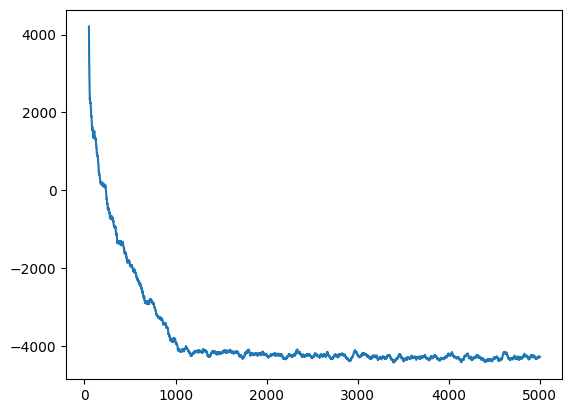

In [454]:
torch.manual_seed(0)
np.random.seed(0)

sgld_model = StochasticVolatility(torch_data.shape, sigma_lambda=10., nu_lambda=0.1)
lr = 0.001
burnin = 1000

optimizer = SGLD(sgld_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, 
                                        lr_lambda=lambda epoch: compute_lr(epoch, burnin=burnin, start=1.0))

epoch = 0
sgld_loss_seq = []
sgld_samples = []
for epoch in range(5000):
    print(f'========================================')
    sgld_model.zero_grad()
    
    r_samples, vol_samples = sgld_model()
    loss = sgld_model.loss(torch_data, vol_samples)
    loss.backward()
        
    optimizer.step()
    scheduler.step()

    print(f'[epoch={epoch+1}] loss: {loss.item():.5f}, last_lr: {scheduler.get_last_lr()}')
    sgld_loss_seq.append(loss.item())
    
    params = {name: param.item() for name, param in sgld_model.named_parameters() if name != 'vol'}
    vol_mean = sgld_model.init_vol + torch.cumsum(sgld_model.vol, dim=0) 
    vol = {f'vol_{i}':val for i, val in enumerate(vol_mean.cpu().detach().numpy())}
    params.update(vol)
    sgld_samples.append(params)
        
for name, param in sgld_model.named_parameters():
    print(f'{name} = {param}')
    if name in {'sigma', 'nu'}:
        print(f' * 1 / {name} = {1 / param}')

sgld_loss_seq = pd.Series(sgld_loss_seq)
sgld_loss_seq.rolling(50).mean().plot()

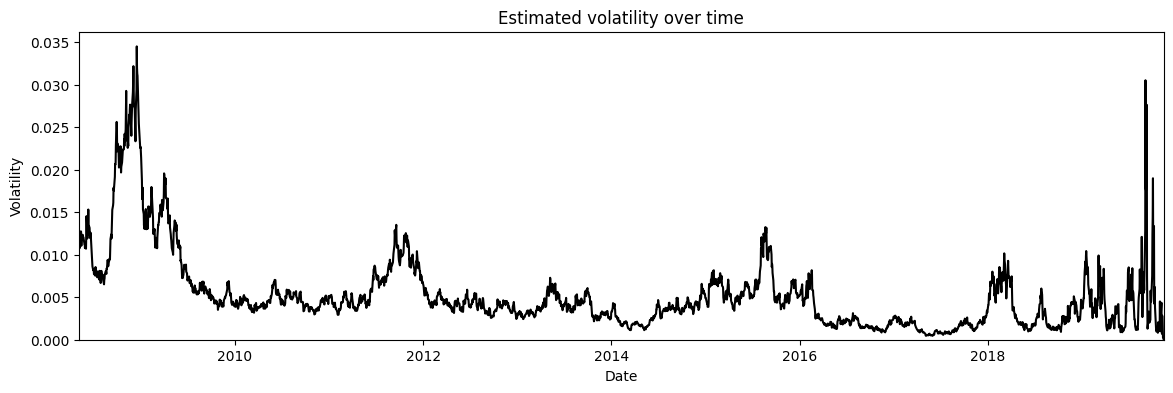

In [455]:
sigma_rv = distributions.Exponential(sgld_model.sigma)
sigma_mean = sigma_rv.mean

vol_mean = sgld_model.init_vol + torch.cumsum(sgld_model.vol, dim=0) 

fig, ax = plt.subplots(figsize=(14, 4))
y_vals = np.exp(vol_mean.cpu().detach().numpy())
x_vals = returns.index.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k")#, alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

In [461]:
df_sgld = pd.DataFrame(sgld_samples[burnin:])
df_sgld.describe()

sigma           nu     init_vol        vol_0        vol_1  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     11.034800     0.940866    -4.460325    -4.453986    -4.411681   
std       0.011124     0.022786     0.014521     0.019797     0.018711   
min      10.997263     0.878306    -4.496508    -4.497199    -4.458200   
25%      11.023720     0.924218    -4.470075    -4.466465    -4.428630   
50%      11.037717     0.948033    -4.455232    -4.445112    -4.408004   
75%      11.044865     0.959615    -4.449823    -4.441155    -4.398080   
max      11.051633     0.968914    -4.440108    -4.421614    -4.375416   

             vol_2        vol_3        vol_4        vol_5        vol_6  ...  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000  ...   
mean     -4.454167    -4.481563    -4.436186    -4.367519    -4.324256  ...   
std       0.021933     0.028373     0.031648     0.038695     0.040383  ...   
min      -4.497105    -4.535603    -4.495326    -4.439466    -4.394973  ...   
25%      -4.477869    -4.513221    -4.466881    -4.405686    -4.363953  ...   
50%      -4.448895    -4.470869    -4.428617    -4.358350    -4.325061  ...   
75%      -4.434845    -4.457855    -4.407135    -4.332396    -4.285218  ...   
max      -4.418420    -4.439834    -4.386113    -4.302129    -4.253287  ...   

          vol_2895     vol_2896     vol_2897     vol_2898     vol_2899  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     -6.345703    -5.721841    -5.477180    -6.092905    -6.722411   
std       0.305872     0.396567     0.597722     0.786145     0.832552   
min      -7.262240    -6.649410    -6.577117    -7.415442    -8.172453   
25%      -6.549863    -5.997759    -5.889559    -6.757744    -7.452981   
50%      -6.365674    -5.792289    -5.638120    -6.201192    -6.805857   
75%      -6.159759    -5.464228    -5.043307    -5.500119    -6.113322   
max      -5.265937    -4.305730    -3.709325    -3.848607    -4.384663   

          vol_2900     vol_2901     vol_2902     vol_2903     vol_2904  
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000  
mean     -5.333305    -7.661488    -7.801739    -8.524757   -12.000544  
std       0.675268     0.723580     0.808795     0.923314     0.732825  
min      -6.653117    -9.009790    -9.317273   -10.266315   -13.667579  
25%      -5.938635    -8.358667    -8.634175    -9.511640   -12.771265  
50%      -5.270775    -7.598399    -7.632271    -8.392457   -11.847056  
75%      -4.894388    -7.136958    -7.246654    -7.864813   -11.474759  
max      -3.437534    -5.706642    -5.692614    -6.047866    -9.882013  

[8 rows x 2908 columns]

In [462]:
df_vol = np.exp(df_sgld[[x for x in df_sgld.columns if x.startswith('vol_')]])
df_vol = df_vol.transpose(copy=True)
df_vol.index = list(range(len(df_vol.index)))
df_vol.describe()

0            1            2            3            4     \
count  2905.000000  2905.000000  2905.000000  2905.000000  2905.000000   
mean      0.010531     0.006741     0.004606     0.006008     0.005758   
std       0.007060     0.004662     0.004301     0.004580     0.004534   
min       0.000011     0.000003     0.000002     0.000005     0.000006   
25%       0.006164     0.003701     0.001977     0.003040     0.002796   
50%       0.007855     0.005522     0.003426     0.004829     0.004610   
75%       0.012565     0.007992     0.005532     0.007270     0.007034   
max       0.092979     0.034709     0.031773     0.038138     0.040286   

              5            6            7            8            9     ...  \
count  2905.000000  2905.000000  2905.000000  2905.000000  2905.000000  ...   
mean      0.004972     0.005299     0.006807     0.007819     0.005801  ...   
std       0.004471     0.004494     0.004817     0.005334     0.004500  ...   
min       0.000005     0.000006     0.000011     0.000017     0.000008  ...   
25%       0.002191     0.002486     0.003736     0.004550     0.003022  ...   
50%       0.003849     0.004240     0.005661     0.006399     0.004717  ...   
75%       0.005999     0.006368     0.008105     0.009321     0.006837  ...   
max       0.032813     0.036748     0.057414     0.080926     0.034203  ...   

              3990         3991         3992         3993         3994  \
count  2905.000000  2905.000000  2905.000000  2905.000000  2905.000000   
mean      0.005165     0.005147     0.005113     0.004937     0.004887   
std       0.004507     0.004494     0.004501     0.004435     0.004431   
min       0.000002     0.000002     0.000002     0.000002     0.000002   
25%       0.002479     0.002466     0.002422     0.002308     0.002254   
50%       0.004121     0.004112     0.004083     0.003913     0.003874   
75%       0.005857     0.005838     0.005768     0.005499     0.005454   
max       0.034443     0.034437     0.034517     0.034074     0.034077   

              3995         3996         3997         3998         3999  
count  2905.000000  2905.000000  2905.000000  2905.000000  2905.000000  
mean      0.004996     0.005072     0.005080     0.005184     0.005235  
std       0.004447     0.004437     0.004455     0.004468     0.004493  
min       0.000002     0.000002     0.000002     0.000002     0.000002  
25%       0.002357     0.002423     0.002419     0.002500     0.002539  
50%       0.003966     0.004056     0.004052     0.004162     0.004197  
75%       0.005610     0.005742     0.005757     0.005899     0.005964  
max       0.034088     0.034057     0.034130     0.034204     0.034492  

[8 rows x 4000 columns]

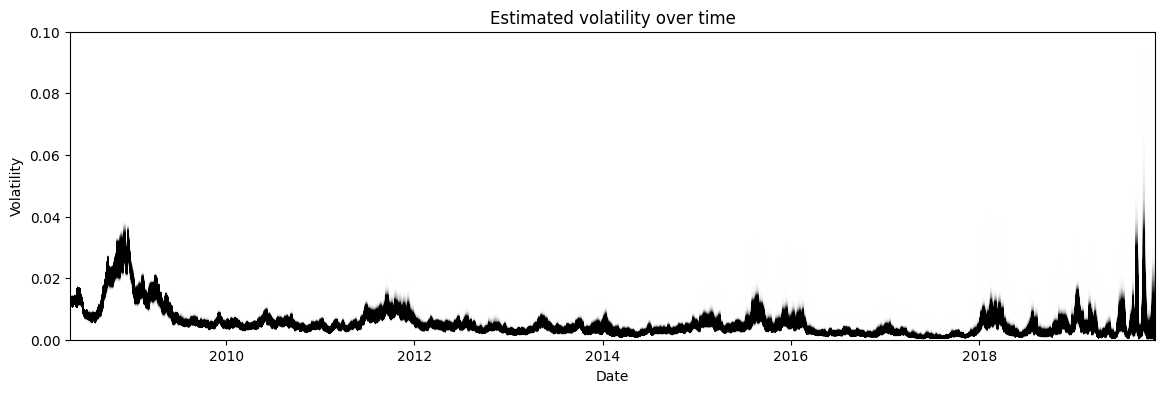

In [463]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = df_vol
time_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5)).time
x_vals = time_vals.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0, top=0.10)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

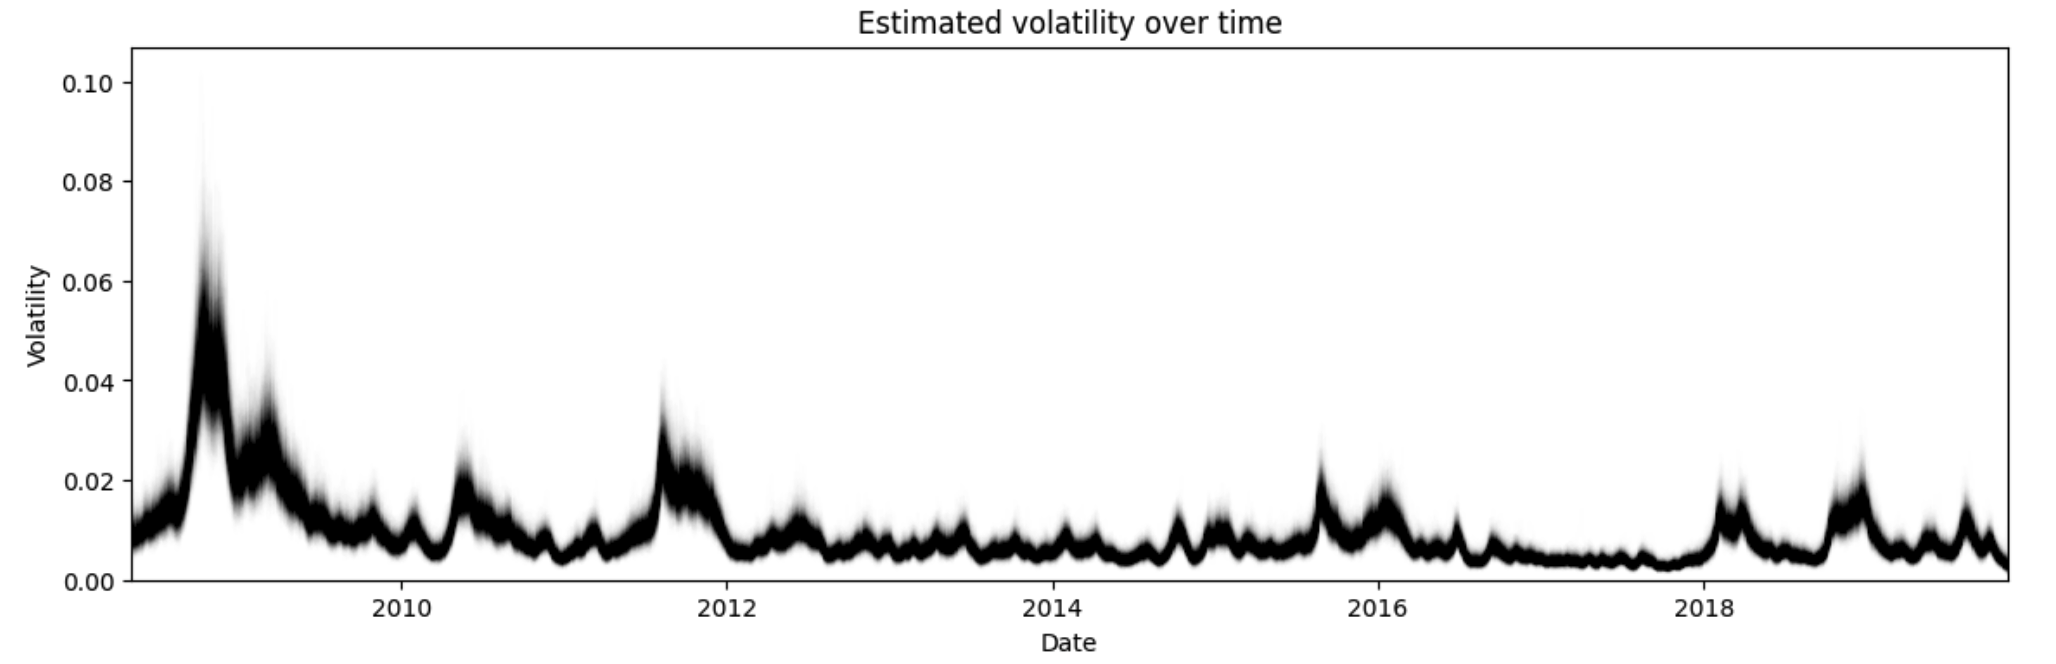

<AxesSubplot: >

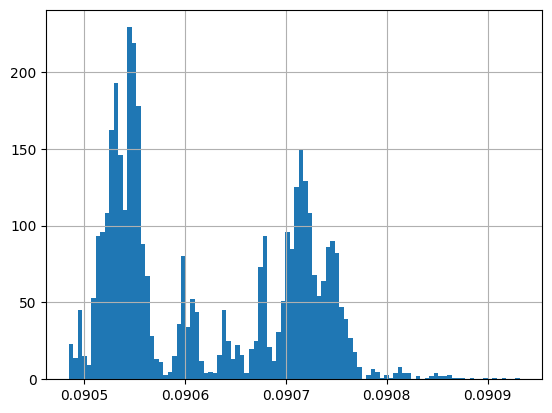

In [468]:
df_sgld['sigma'].apply(lambda x: 1. / x).hist(bins=100)

<AxesSubplot: >

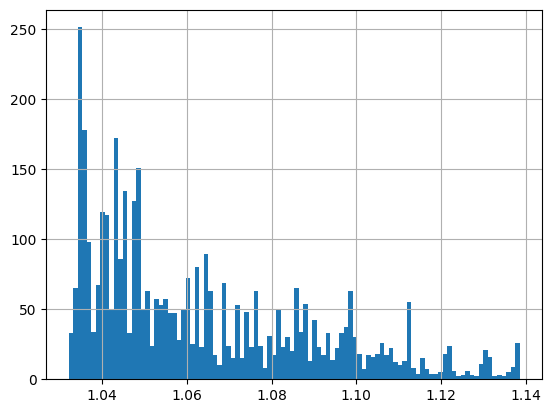

In [469]:
df_sgld['nu'].apply(lambda x: 1. / x).hist(bins=100)

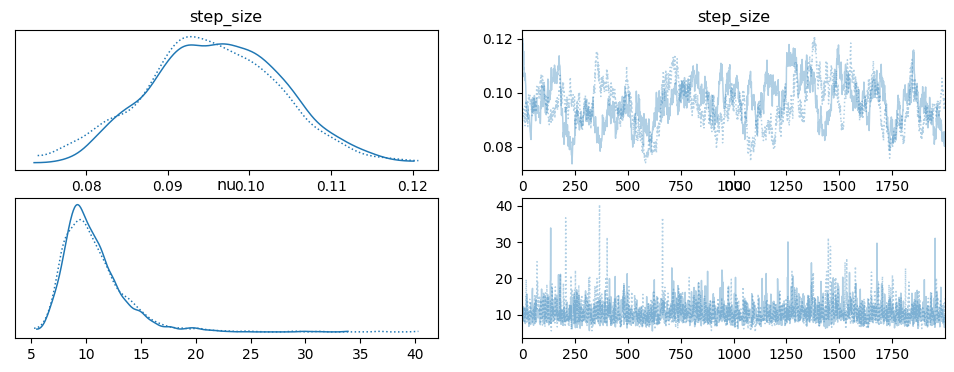

# 2022-11-12

* Had a conceptual bug where I was putting a "prior" on the volatility, even though it's completely specified from the sigma -- that's what happens when I don't actual write out the math first
* I also increased the batch size to 100, it seems to have stabilizing effect so that the loss is less noisy -- this is exatly what I was hoping for but didn't play around with it until now (had it at 10 for a while)
* I also added a random seed to be able to reproduce the same run
* I also "tuned" the number of epochs with regular SGD -- I just kept trying to find a number that looked similar to the estimated volatility over time.
    * It's a bit fickle because the randomness of the vol sampling moves it around a bit
    * Also, I can keep running SGD and lowering the loss but the plot doesn't at all look like the volatility --it just keeps getting smaller
    * I think it it may be because the output is a t-distributed with zero mean, so making the vol smaller (and deg freedom) make the loss lower (I think?)
* With those changes, I get something that *sort of* resembles the volatility from HMC, except:
    * The start of the series has lower volatility -- could be because it's hard to back propagate towards there?
    * The end of the series has really high volatility compared to HMC -- could be some instability

TODO: 

* Start writing!


# 2022-11-11

* Had a bug in SGLD optimizer where I wasn't actually adding noise to the parameter -- fixed now
* The paper "Preconditioned Stochastic Gradient Langevin Dynamics for Deep Neural Networks", also mentions the concept of "burnin" and "thinning" same as MCMC
* Set burnin = 500, and thinning to 10, One of the runs had the resulting graph is below
* I still get a ton of variance at the tail end because of the random walk
    * It may be the additional variance I add because of the "reparameterization" trick I need to do with the intermediate variables
    

TODO: 

* Do some cleanup

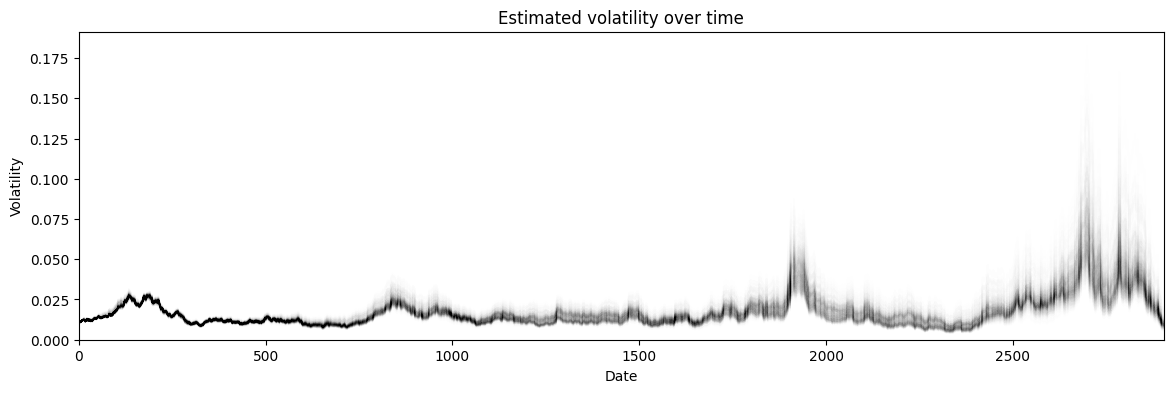

# 2022-11-10

* Not getting a big range of uncertainty (see figure).  Could be the noise term is too small?
* It makes sense that the uncertainty is bigger in later time steps because its variance is dependent on all previous timesteps -- how come it doesn't show up in MCMC though?

TODO: 

* Still need to investigate

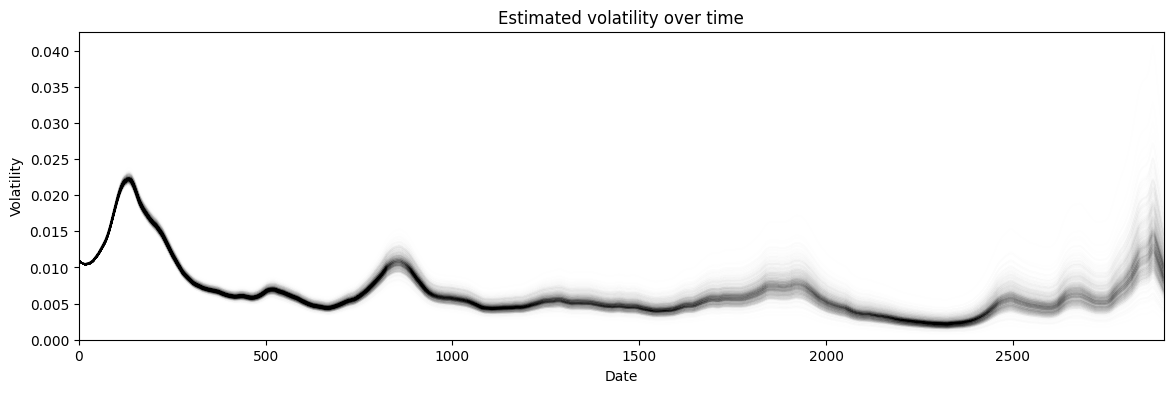

# 2022-11-09

* Generated samples from SGLD and put them in a dataframe

TODO: 

* Take a look to see if it at all resembles the MCMC method

# 2022-11-04

* Implemented the noise optimizer (I think it's working?)

TODO:

* Have to adjust the learning schedule accordingly, will have to figure out what that looks like...

# 2022-11-02

* To implement SGLD, I just really need to add in the noise term
    * I can do this by just inheriting from the Adam class and add the noise term.
* To implement the RMSProp (I'll be using ADAM) preconditioning, looks like I just need to adjust the learning rate
    * I should be able to modify my optimizer class

TODO:
* Implement the optimizer
* Figure out what LR schedule I actually need

# 2022-10-30

* I realized `nu` was off because it close to 2 (instead of the MAP in the model which is around 10)
* After further investigation, it looks like the mode of the posteriod (MAP estimate) shrinks `sigma` and `nu` (the random variables, not the parameters, which is the inverse) to 0.  So there must be a MODE collapse?
* Actually, this happened after I removed the `rsample()` from `nu` and `sigma`.  Adding them back probably slows the rate of decrease down, but probably not eliminates this effect.
* The priors for sure shrink them down to 0 (exponential distribution)
* It kind of looks like the likelihood also does as well?  
    * It's kind of hard to tell because of the indirection, but it's likely that it's at least true for `nu`, which wants to get "fatter" with a higher `nu`, which makes sense given that volatility is always relatively big and not close to 0.

# 2022-10-29

* Think I fixed it to work with batch updating:
    * Got rid of the superfluous `.expands()`
    * Loss: 
        * Priors operate directly on the parameters (NOT the reparameterized samples)
        * Had a bug where I was not using the diff as a prior (because I was using samples, not parameter values)
    * Use ADAM -- this was really important!  I got something *close* to the shape of HMC once every 10 runs or so.  Switching to ADAM, I pretty much the same shape every time.  It makes sense since the parameters probably have such different gradients due to the long chain, and probably having their own learning rates really makes a big difference.
    
TODO:
* Clean up code
* Move on to try SGLD, probably will need that extension paper where they use RMSProp instead of preconditioning matrix.
    
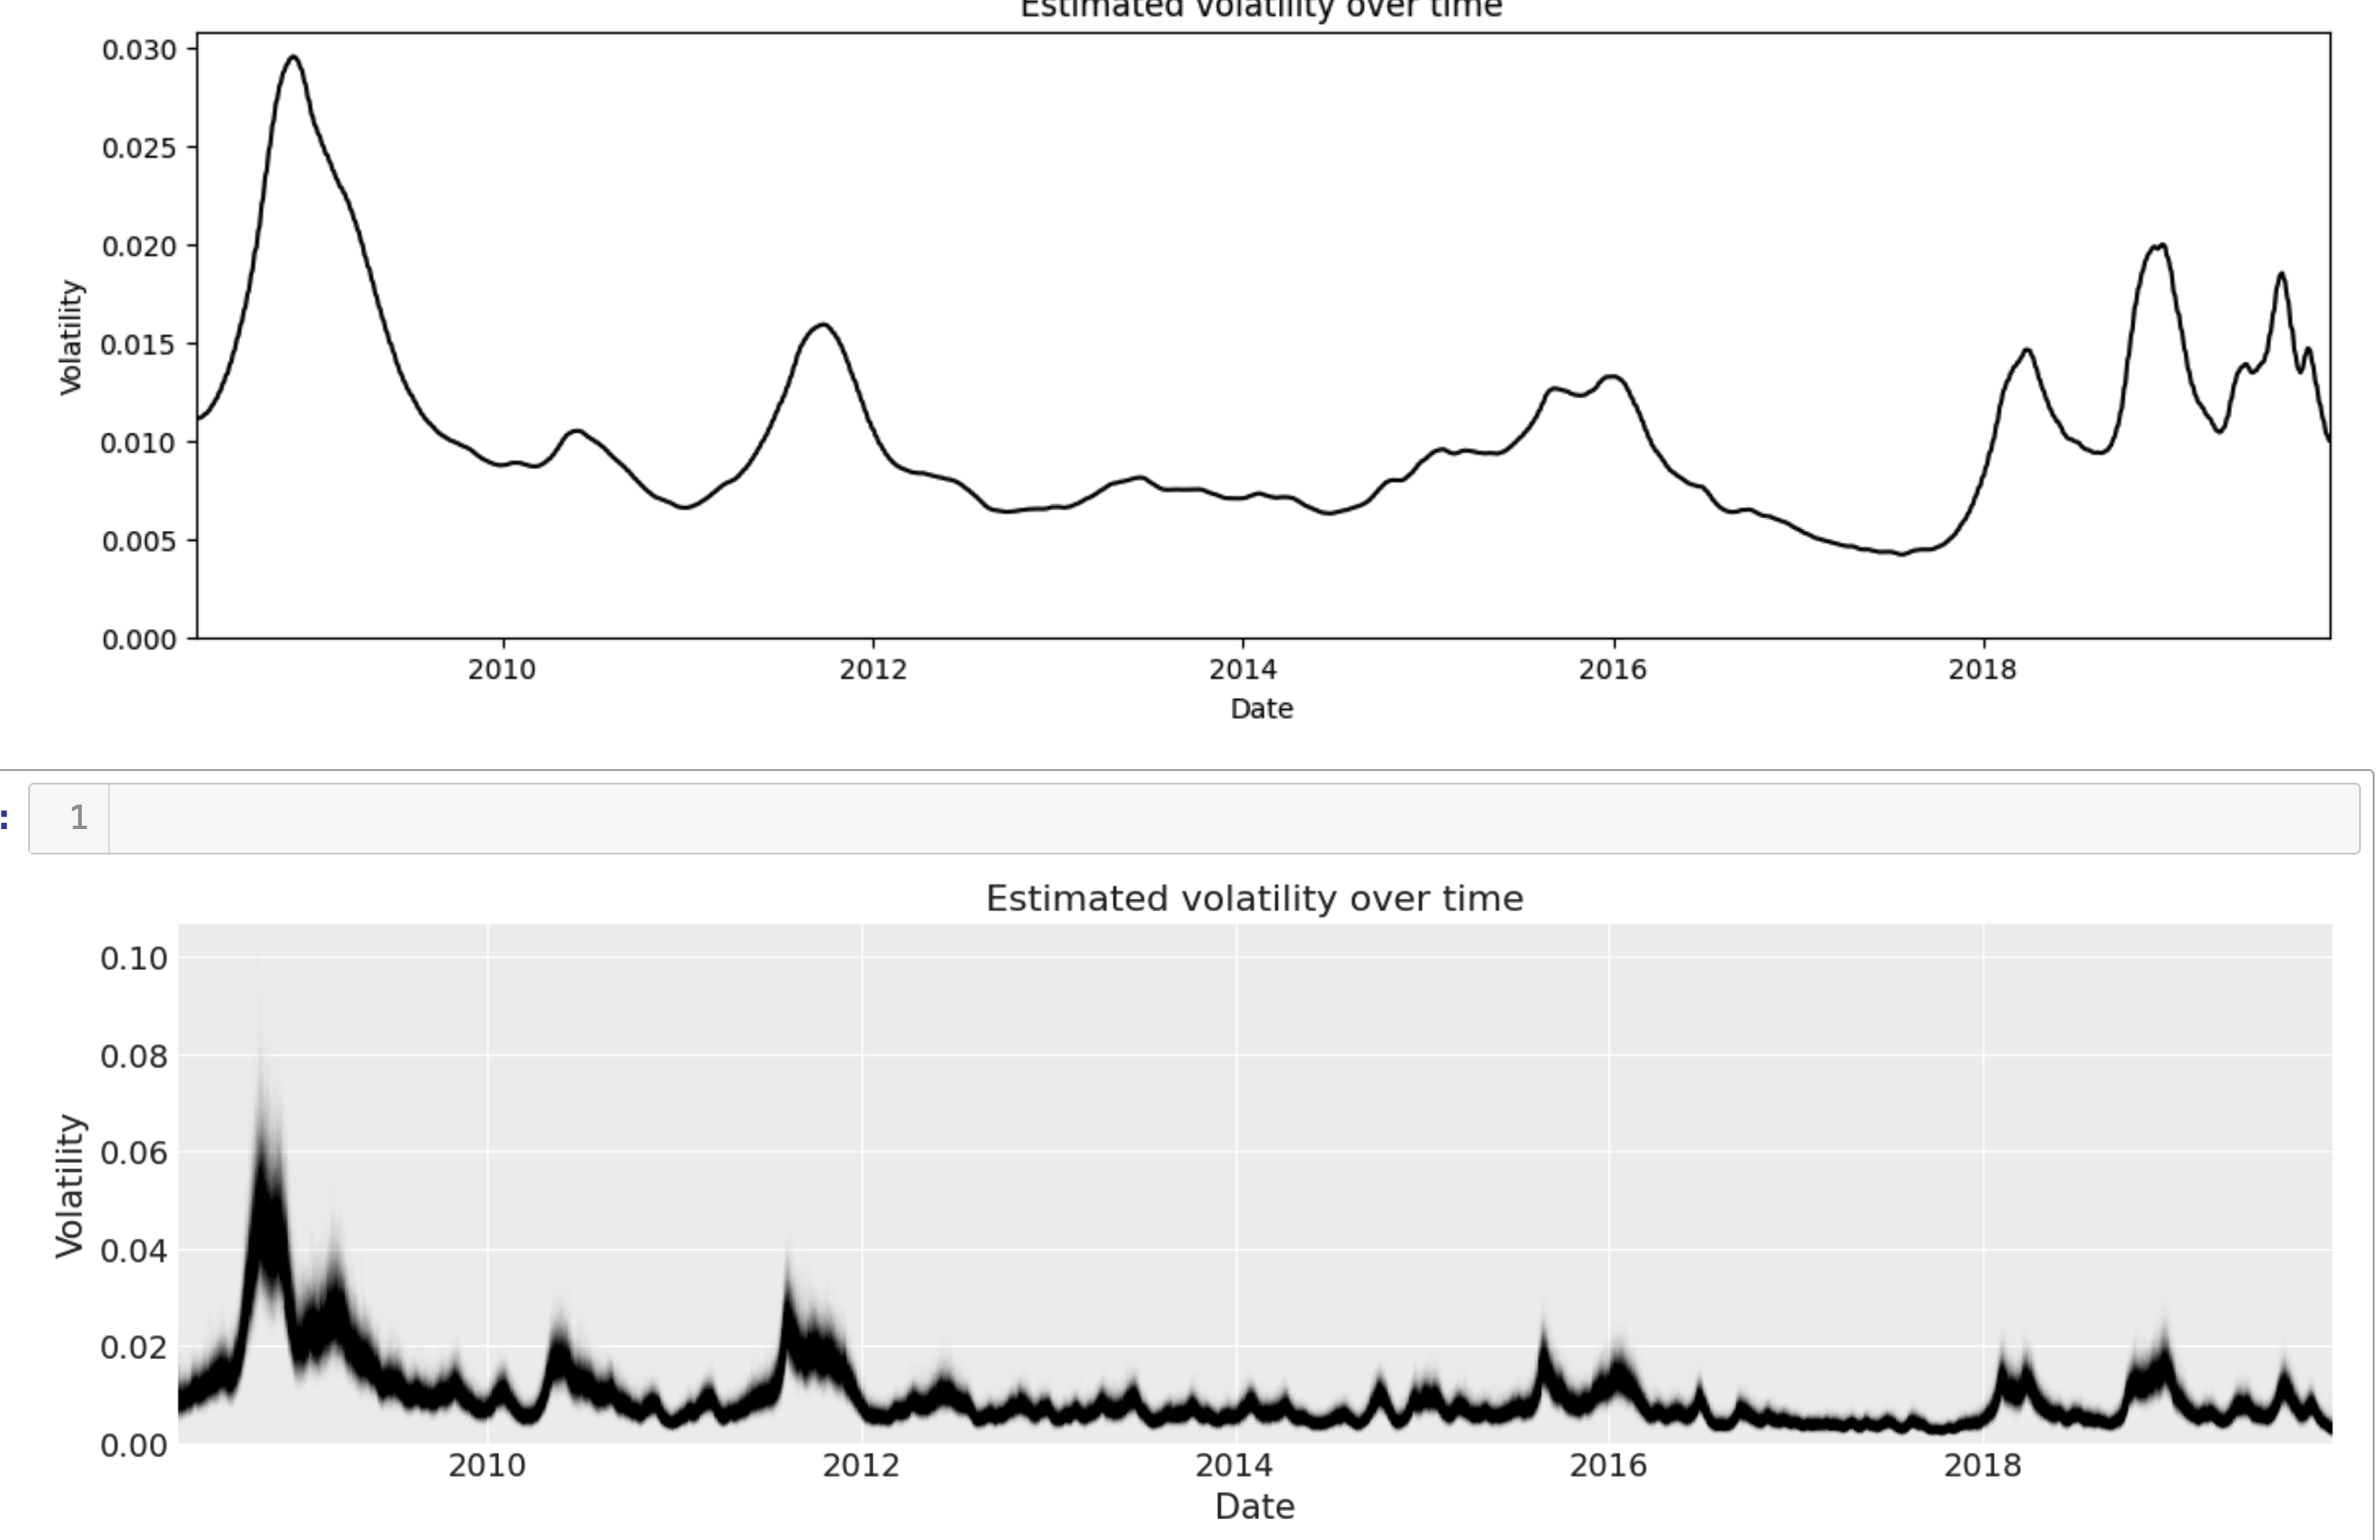


# 2022-10-24

* Fixed up some things in batch implementation, don't use `expand()` because it may have been not back proping through (not sure about that)
    * But using the cleaner method of just using `rsample(sample_size=...)` instead to generate batch needed
* Results still look kind of wrong since I can't mimic the stochastic volatility shape anymore (but the `lambda` and `nu` parameters are very close to the HMC modes / MAP).

TODO:
* Validate each of the batch calculations to make sure I'm generating the right value

# 2022-10-23

* Added `rsample()` to degrees freedom
* With the new changes it gets to the right place... sometimes:
    * There is a lot of variance based on the samples that are drawn from `rsample` and sometimes I get a low-ish loss that is similar in shape, sometimes I get something totally off
* I tried implementing "batch-ing" to average over multiple draws, but it doesn't seem to be learning that fast.

TODO:
* Validate my batch-ing implementation and figure out why it's not learning very fast

# 2022-10-22

* Found another conceptual difference.  I need to sample from each random variable in my DAG using `::rsample()`.
  * So the actual parameters in my torch model are simply the parameters of the random variables (e.g. `sigma` is rate of my exponential step size dist, `self.vol` is mean for the random walk gaussians etc.)
  * So to do a forward pass, I sample from rate, then I sample from vol, then I sample from t-dist (and sample from degrees freedom somewhere)
  * This fixed a lot of issues:
       * We can now backprop all the way through to `self.sigma` instead of only through prior regularizer
       * Misintepreted sigma to be the sample, NOT the rate parameter

TODO:
* Take a look at results in more detail
* May have to do SGD batch-like behavior so that we can smooth the gradient updates (and to smooth the `rsamples`)

# 2022-10-20

* Realized `self.vol` was really just the differences between normal distributions, so the prior can just be evaluated using the $N(0, \sigma^2)$ distribution, simplifying the logic
* I realized the initial value of the Gaussian random walk matters a lot, otherwise there is a discontinuity in the first time step, which throws everything off.  I set it at roughly $log(0.01)$, which is close to the first value I see in the MCMC simulation. 
    * It roughly follows the shape of the posterior from MCMC
    * The scale is off though, most likely because $\sigma$ is very small -- still need to figure out what the deal with that is.
    
    
TODO:
* It also looks like the `vol_init` changes very slowly (along with DF).  Why is that?
    * Is this a case of vanishing gradient (it has to backprop through ~3000 timesteps)?
* Why does $\sigma$ always tend towards negative?  Still need to figure this out...


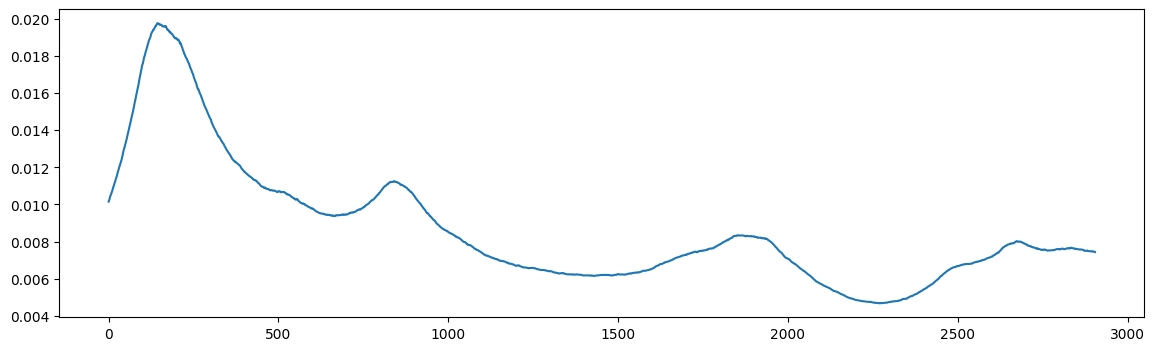

# 2022-10-15

* Fixed: Prior should not be multiplied by len(trace) because $P(X,Y|Z)P(Z) = P(X|Z) P(Y|Z)P(Z)$ where $X$ and $Y$ are conditionally independent given $Z$.  So we only need on prior ($Z$) not one for each of $X,Y$
* Did more debugging, seems like instability in gradient is causing some of my problems
    * See the gradient on sigma blows up for some reason.  Maybe this is like the RNN kind of problem with gradient instability and long traces (we do have a trace of ~3000)

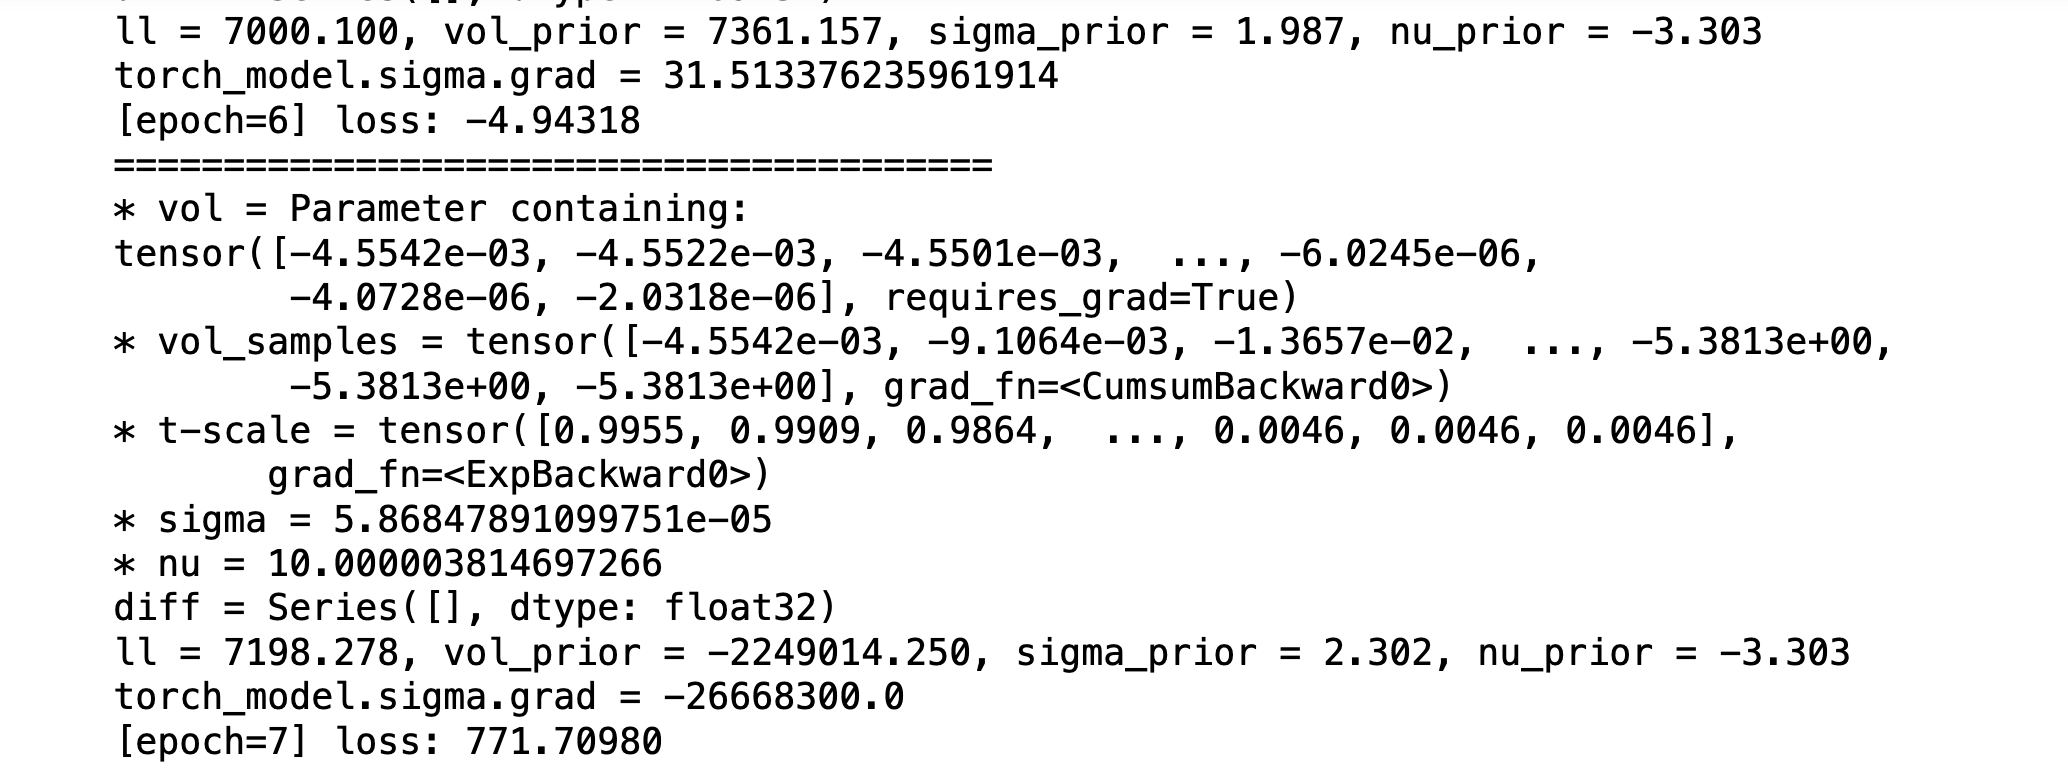

# 2022-10-10

* Had the modelling wrong, I need a Torch parameter for *each* latent variable in the model (not just the top level sigma/nu).  This means I need one for each step of the volatility random walk.
  * I also had a little bug with the reparameterization of t-dist from lambda to sigma (since they are inverse square of each other)
* Got it working, but... I still sometimes get negative values for \sigma since Torch doesn't care if it can eventually go negative.  I think the solution is to re-write it in terms of log(X) where X ~ exponentially distributed. See: https://math.stackexchange.com/questions/2244210/distribution-of-logx-for-exponentially-distributed-x
  * I did a hack by just taking ABS value of sigma, but that doesn't seem right.  Gradient seems off.
* Yeah the gradient of sigma gets huge after it gets close to 0, so I think I need the log parameterization or else the gradient is just going to be crazy.


TODO: 
* Use the log(X) trick to make sure \sigma doesn't go negative
* Double check logic again, sigma keeps going more negative, which is kind of odd why that would happen

# 2022-10-08

* Got the basic framework up for model in PyTorch
* Looks like $sigma$ is going negative though which causes error when used as scale for Gaussian

TODO:

* Double check the model specification, found errors in different parameterization of scales (in Normal and Gaussian)
* Also check loss function is doing what I think it should be...